In [242]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic
from scipy.integrate import cumulative_trapezoid
from astropy.coordinates import SkyCoord
from scipy.ndimage import gaussian_filter
import seaborn as sns

import sys
sys.path.append('../src')
import plotting, helpers
from importlib import reload

%config InlineBackend.figure_format = 'retina'


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': 0.7*fs,
          'legend.title_fontsize': 0.8*fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load data

In [2]:
singles = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/singles", parts=[])
binaries = cogsworth.pop.load("/mnt/ceph/users/twagg/underworld/binaries", parts=[])

/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(
/mnt/home/twagg/codes/gala/src/gala/potential/potential/builtin/special.py:257: GalaFutureWarning: The MilkyWayPotential2022 class will be deprecated soon. Instead, use: MilkyWayPotential(version="v2") to get what is currently the MilkyWayPotential2022 class. Or, to always use the latest Milky Way model in Gala, you can call the class with no arguments MilkyWayPotential() or specify MilkyWayPotential(version="latest")
  warnings.warn(


In [3]:
singles.label = "Singles"
singles.colour = "darkgrey"
binaries.label = "Binaries"
binaries.colour = "#96B73B"

for pop in [singles, binaries]:
    pop.bpp["row_num"] = np.arange(len(pop.bpp))

# Totals

In [4]:
scale_up = 6e10 / binaries.mass_binaries
scale_up

np.float64(3307.606976577281)

Singles
  Total: 195100, NSs: 143842, BHs: 51258
Binaries
  Total: 200093, NSs: 144806, BHs: 55287


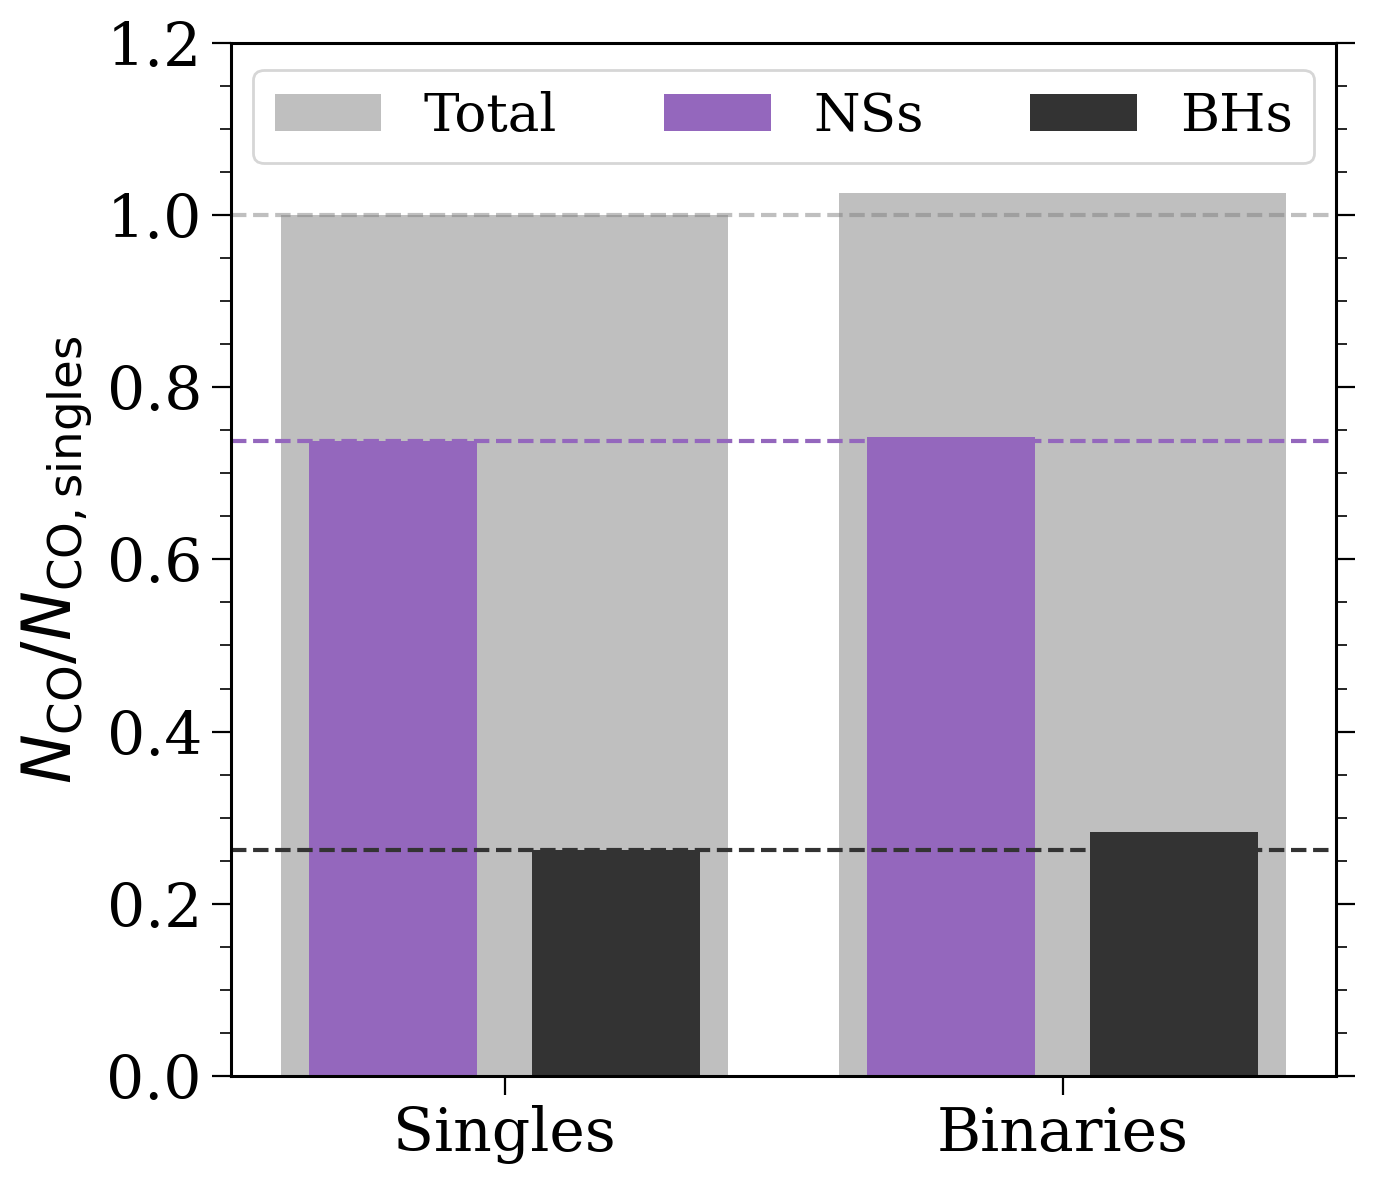

In [5]:
fig, ax = plt.subplots(figsize=(7, 6))

total_single_cos = None

for i, pop in enumerate([singles, binaries]):
    n_ns = (pop.final_bpp["kstar_1"] == 13).sum() + (pop.final_bpp["kstar_2"] == 13).sum()
    n_bh = (pop.final_bpp["kstar_1"] == 14).sum() + (pop.final_bpp["kstar_2"] == 14).sum()
    print(f"{pop.label}\n  Total: {n_ns + n_bh}, NSs: {n_ns}, BHs: {n_bh}")

    if total_single_cos is None and pop.label == "Singles":
        total_single_cos = n_ns + n_bh

    ax.bar(i, (n_ns + n_bh) / total_single_cos, label="Total" if i == 0 else None, color="grey", alpha=0.5)
    ax.bar(i - 0.2, n_ns / total_single_cos, width=0.3, label="NSs" if i == 0 else None, color="tab:purple")
    ax.bar(i + 0.2, n_bh / total_single_cos, width=0.3, label="BHs" if i == 0 else None, color="#333")

    if i == 0:
        ax.axhline((n_ns + n_bh) / total_single_cos, color="grey", alpha=0.5, ls='--')
        ax.axhline(n_ns / total_single_cos, color="tab:purple", ls='--')
        ax.axhline(n_bh / total_single_cos, color="#333", ls='--')

ax.set_xticks([0, 1], ["Singles", "Binaries"])
ax.set_ylabel(r"$N_{\rm CO} / N_{\rm CO, singles}$")
ax.legend(ncol=3, loc='upper center', fontsize=0.8*fs)

ax.set(
    ylim=(0, 1.2),
)

ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.2))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.05))

# show yticks on both sides
ax.yaxis.set_ticks_position('both')

plt.tight_layout()
plt.show()

## Takeaways

Binaries are produce slightly more compact objects?

- Mergers increasing the amount that can reach core-collapse?

Binaries don't have a strong effect on the NSs, but slightly increase the BH total.

- Hypothesis: Stars can now become NSs, some NSs can now become BHs, BHs only go up


## It's mergers right?

Mergers can both increase and decrease the total number of COs formed from a given total stellar mass since:

1. A merger of two stars that could both have become COs decreases your CO count by 1
2. A merger of two low mass stars that couldn't become COs without merging increases your count by 1

Arguably from the IMF, the latter should be more common and so binaries should make many more COs

In [6]:
stellar_merger_nums = binaries.bpp[(
    (
        (binaries.bpp['kstar_1'] == 15) & (binaries.bpp["kstar_2"] < 13)
    ) | (
        (binaries.bpp['kstar_2'] == 15) & (binaries.bpp["kstar_1"] < 13)
    )
)].drop_duplicates(subset="bin_num", keep="first")["bin_num"]

In [7]:
merger_inits = binaries.initC.loc[stellar_merger_nums]

In [8]:
LIM = 7.5
high_mass_mergers = (merger_inits["mass_1"] >= LIM) & (merger_inits["mass_2"] >= LIM)
low_mass_mergers = (merger_inits["mass_1"] < LIM) & (merger_inits["mass_2"] < LIM)

print(f"Total mergers: {len(merger_inits)}")
print(f"  High mass mergers: {high_mass_mergers.sum()} ({high_mass_mergers.sum() / len(merger_inits):.2%})")
print(f"  Low mass mergers: {low_mass_mergers.sum()} ({low_mass_mergers.sum() / len(merger_inits):.2%})")

Total mergers: 137231
  High mass mergers: 40927 (29.82%)
  Low mass mergers: 49154 (35.82%)


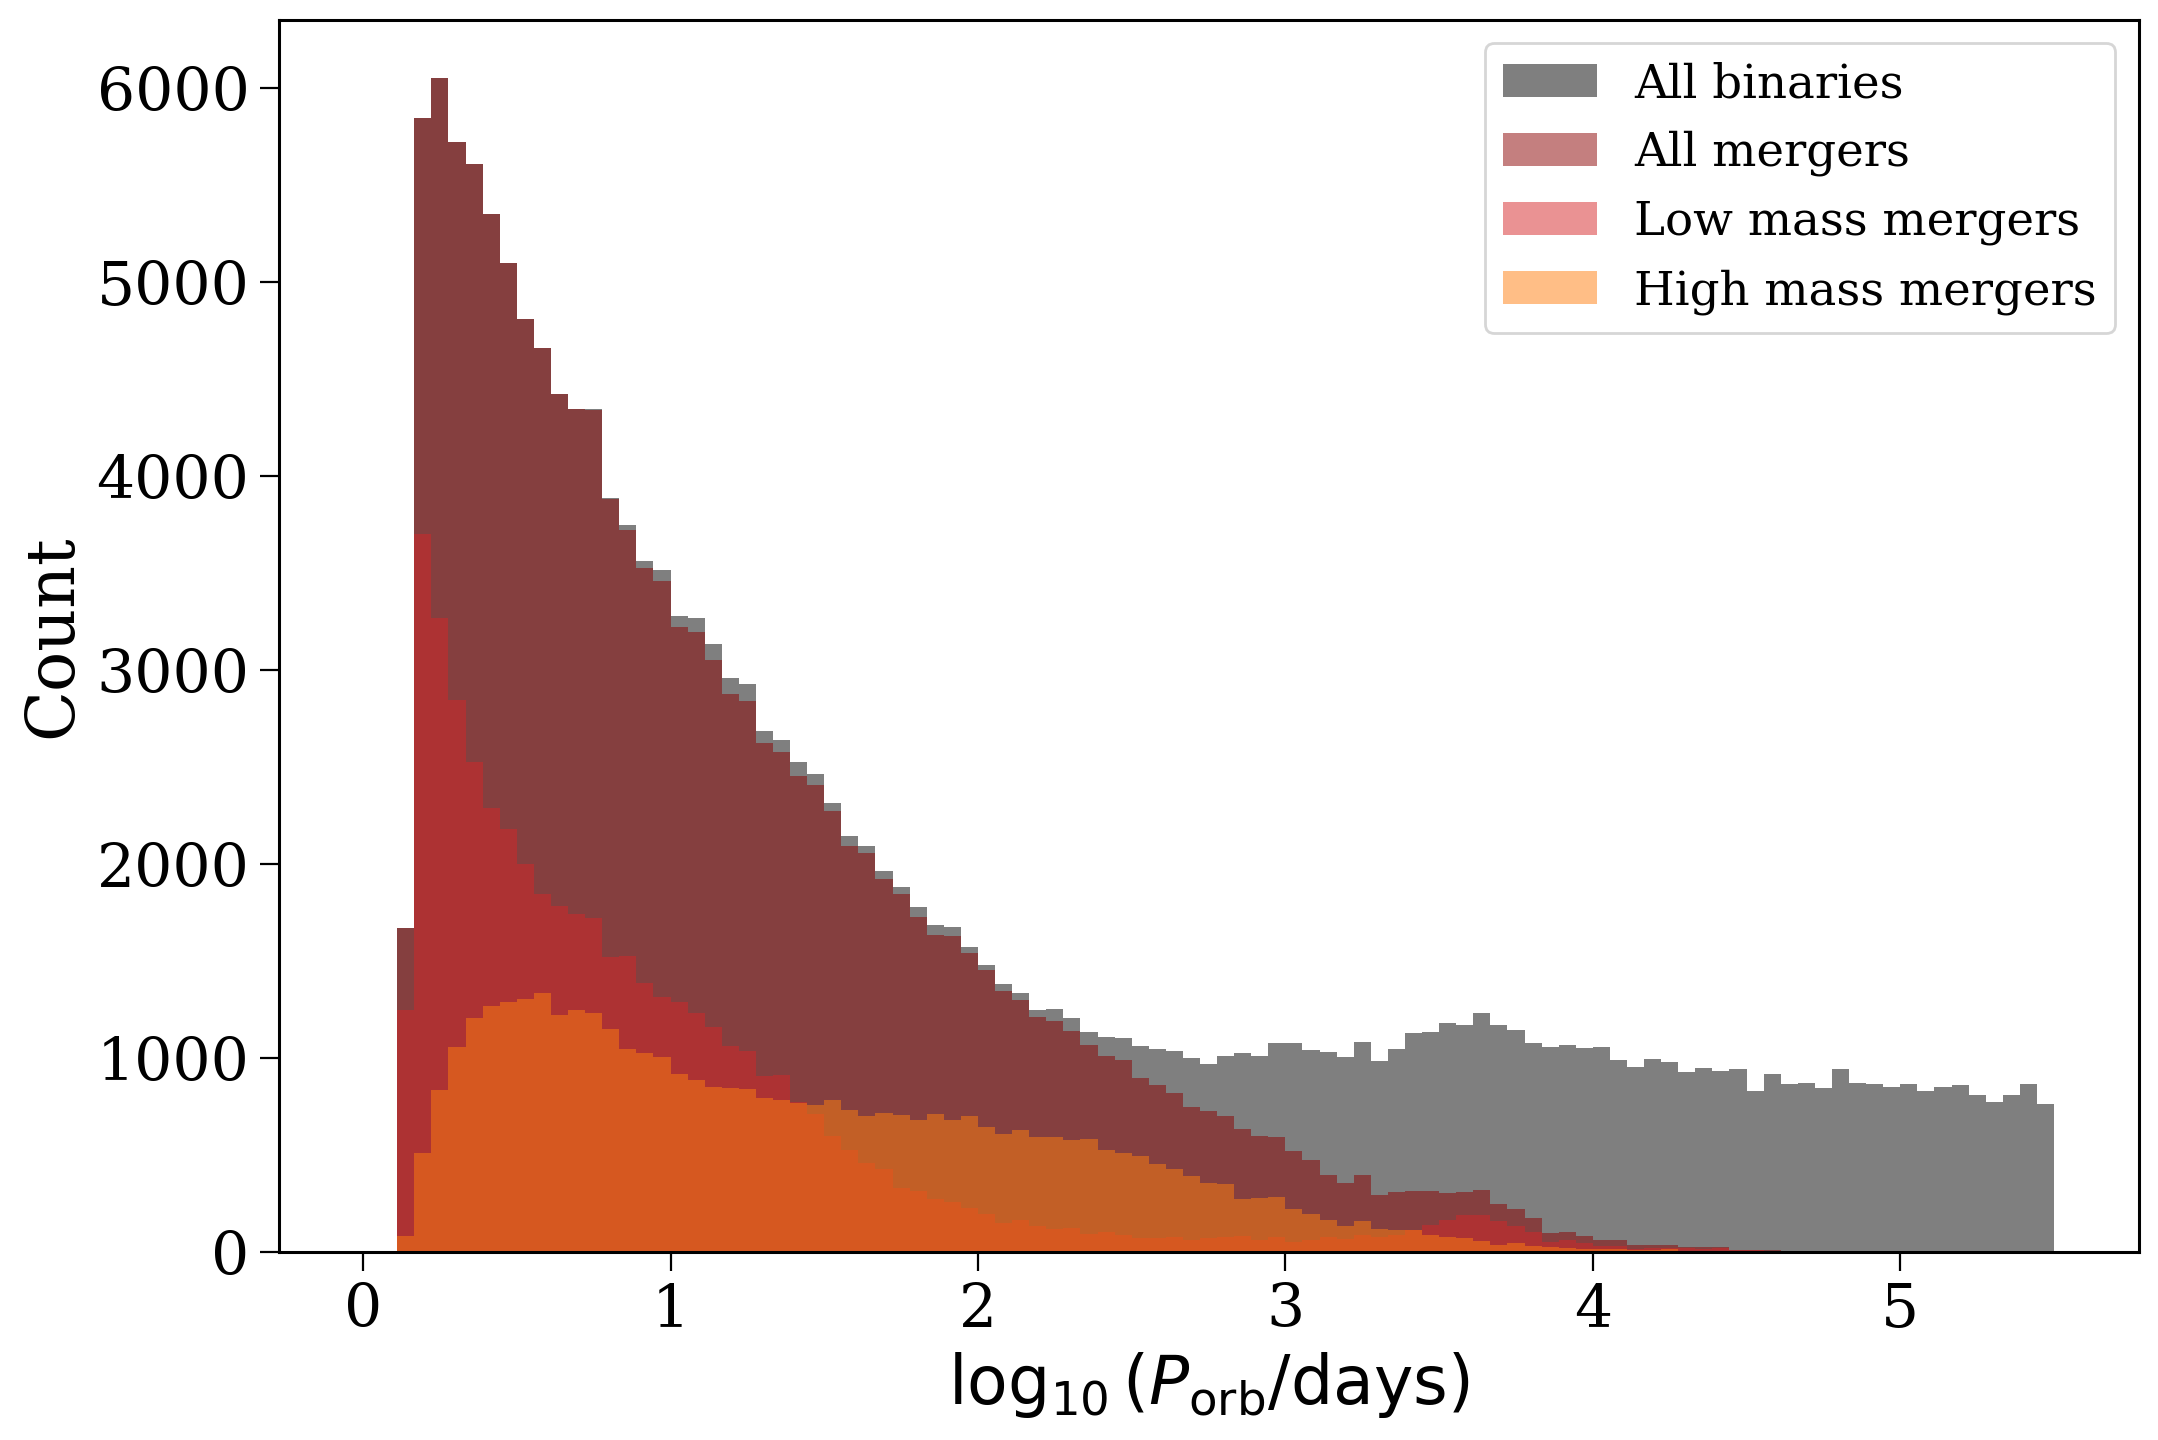

In [18]:
fig, ax = plt.subplots()

ax.hist(np.log10(binaries.initC["porb"]), bins=np.linspace(0, 5.5, 100), alpha=0.5, label="All binaries", color="black")
ax.hist(np.log10(merger_inits["porb"]), bins=np.linspace(0, 5.5, 100), alpha=0.5, label="All mergers", color="darkred")
ax.hist(np.log10(merger_inits["porb"][low_mass_mergers]), bins=np.linspace(0, 5.5, 100), alpha=0.5, label="Low mass mergers", color="tab:red")
ax.hist(np.log10(merger_inits["porb"][high_mass_mergers]), bins=np.linspace(0, 5.5, 100), alpha=0.5, label="High mass mergers", color="tab:orange")

ax.set(
    xlabel=r"$\log_{10}(P_{\rm orb} / \mathrm{days})$",
    ylabel="Count",
)
ax.legend()
plt.show()

# Mass distributions

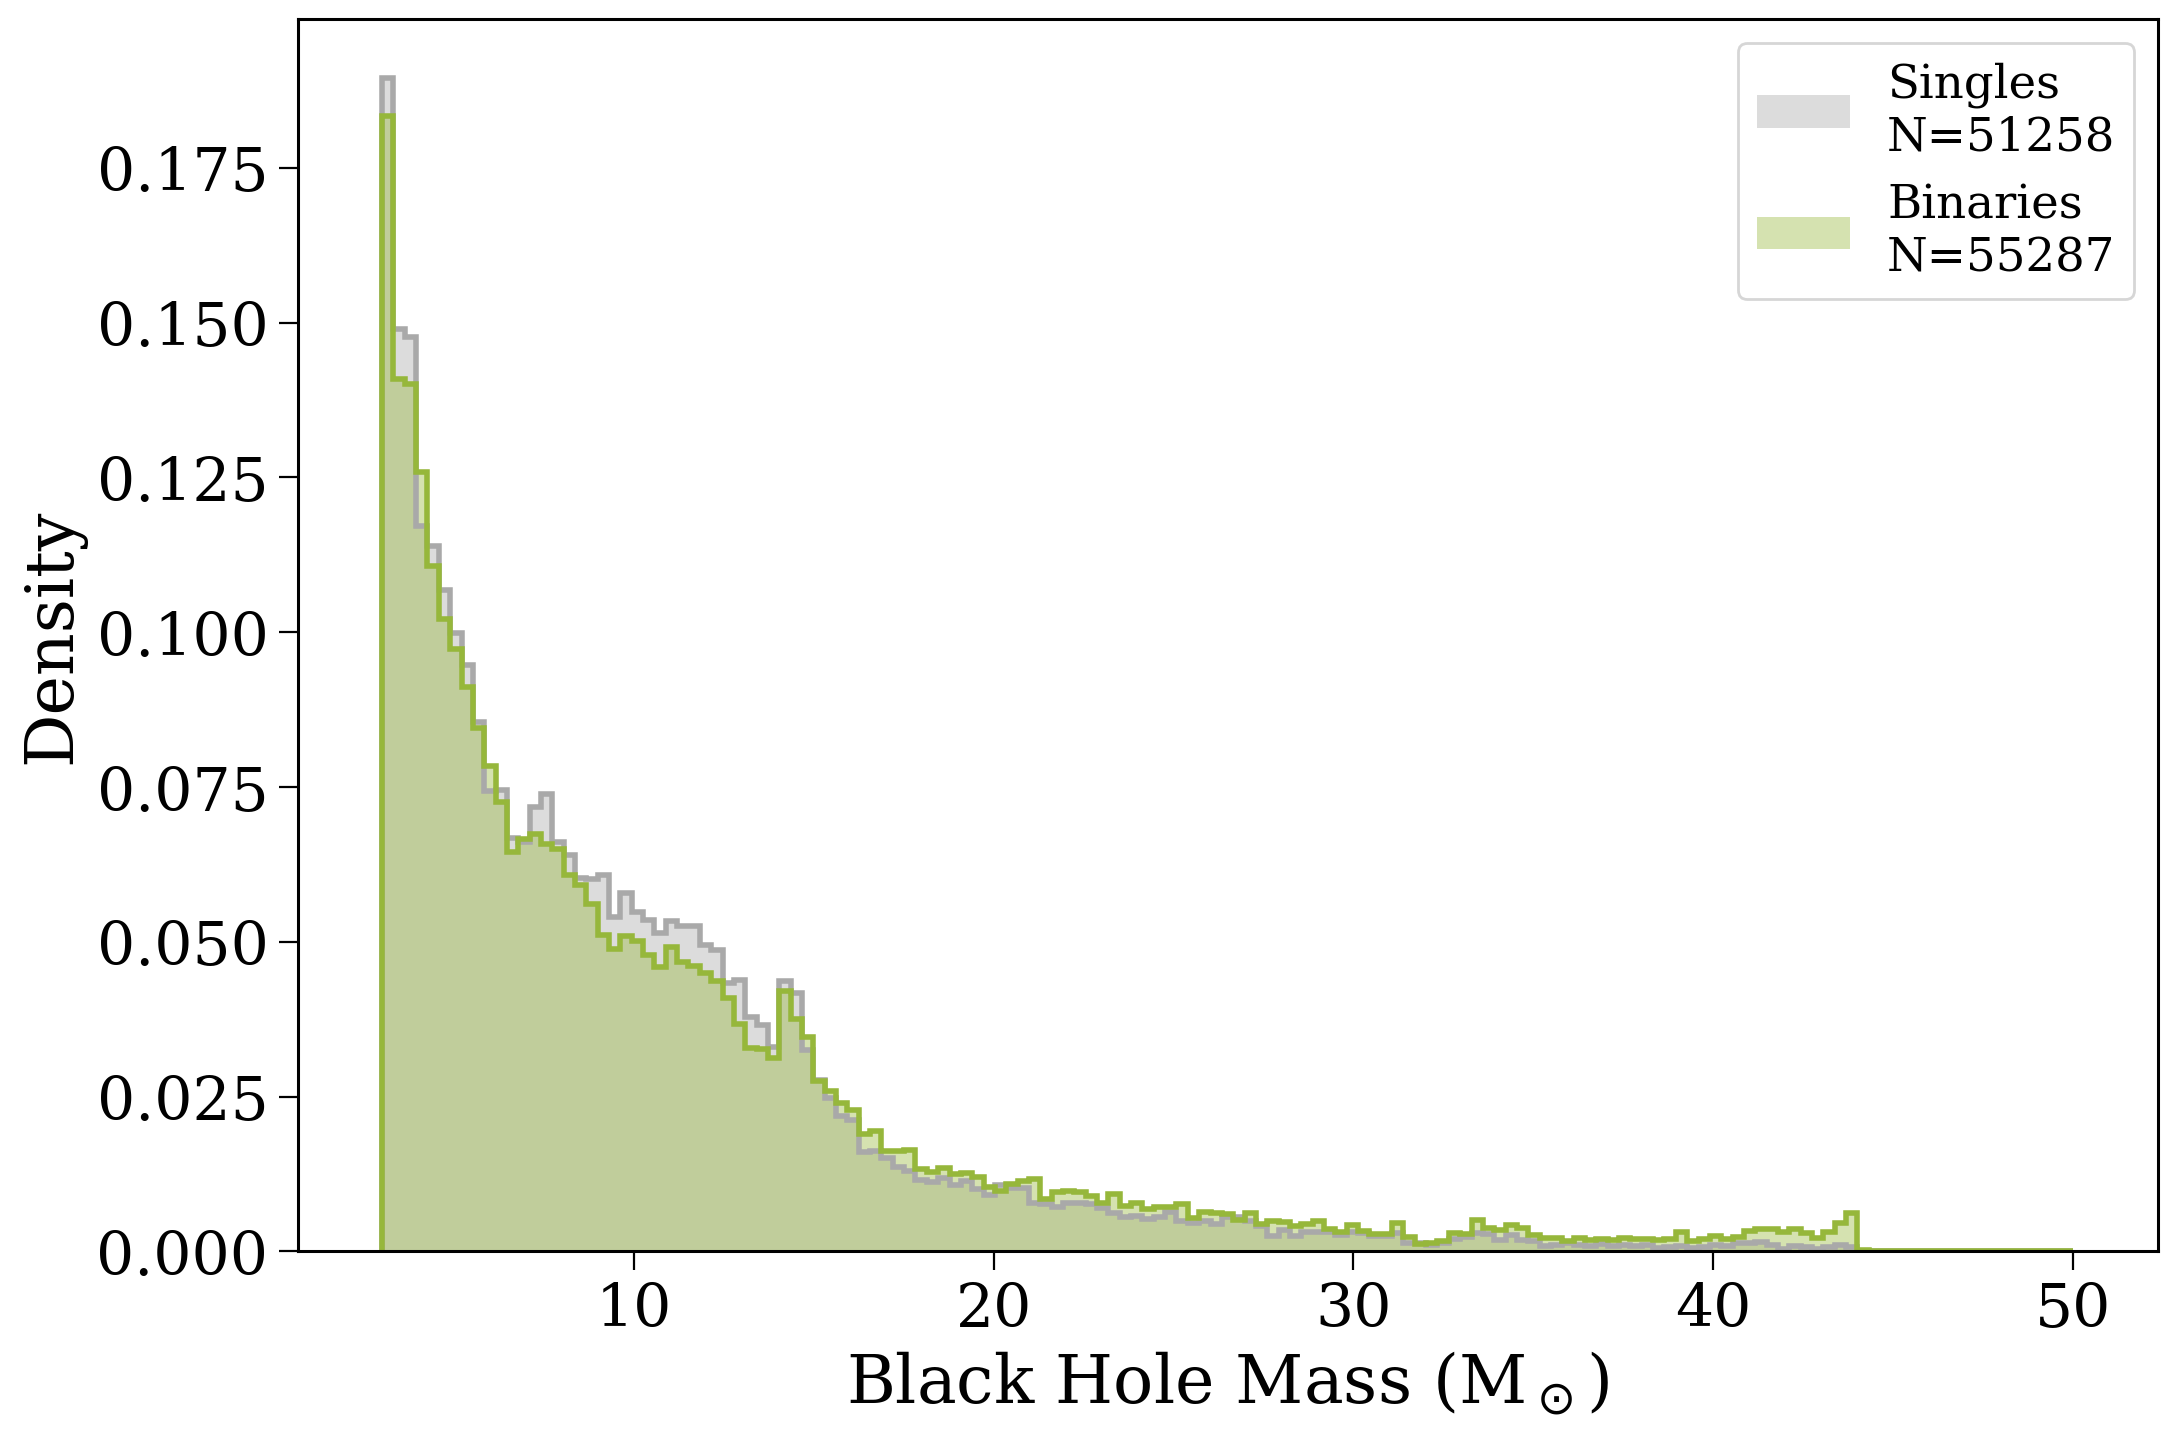

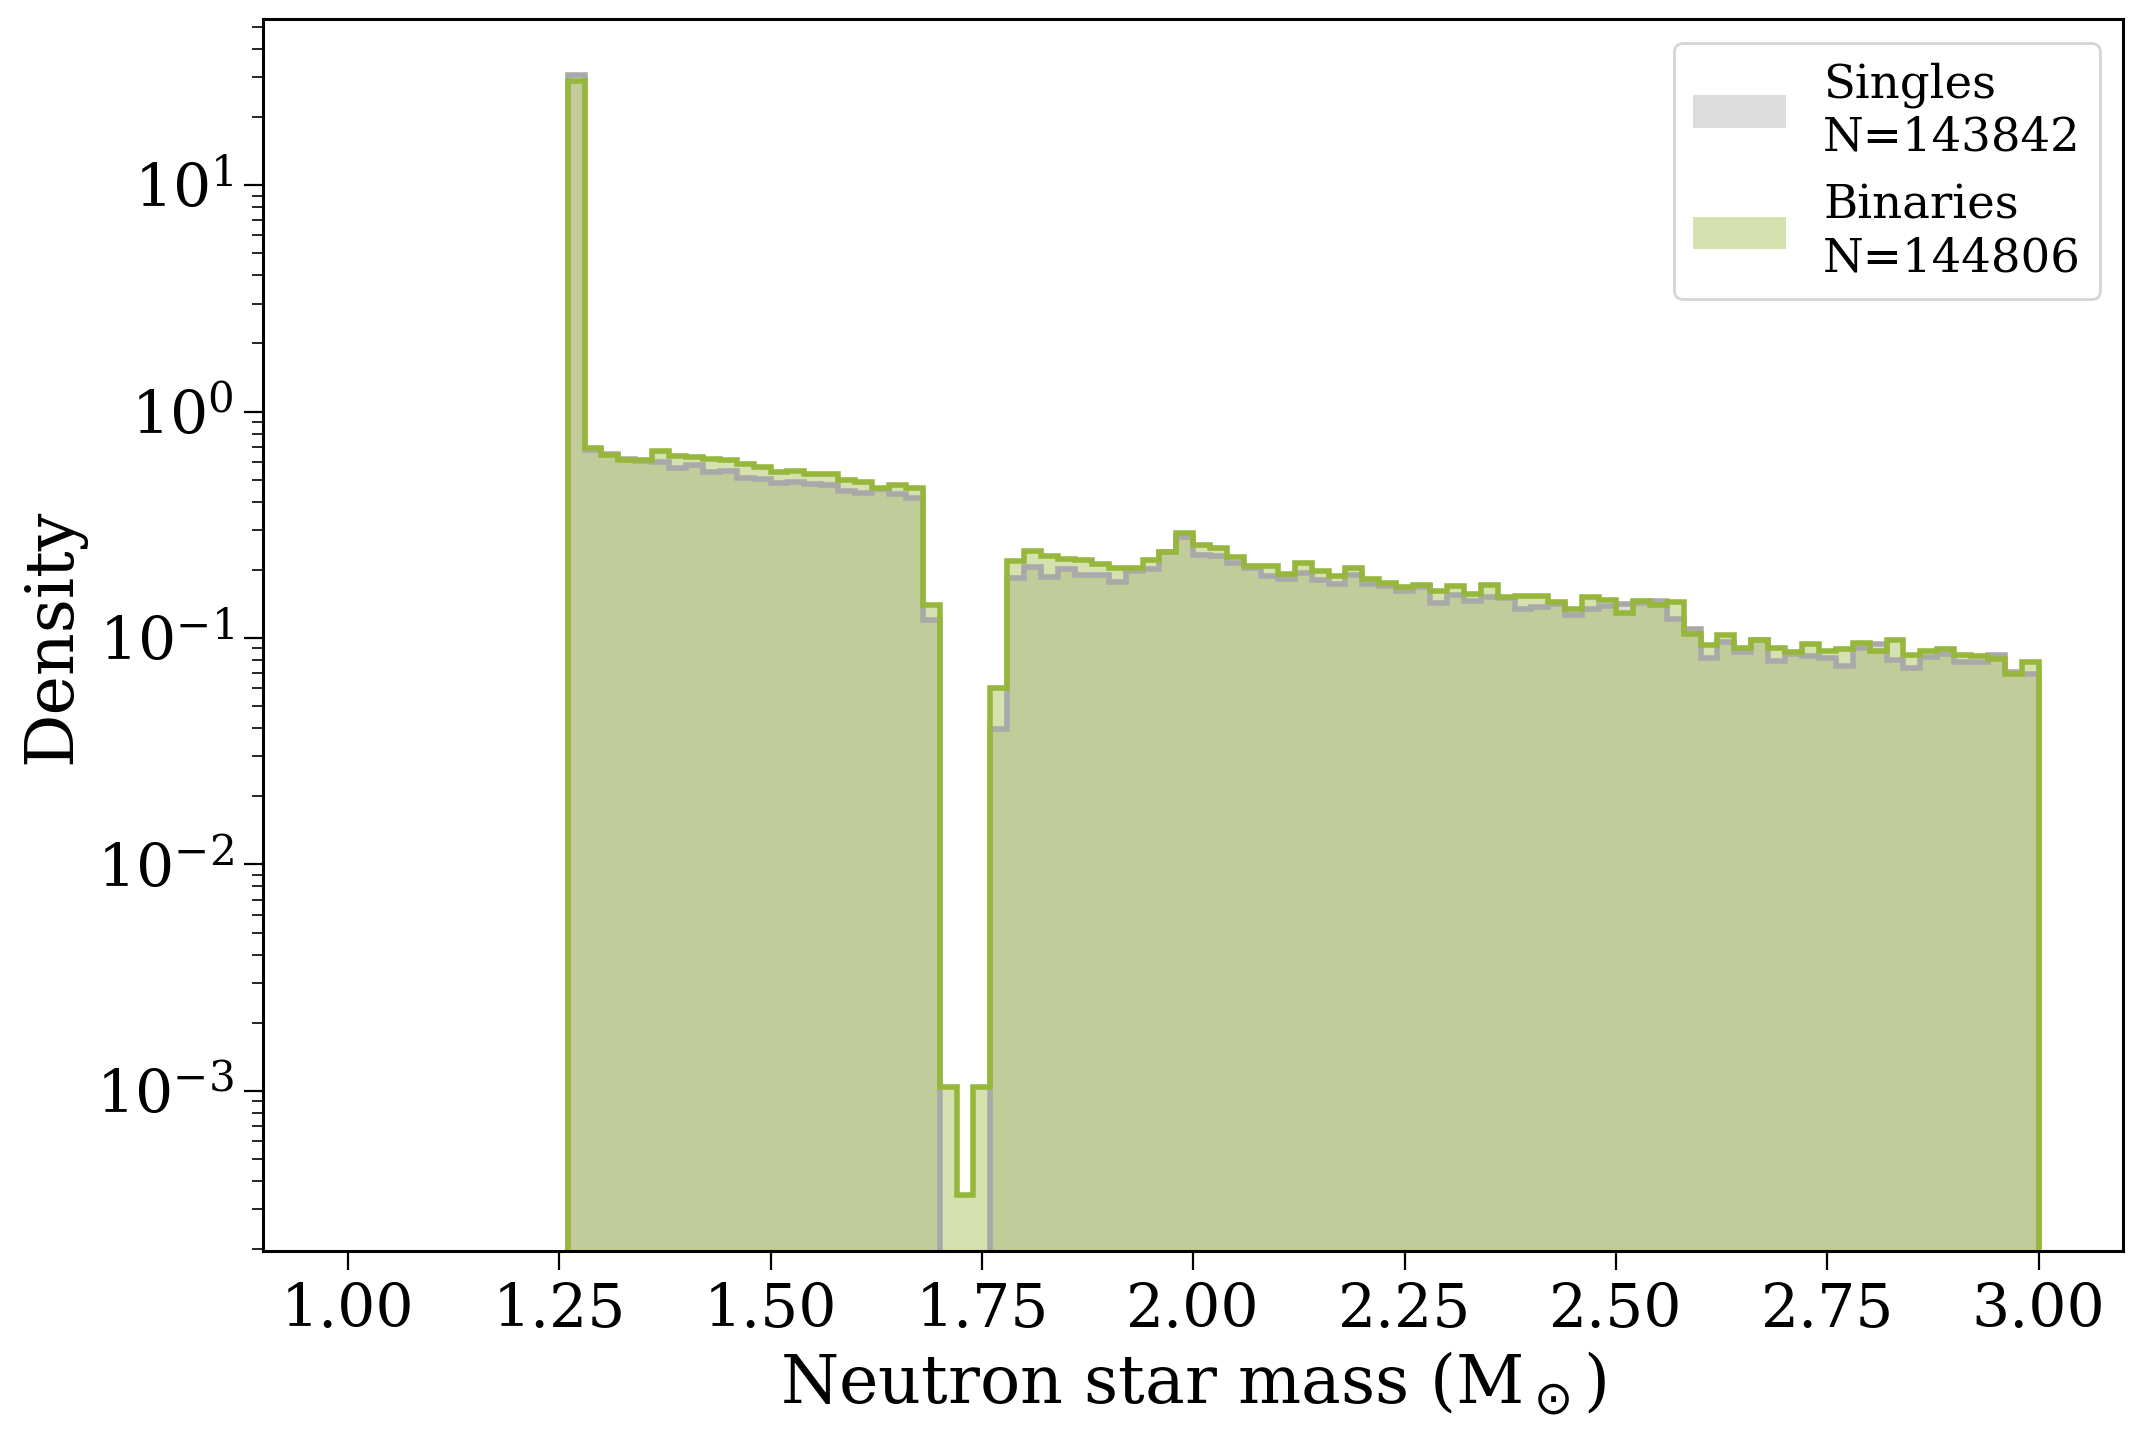

(<Figure size 1200x800 with 1 Axes>,
 <Axes: xlabel='Neutron star mass (M$_\\odot$)', ylabel='Density'>)

In [ ]:
plotting.compare_final_bpp_quantity(
    pops=[singles, binaries],
    quantity="mass",
    kstar=14,
    bins=np.linspace(3, 50, 150),
    xlabel="Black Hole Mass (M$_\odot$)",
    ylabel="Density",
)

plotting.compare_final_bpp_quantity(
    pops=[singles, binaries],
    quantity="mass",
    kstar=13,
    bins=np.linspace(1, 3, 101),
    xlabel="Neutron star mass (M$_\odot$)",
    ylabel="Density",
    yscale="log"
)

# Kinematics

In [12]:
kinematics = helpers.get_kinematics([singles, binaries])

stars = cogsworth.sfh.SandersBinney2015(
    size=200000,
    **{
        "potential": binaries.galactic_potential,
        "time_bins": 5,
        "verbose": True
    }
)

Pre-computing lookback time, guiding radius and frequency interpolations
Initiating sampling procedure
  Sampling 161991 stars from the thin_disc
    Sampling 19485 stars with lookback times between 0.00 Gyr and 2.00 Gyr
    Sampling 24888 stars with lookback times between 2.00 Gyr and 4.00 Gyr
    Sampling 31427 stars with lookback times between 4.00 Gyr and 6.00 Gyr
    Sampling 39047 stars with lookback times between 6.00 Gyr and 8.00 Gyr
    Sampling 47144 stars with lookback times between 8.00 Gyr and 10.00 Gyr
  Sampling 38009 stars from the thick_disc
    Sampling 38009 stars with lookback times between 10.00 Gyr and 12.00 Gyr


## Scale heights

How does one calculate scale height? There's two ways I could see:

- The height at which the maximum decreases by a factor of $e$
- The height where the cumulative distribution reaches 0.5

In [264]:
from scipy.optimize import curve_fit
def exponential(x, a, b):
    return a * np.exp(-b * x)

def estimate_scale_height(z, bins=np.linspace(0, 2, 101),
                          plot=False, fig=None, ax=None, show=True,
                          label="", colour="black",
                          **kwargs):
    """Estimate the scale height of a distribution given z-positions."""
    z = np.abs(z)
    
    # remove units for calculation if they exist
    if hasattr(z, 'unit'):
        z = z.to(u.kpc).value

    hist, bin_edges = np.histogram(z, bins=bins)
    bin_centres = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    scale_height = bin_centres[hist < hist.max() / np.e][0]

    smooth_hist = gaussian_filter(hist, sigma=2)

    p0 = [smooth_hist.max(), 1 / scale_height]
    popt, pcov = curve_fit(exponential, bin_centres, smooth_hist, p0=p0)
    scale_height = 1 / popt[1]

    if plot:

        if fig is None or ax is None:
            fig, ax = plt.subplots()

        ax.plot(bin_centres, hist, label=label, color=colour)
        ax.plot(bin_centres, exponential(bin_centres, *popt), color=colour, ls='--', alpha=0.5)

        ax.axvline(scale_height, color=colour, ls='dotted', alpha=0.5)
        ax.annotate(f"{scale_height * 1000:.0f} pc", xy=(scale_height, smooth_hist.max()), fontsize=0.6*fs,
                    rotation=90, color=colour, ha='center', va='top', bbox=dict(boxstyle="round,pad=0.3", fc="white", ec=colour))
        
        ax.set(
            xlabel="|z| (kpc)",
            ylabel="Count",
        )
        ax.legend(fontsize=0.7*fs)

        if show:
            plt.show()

        return scale_height, fig, ax
    else:
        return scale_height, None, None

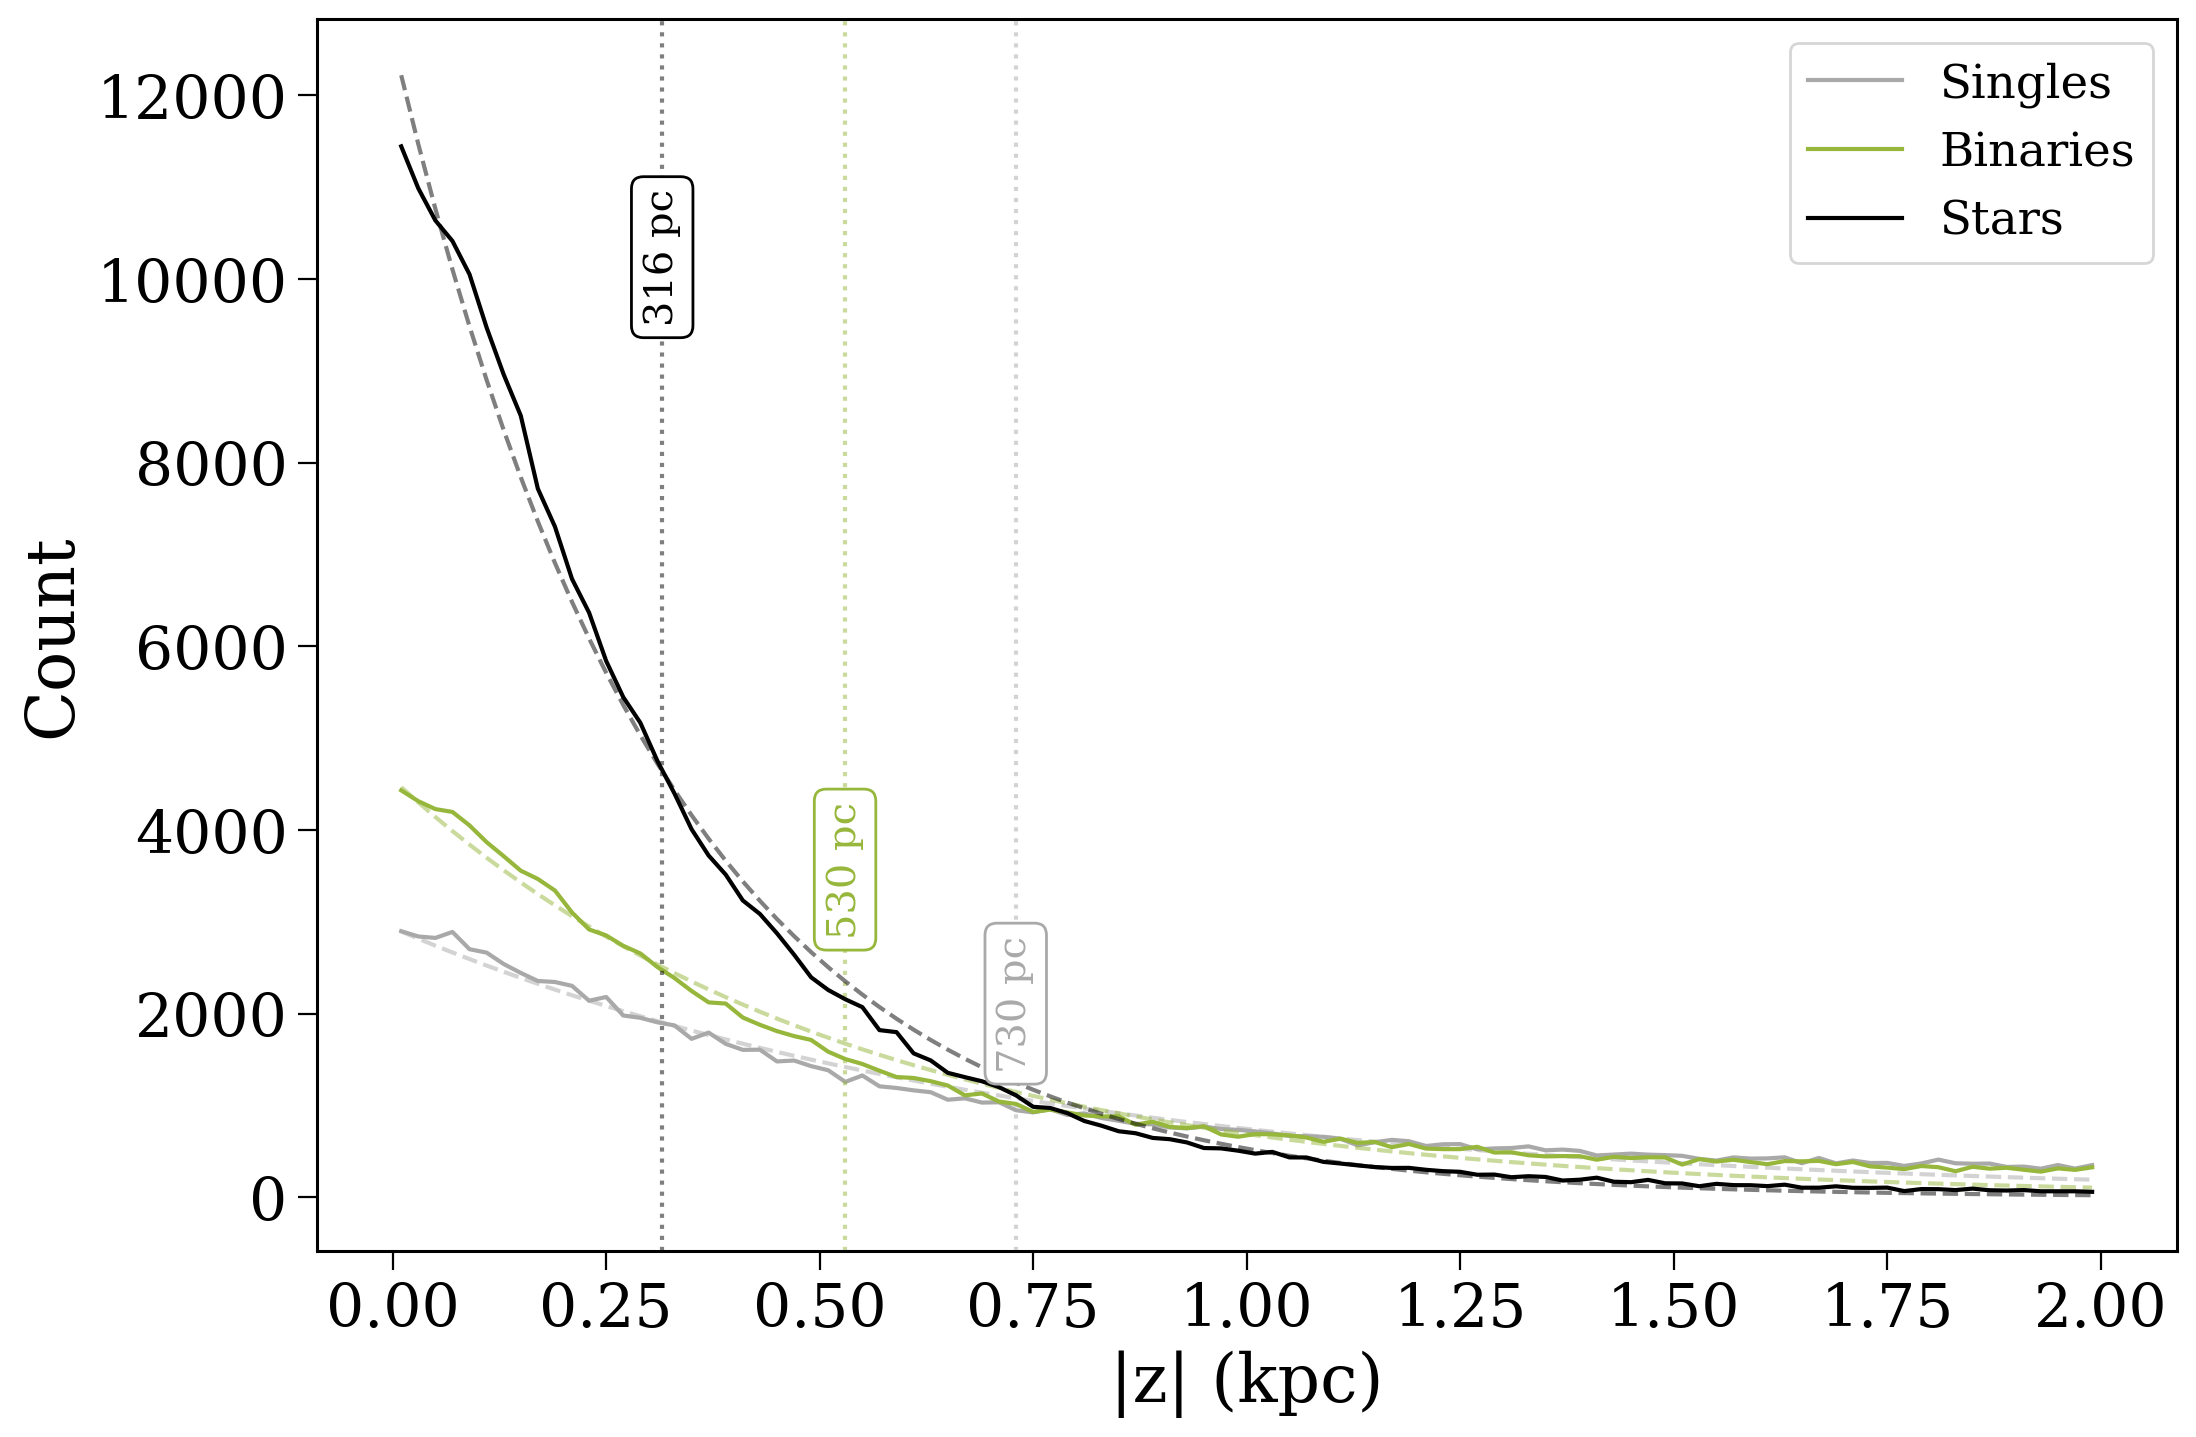

In [268]:
fig, ax = plt.subplots()

for z, label, colour in zip(
    [kinematics["Singles"]["pos"]["CO"][:, 2], kinematics["Binaries"]["pos"]["CO"][:, 2], stars.z],
    ["Singles", "Binaries", "Stars"],
    [singles.colour, binaries.colour, "black"]
):
    scale_height, _, _ = plotting.estimate_scale_height(
        z=z,
        plot=True,
        label=label,
        colour=colour,
        show=False,
        fig=fig,
        ax=ax
    )

plt.show()

## Vertical position histograms

Singles 0.3716892636187916
Binaries 0.46864322436275346
Singles 0.27499423357851305
Binaries 0.3694737368184317


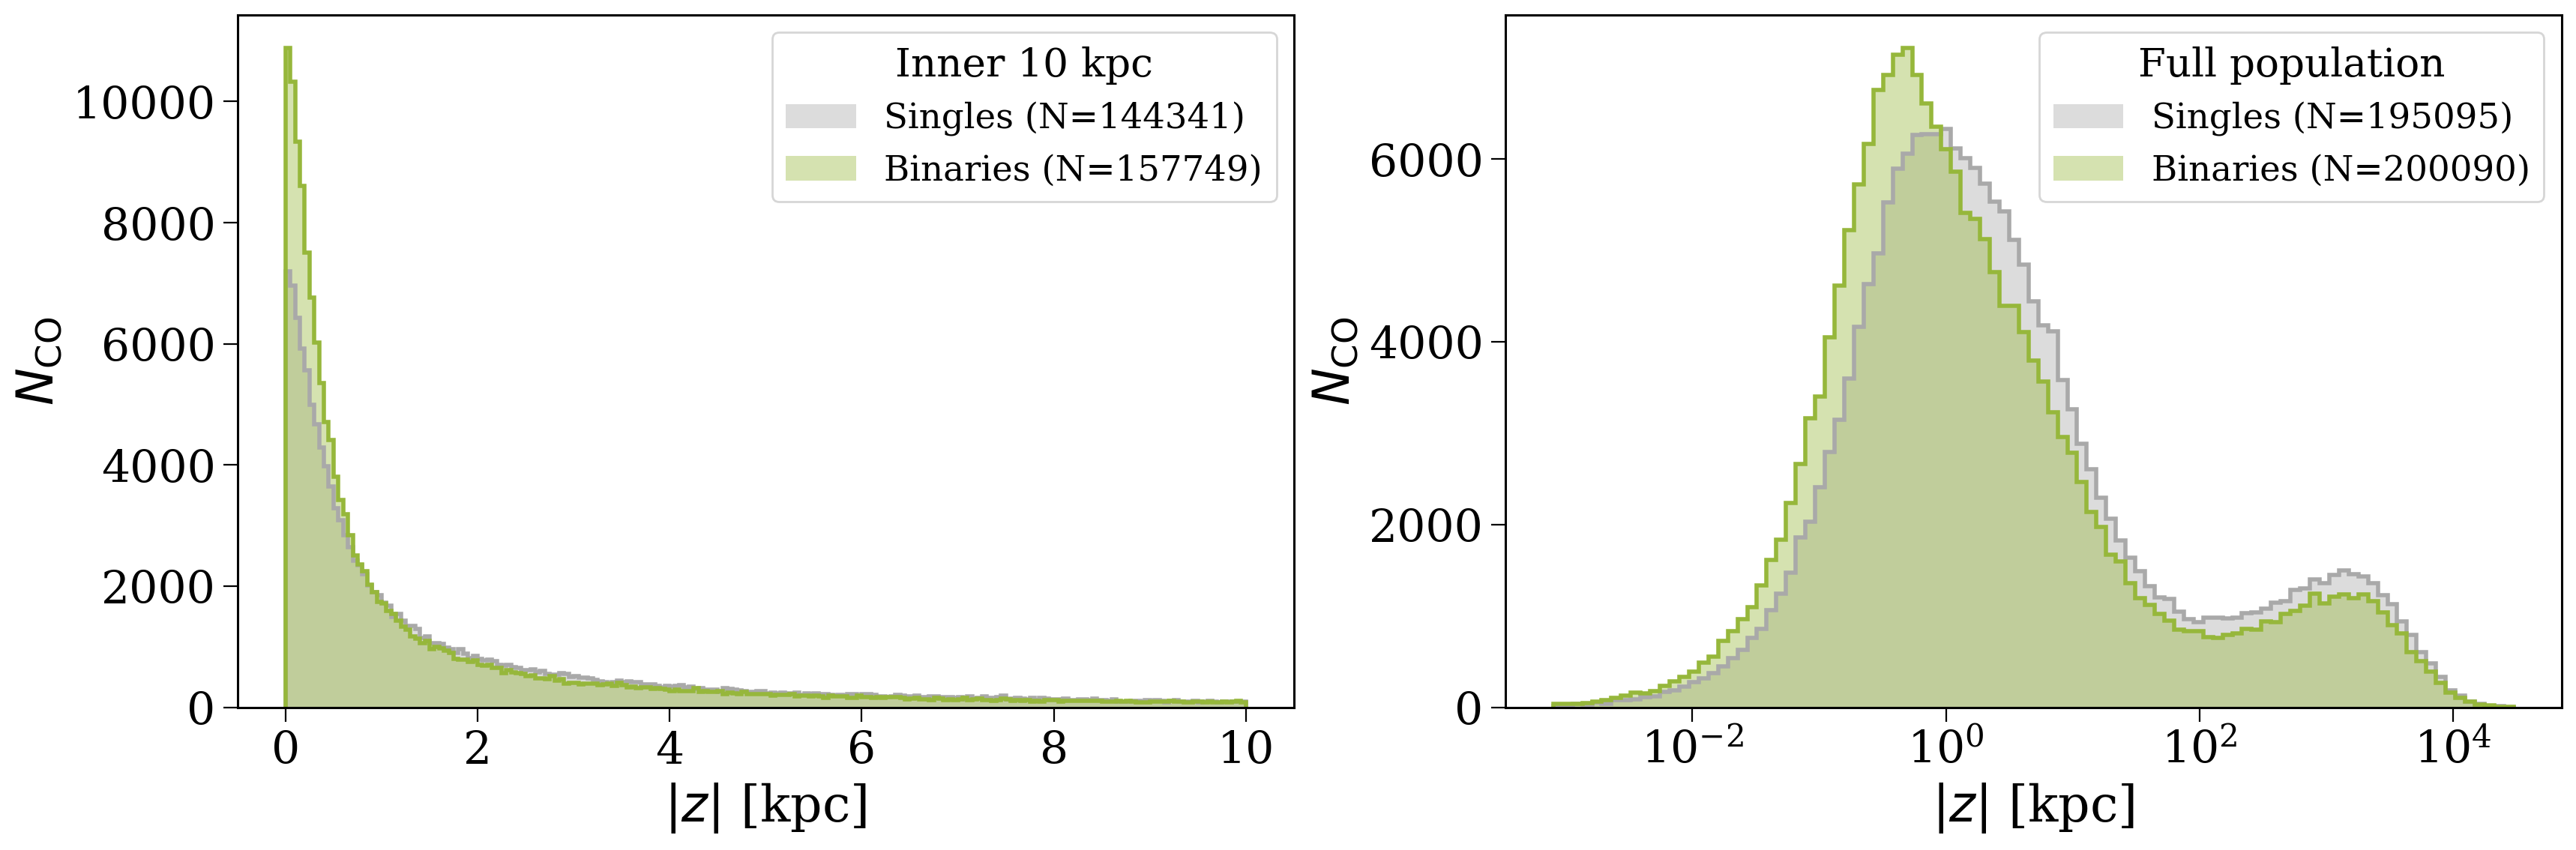

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 10, 201), np.geomspace(8e-4, 3e4, 100)]
labels = ['Inner 10 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    for pop in [singles, binaries]:
        co_pos = kinematics[pop.label]["pos"]["CO"]

        mask = np.abs(co_pos[:, 2].to(u.kpc).value) < bins[-1]

        print(pop.label, (abs(co_pos[:, 2].to(u.kpc).value) < 0.5).sum() / mask.sum())

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value), bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

In [216]:
sweeney = pd.read_hdf("/mnt/ceph/users/twagg/underworld/sweeney_remnants.h5", key="data")

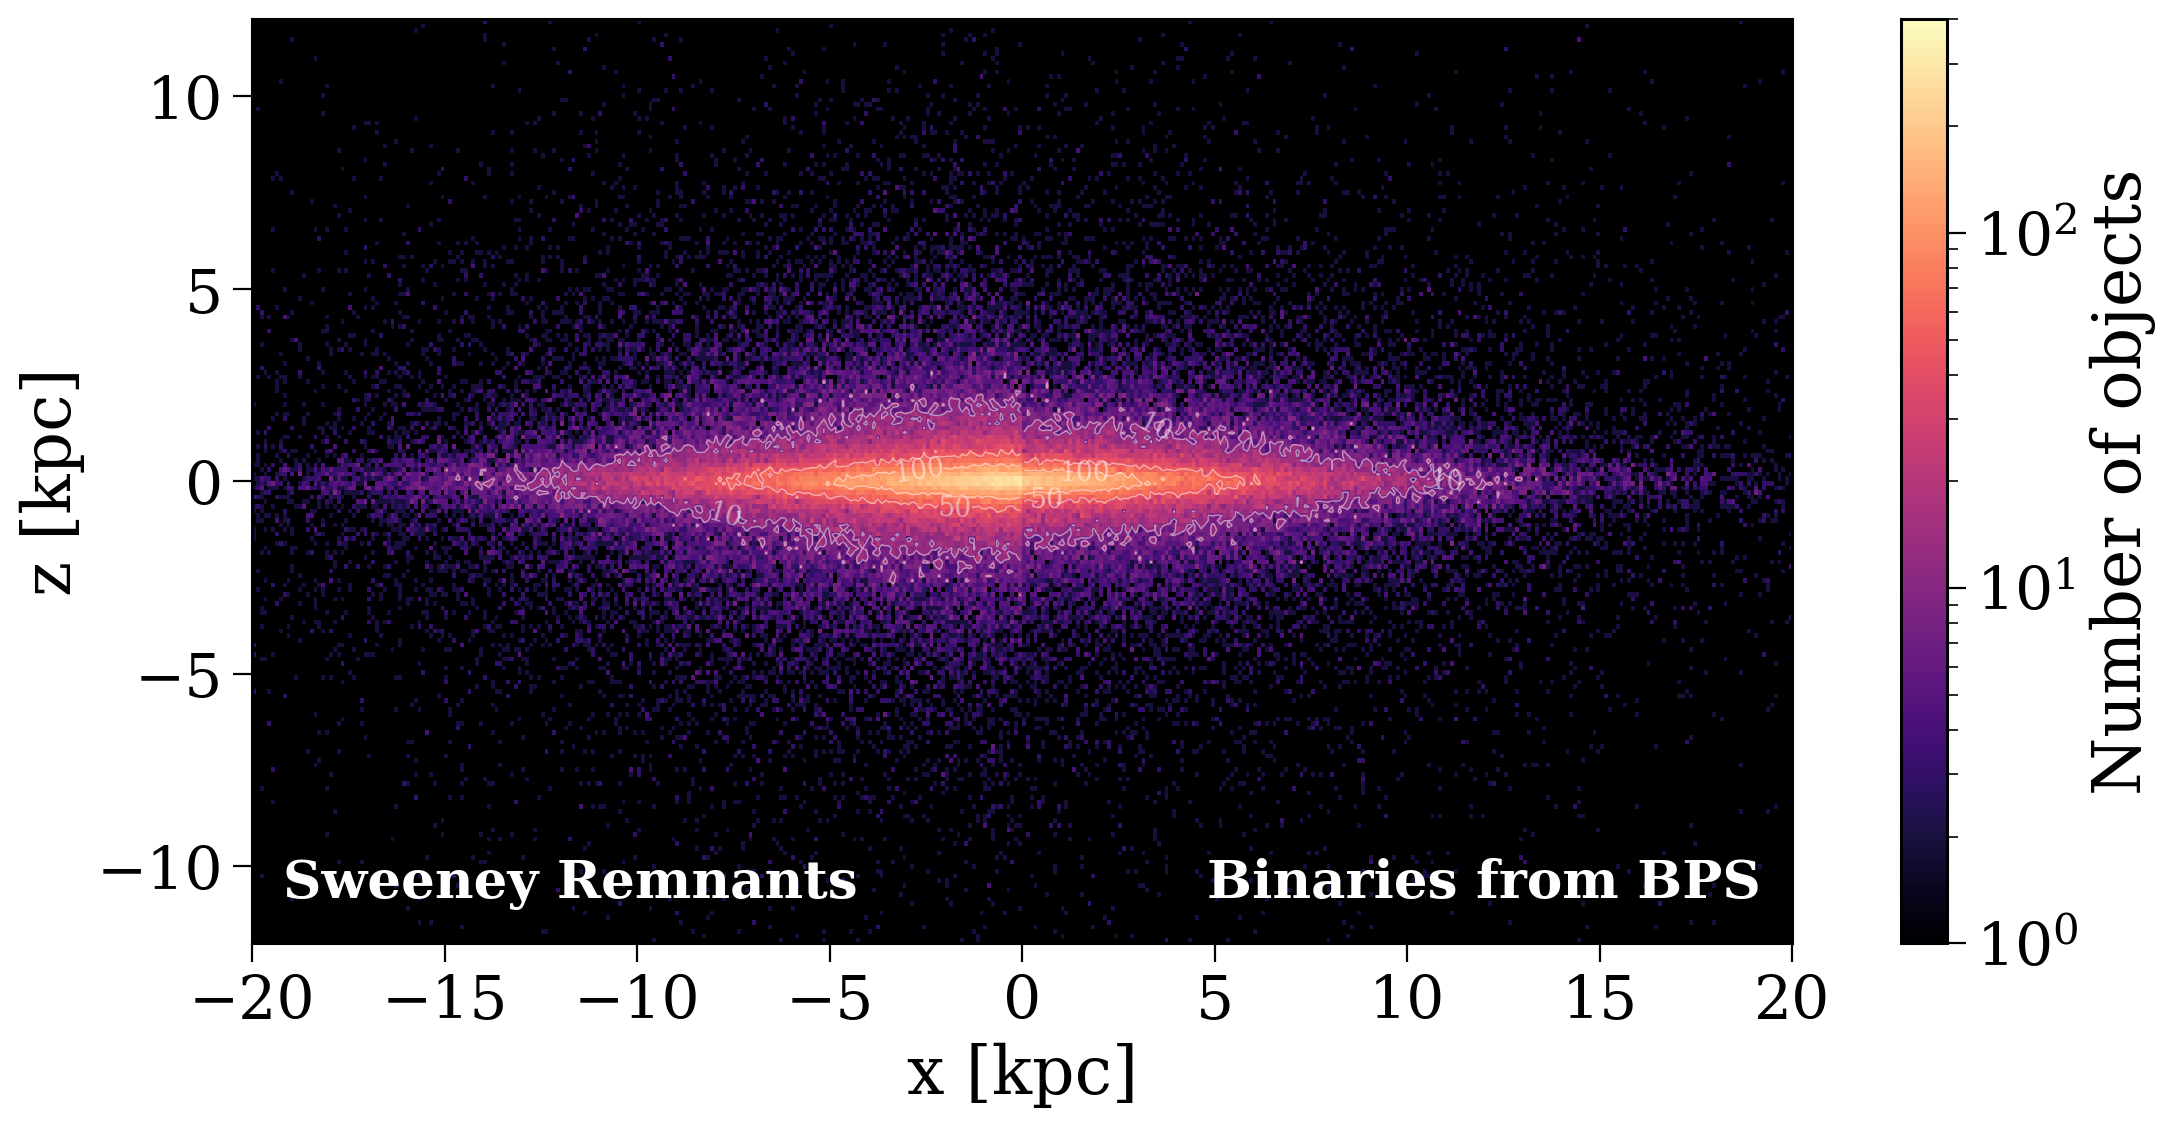

(<Figure size 1400x600 with 2 Axes>,
 <Axes: xlabel='x [kpc]', ylabel='z [kpc]'>)

In [223]:
plotting.plot_side_on_density(
    xs=[
        sweeney["x_final"].values * u.kpc, kinematics["Binaries"]["pos"]["CO"][:, 0]
    ],
    zs=[
        sweeney["z_final"].values * u.kpc, kinematics["Binaries"]["pos"]["CO"][:, 2]
    ],
    labels=["Sweeney Remnants", "Binaries from BPS"],
    apply_smoothing=False,
    contours=[10, 50, 100]
)

In [214]:
x

mass         x          y         z         v_R         v_T  \
0        8.013760 -3.009336   0.886110  0.043278  -16.963575  144.671347   
1       15.511696 -1.484131   3.710584 -0.081100   41.247804  185.488045   
2       24.320418 -3.434587  -0.399961  0.024037   23.117454  262.724695   
3        9.388694  7.057592  -1.356272  0.662394  -40.000330  252.887615   
4       12.748621  4.435115  14.168600  0.901164  -11.556087  206.400247   
...           ...       ...        ...       ...         ...         ...   
186381  21.776008  1.896444   5.592852 -0.455601   37.359499  247.112497   
186382  12.184149 -7.666423   7.164050  0.012626    6.974415  166.407518   
186383   8.708807 -3.512807 -10.056317  0.015020   -7.274341  227.999508   
186384  19.024184  0.483986   2.663671  0.116371  131.585502  233.022516   
186385  13.535472 -8.670584   6.996273  0.357246   -4.808534  214.564395   

              v_z        tau          R         v_x         v_y        kick  \
0      -31.844862  10.106718   3.137084  -24.591524 -143.571650  361.952909   
1      -60.139925   5.106550   3.996383 -187.541109  -30.586410  336.383886   
2       44.411586   2.158396   3.457797    7.426890 -263.635209  750.122078   
3        1.400361   2.355796   7.186729    8.443130  255.892333  542.302380   
4      -16.628810   9.886380  14.846531 -200.427642   50.629690  612.952794   
...           ...        ...        ...         ...         ...         ...   
186381 -12.301187  11.157172   5.905632 -222.027607  114.734738  558.064186   
186382 -11.139561   7.826582  10.492743 -118.712579 -116.822207  327.077141   
186383  26.358654   6.245419  10.652198  217.644157  -68.320660  290.021392   
186384  35.147453  11.135118   2.707284 -205.744865  171.123605  735.128497   
186385  13.472782   7.264943  11.141224 -130.996220 -170.002917  448.819217   

            kick_x      kick_y      kick_z      x_final      y_final  \
0      -320.811513  -47.659445 -160.681233    -1.405896    -5.017534   
1        -0.928030  -94.671575 -322.785611    11.528315    10.764436   
2      -417.024633  623.234101   18.784119    -7.344862  -106.522199   
3       433.891832 -203.702428  253.643589   179.656763    47.649116   
4        76.326839 -606.425472  -46.189699 -1269.941103 -2886.749728   
...            ...         ...         ...          ...          ...   
186381   81.948432  538.840697  119.878242 -1167.557804  3932.742404   
186382   -7.355004  -13.173337  326.728975    -5.509917    -0.230154   
186383  281.553361  -40.892861   56.283982   889.688934   225.983467   
186384  168.620761 -524.383781 -486.829125     0.732583   -41.638833   
186385 -387.875661 -214.799221   69.659574 -2093.731101 -2191.147557   

           z_final   v_x_final   v_y_final   v_z_final  
0        -0.103079  244.977509  247.272341  155.620213  
1       -23.673989  -66.216526   14.958497   36.795330  
2        -4.237081  -15.419507  -33.169176   -2.701773  
3       136.051923  -31.106082   -2.860541  -16.053993  
4       399.176200 -117.825509 -267.277019   37.069111  
...            ...         ...         ...         ...  
186381  787.116854  -98.297854  329.368899   66.137912  
186382    9.113034    3.535590 -344.640728   66.690749  
186383  100.642856   79.088810   26.162513    8.528553  
186384  -32.434126   -4.800976  174.479103  163.894910  
186385  357.013609 -268.241163 -284.049177   45.956836  

[186386 rows x 21 columns]

In [152]:
w0s.vel.d_xyz

<Quantity [[ 141.0179886 , -177.96095013, -508.58601634],
           [ -30.78003503, -243.20529308, -156.66664099],
           [-231.14780777, -276.38041683, -134.13125403],
           ...,
           [ 864.03102162,  104.66173625, -211.40056658],
           [ 380.6996055 , -619.43145118,   62.17062714],
           [-168.60836249,   84.39219997,  -69.66034194]] km / s>

In [ ]:
maxwell(scale=56).rvs(size=)

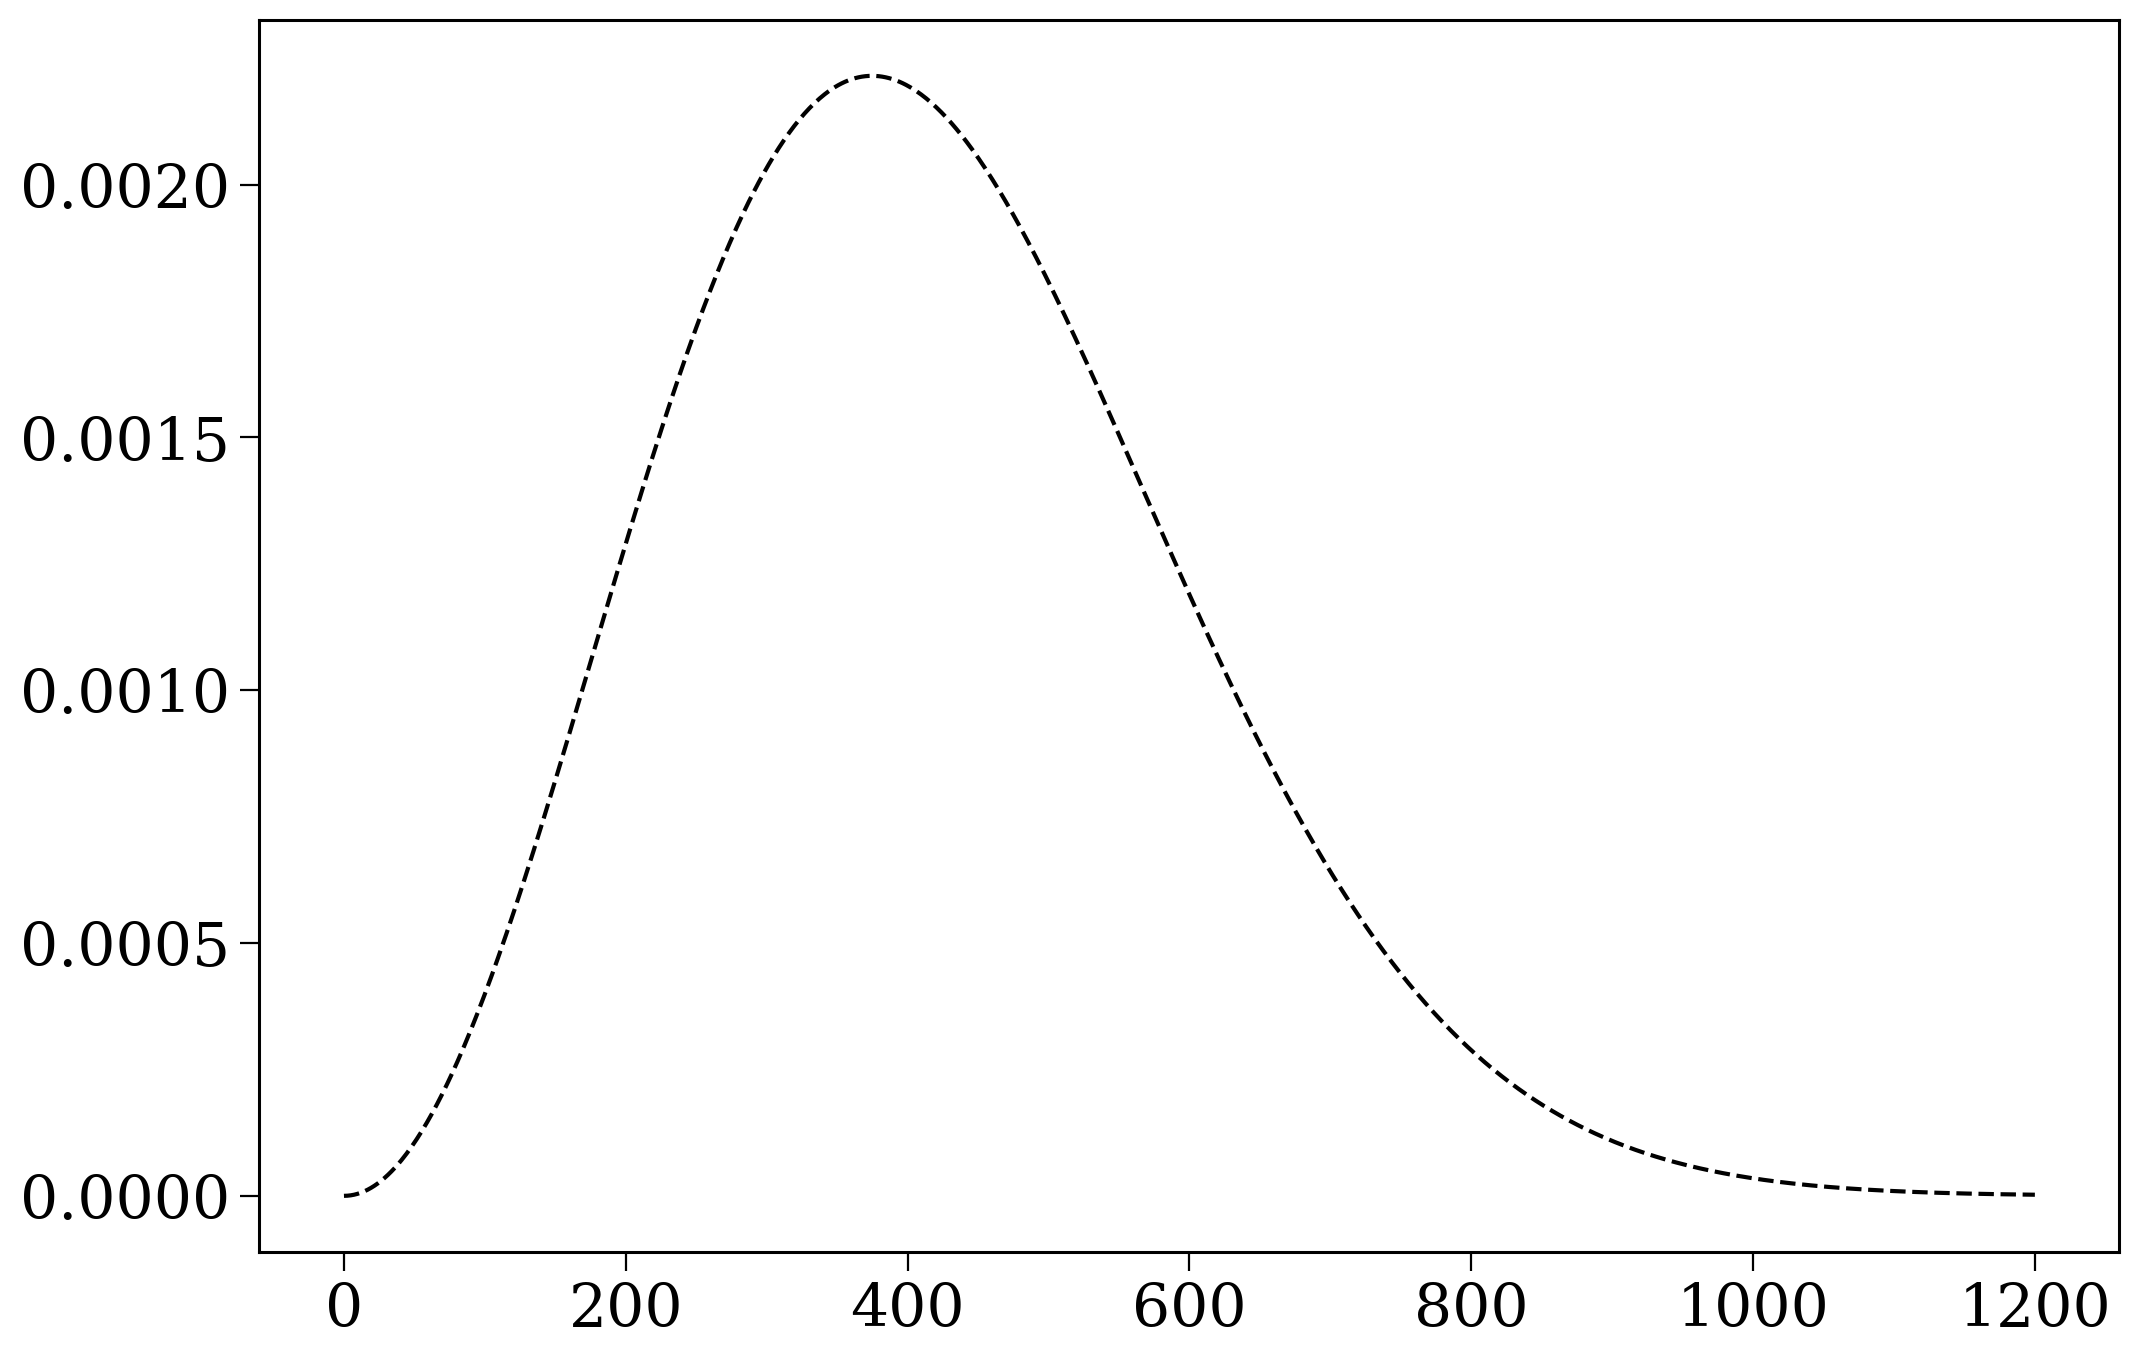

In [ ]:


x_range = np.linspace(0, 1200, 1000)
fig, ax = plt.subplots()
ax.plot(x_range, maxwell.pdf(x_range, scale=265), label="Maxwellian (σ=190 km/s)", color="black", ls='--')
plt.show()

In [111]:
pop

mass         x          y         z         v_R         v_T  \
0        8.013760 -3.009336   0.886110  0.043278  -16.963575  144.671347   
2       15.511696 -1.484131   3.710584 -0.081100   41.247804  185.488045   
6       24.320418 -3.434587  -0.399961  0.024037   23.117454  262.724695   
7        9.388694  7.057592  -1.356272  0.662394  -40.000330  252.887615   
9       12.748621  4.435115  14.168600  0.901164  -11.556087  206.400247   
...           ...       ...        ...       ...         ...         ...   
634378  21.776008  1.896444   5.592852 -0.455601   37.359499  247.112497   
634380  12.184149 -7.666423   7.164050  0.012626    6.974415  166.407518   
634394   8.708807 -3.512807 -10.056317  0.015020   -7.274341  227.999508   
634398  19.024184  0.483986   2.663671  0.116371  131.585502  233.022516   
634402  13.535472 -8.670584   6.996273  0.357246   -4.808534  214.564395   

              v_z        tau  
0      -31.844862  10.106718  
2      -60.139925   5.106550  
6       44.411586   2.158396  
7        1.400361   2.355796  
9      -16.628810   9.886380  
...           ...        ...  
634378 -12.301187  11.157172  
634380 -11.139561   7.826582  
634394  26.358654   6.245419  
634398  35.147453  11.135118  
634402  13.472782   7.264943  

[186386 rows x 8 columns]

Singles 0.00827459393196445
Binaries 0.007552958080111838
Singles 0.0059508554675086365
Binaries 0.005832404579961917


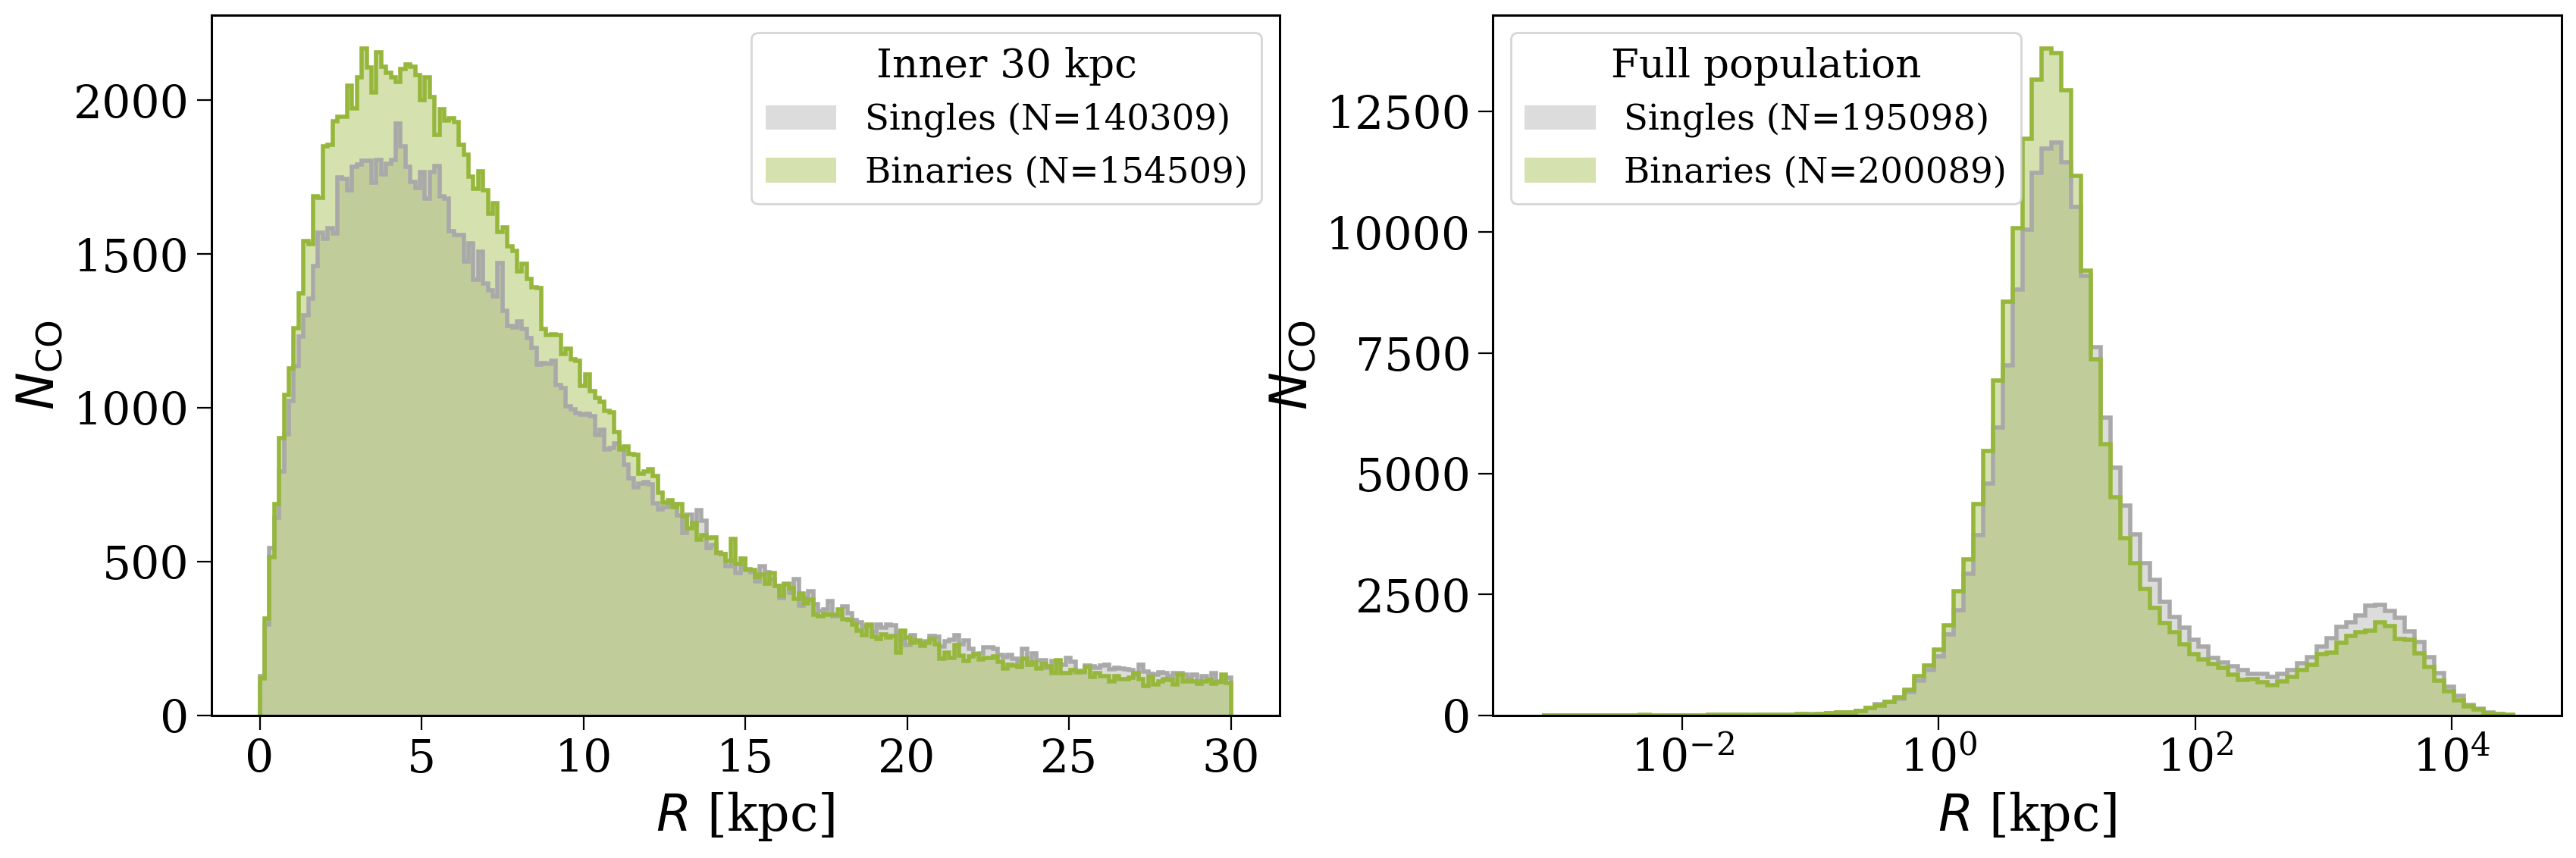

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 30, 201), np.geomspace(8e-4, 3e4, 100)]
labels = ['Inner 30 kpc', 'Full population']

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    for pop in [singles, binaries]:
        co_pos = kinematics[pop.label]["pos"]["CO"]
        r = np.sqrt(co_pos[:, 0]**2 + co_pos[:, 1]**2).to(u.kpc).value

        mask = r < bins[-1]

        print(pop.label, (r < 0.5).sum() / mask.sum())

        ax.hist(r, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(r, bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$R$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

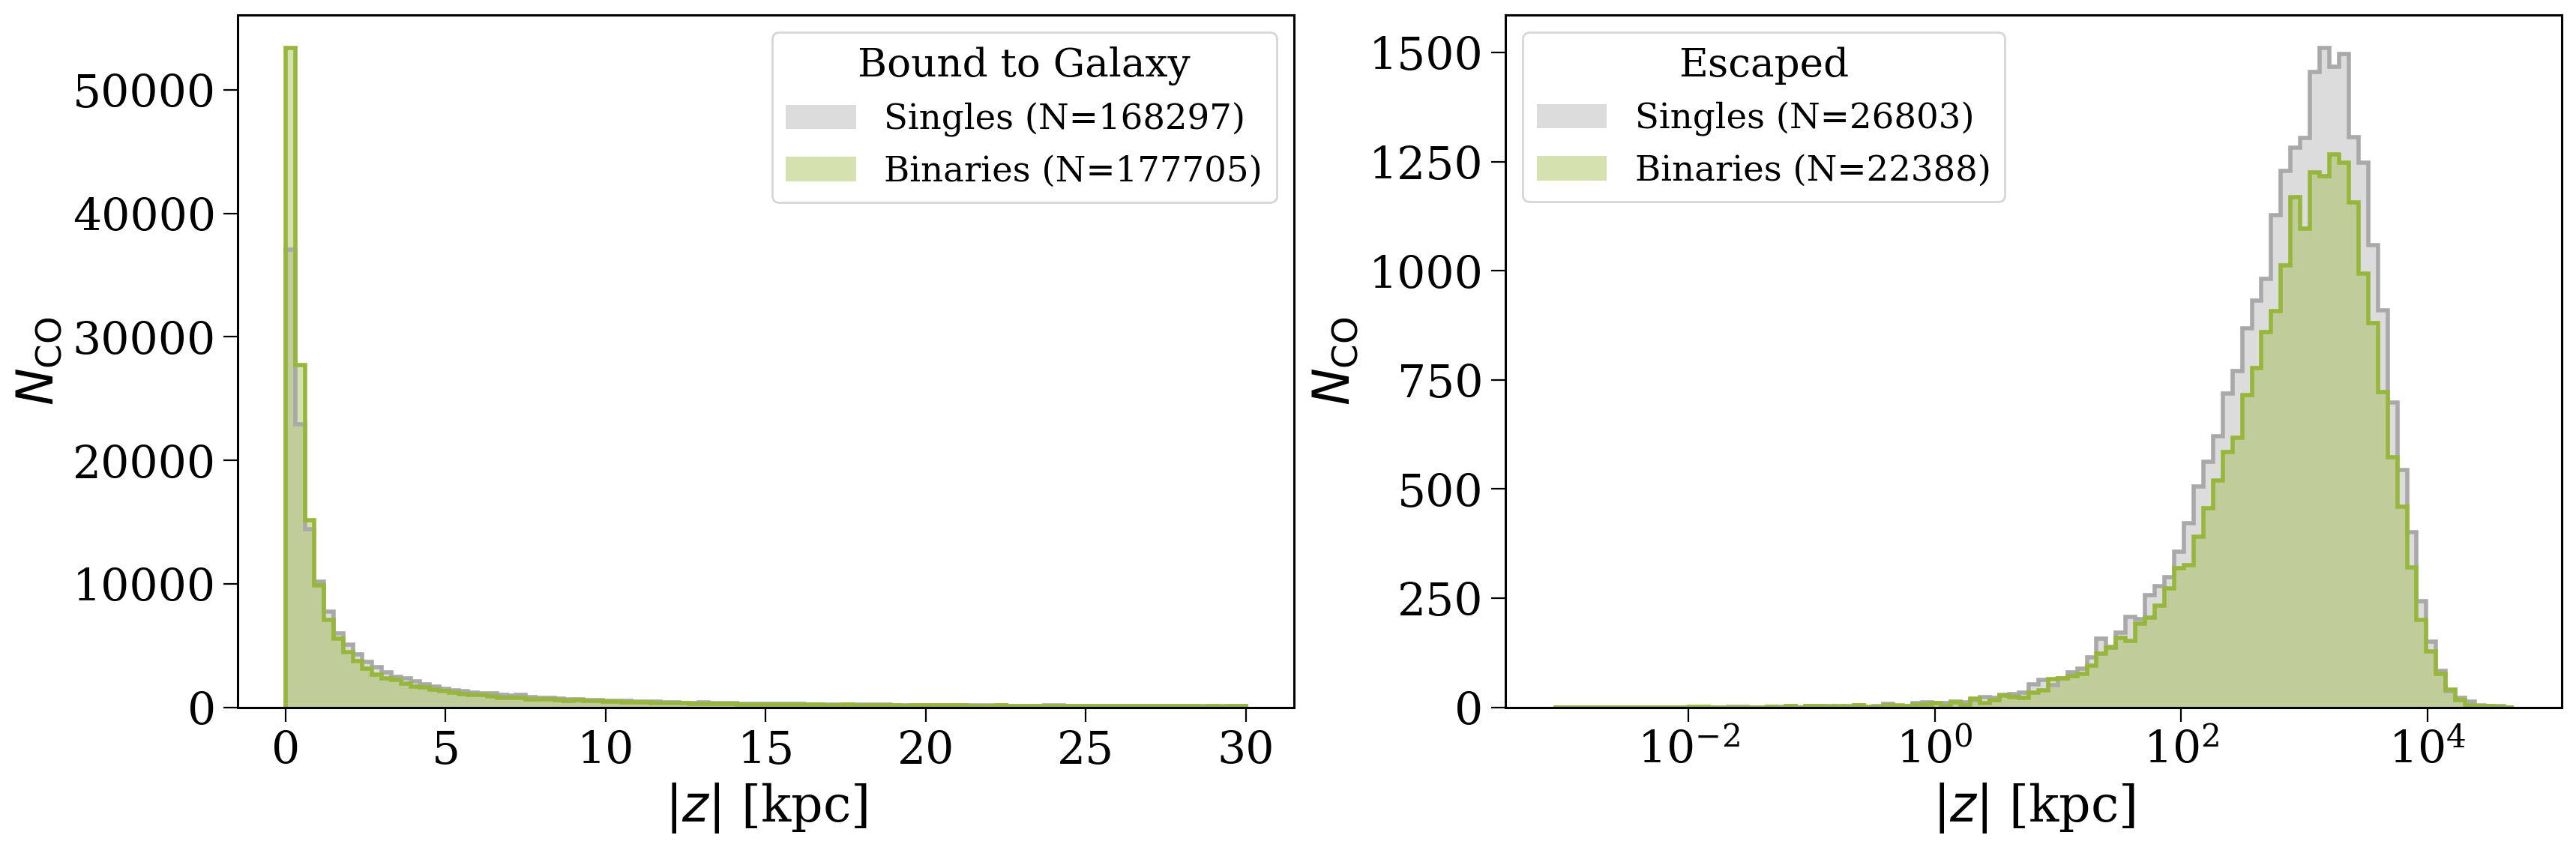

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

scales = ['linear', 'log']
bin_list = [np.linspace(0, 30, 101), np.geomspace(8e-4, 5e4, 100)]
labels = ['Bound to Galaxy', "Escaped"]

for ax, scale, bins, label in zip(axes, scales, bin_list, labels):
    for pop in [singles, binaries]:
        co_pos = kinematics[pop.label]["pos"]["CO"]
        co_vel = kinematics[pop.label]["vel"]["CO"]

        co_V = np.linalg.norm(co_vel.to(u.km/u.s).value, axis=1)

        mask = co_V >= np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s).value
        mask = mask if label == "Escaped" else ~mask

        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(np.abs(co_pos[:, 2].to(u.kpc).value)[mask], bins=bins, alpha=0.4, color=pop.colour,
                label=f'{pop.label} (N={len(co_pos[mask])})')

    ax.set(
        xscale=scale,
        xlabel=r'$|z|$ [kpc]',
        ylabel=r'$N_{\rm CO}$',
    )
    ax.legend(title=label)
plt.show()

## Density distributions

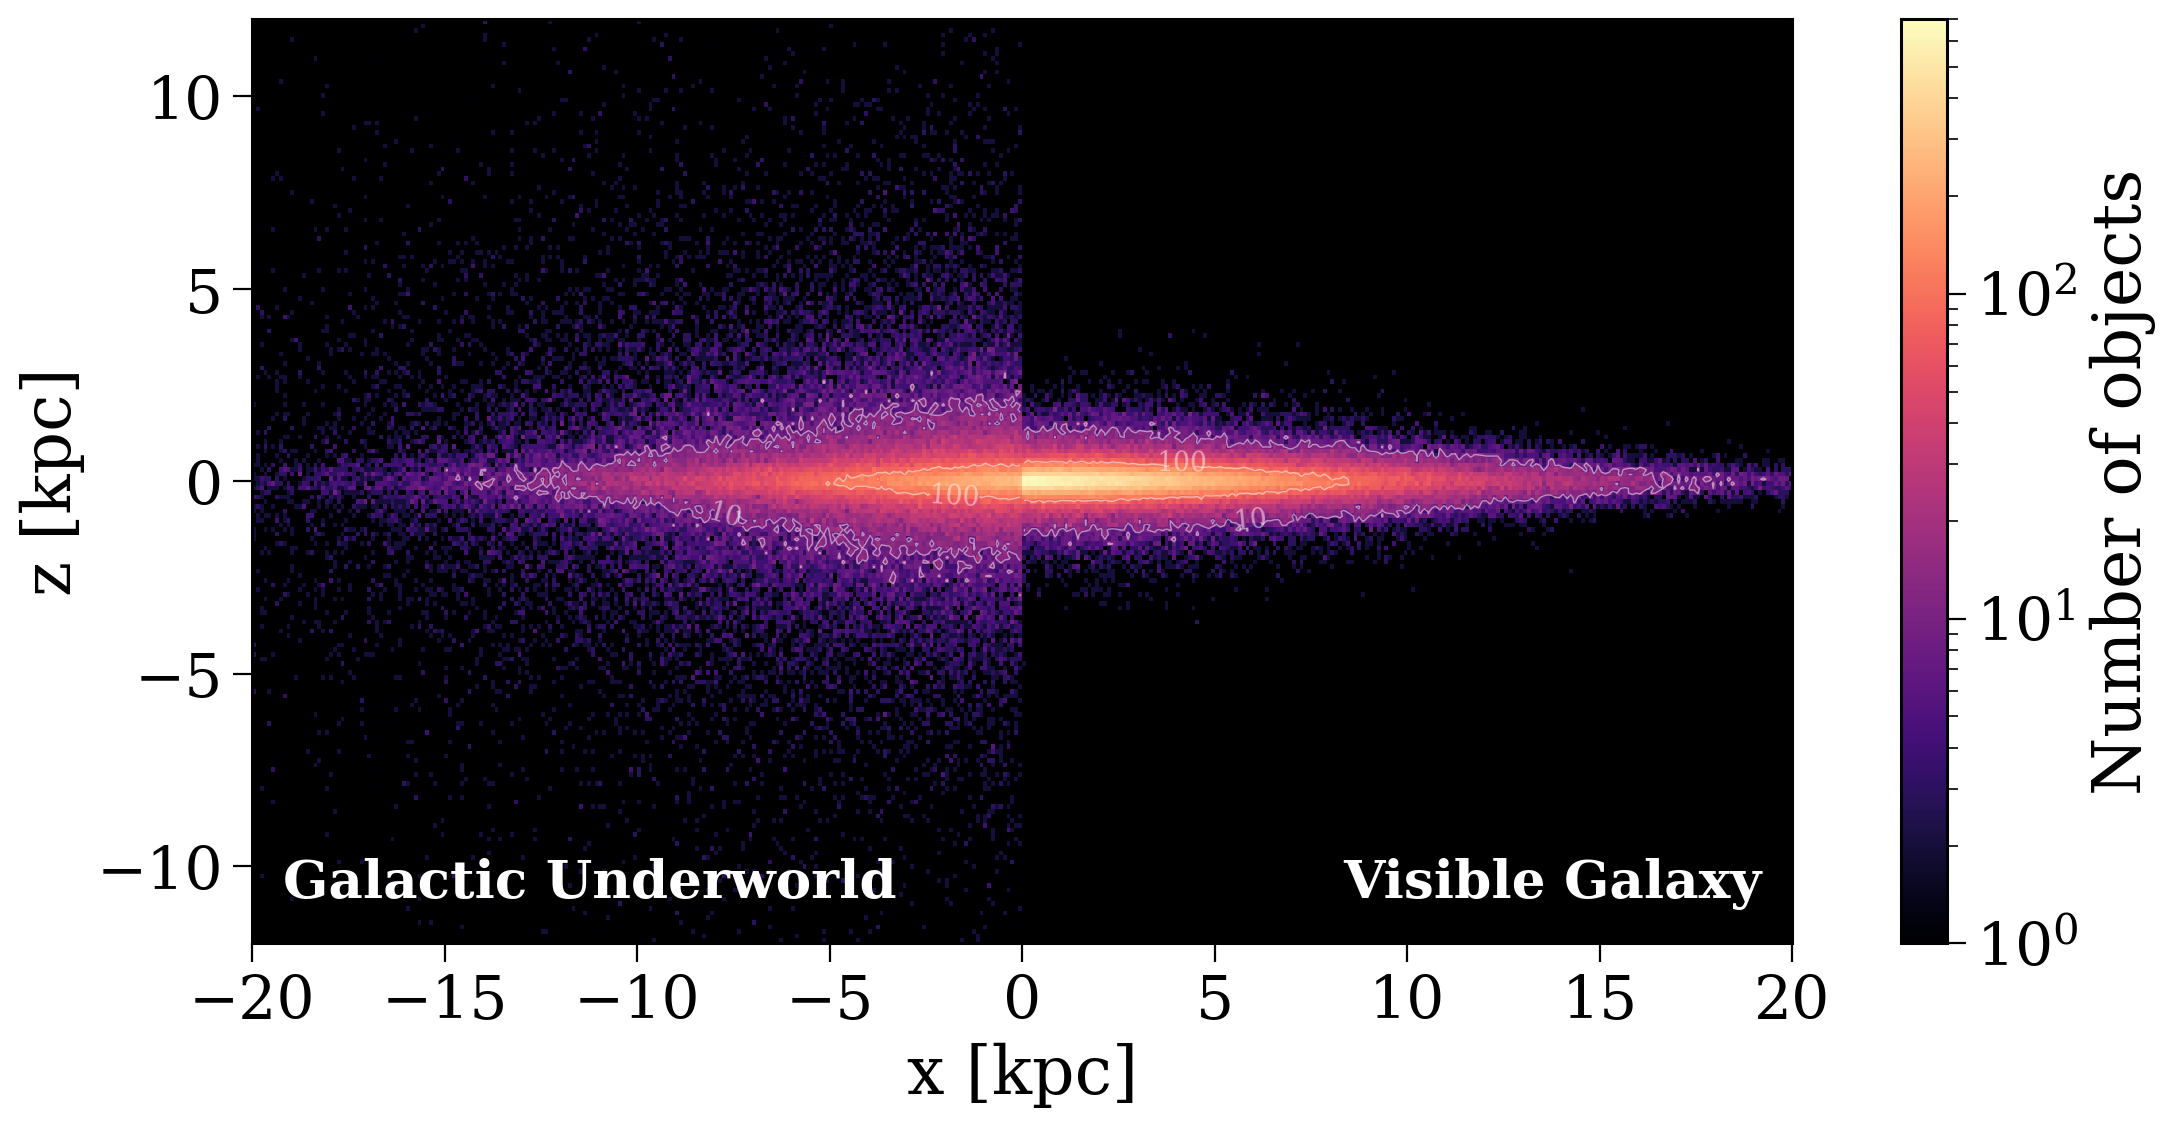

(<Figure size 1400x600 with 2 Axes>,
 <Axes: xlabel='x [kpc]', ylabel='z [kpc]'>)

In [ ]:
reload(plotting)
plotting.plot_side_on_density(
    xs=[stars.x, kinematics["Binaries"]["pos"]["CO"][:, 0]],
    zs=[stars.z, kinematics["Binaries"]["pos"]["CO"][:, 2]],
    labels=["Galactic Underworld", "Visible Galaxy"],
    xlim=20,
    zlim=12,
    n_bins=200,
    sigma=1.0,
    contours=[10, 100],
    apply_smoothing=False,
)

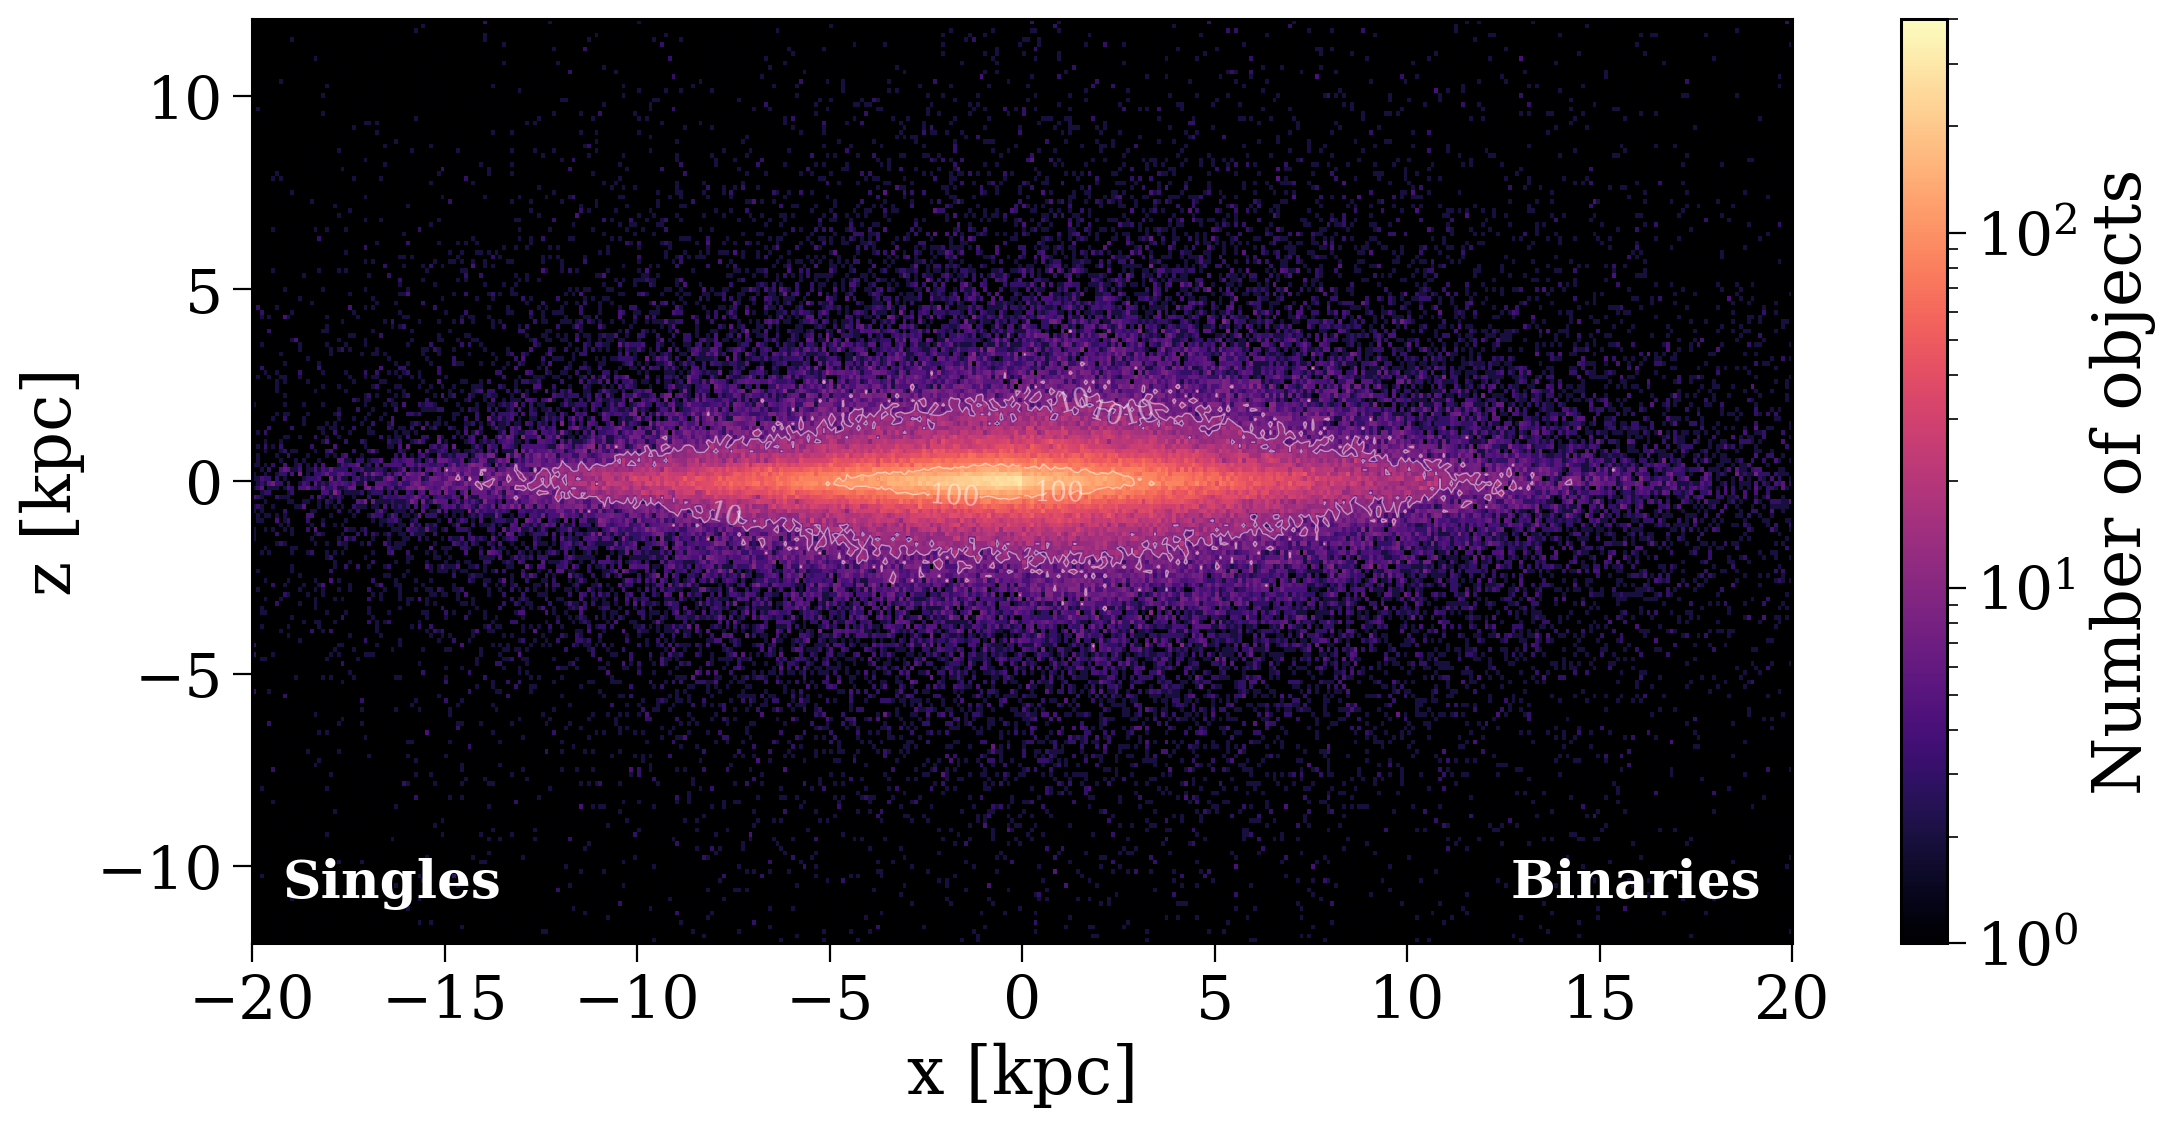

(<Figure size 1400x600 with 2 Axes>,
 <Axes: xlabel='x [kpc]', ylabel='z [kpc]'>)

In [ ]:
reload(plotting)
plotting.plot_side_on_density(
    xs=[kinematics["Singles"]["pos"]["CO"][:, 0], kinematics["Binaries"]["pos"]["CO"][:, 0]],
    zs=[kinematics["Singles"]["pos"]["CO"][:, 2], kinematics["Binaries"]["pos"]["CO"][:, 2]],
    labels=["Singles", "Binaries"],
    xlim=20,
    zlim=12,
    n_bins=200,
    sigma=1.0,
    contours=[10, 100],
    apply_smoothing=False,
)

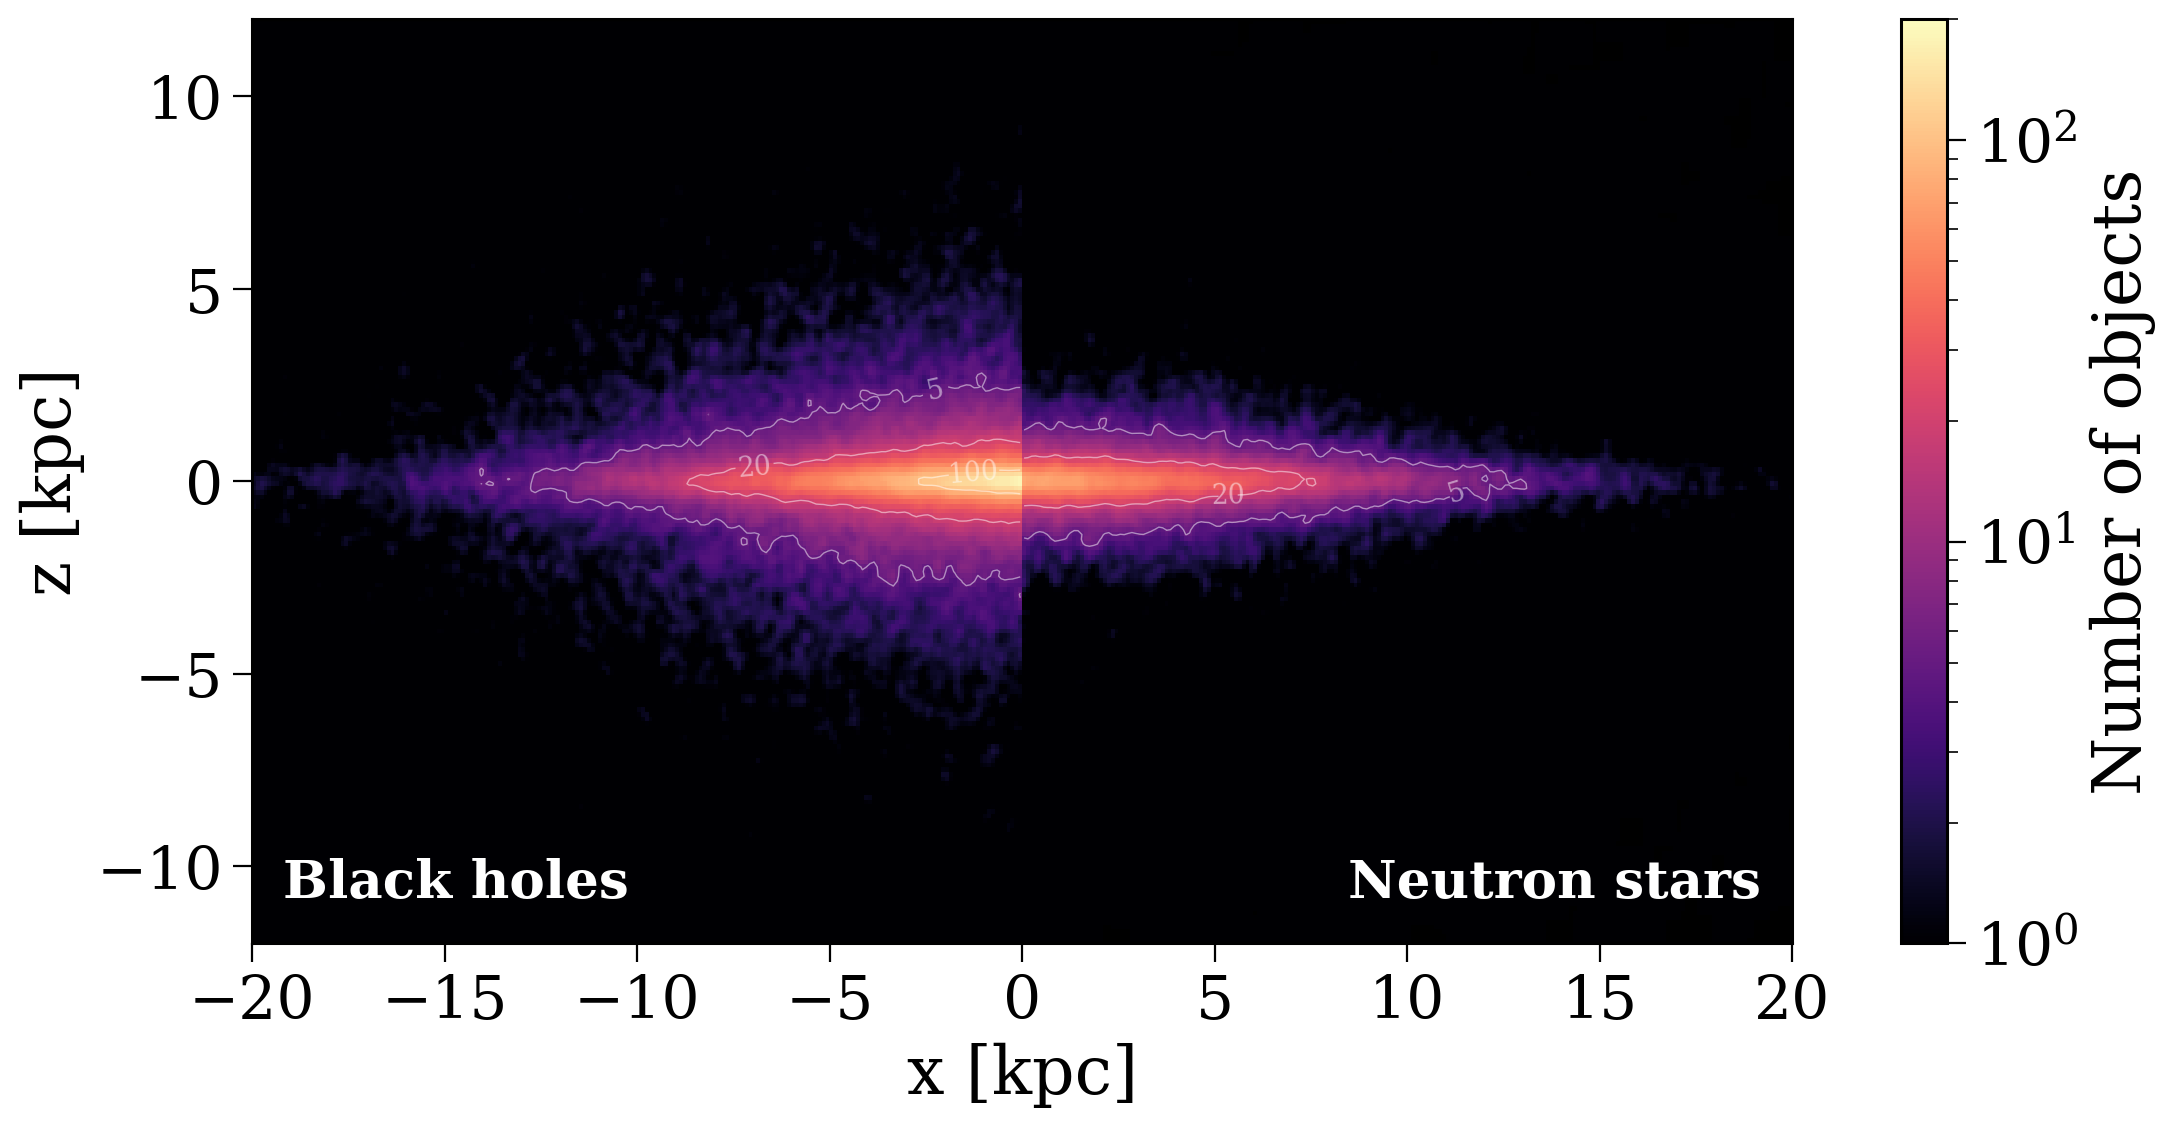

(<Figure size 1400x600 with 2 Axes>,
 <Axes: xlabel='x [kpc]', ylabel='z [kpc]'>)

In [ ]:
reload(plotting)
plotting.plot_side_on_density(
    xs=[kinematics["Binaries"]["pos"]["BH"][:, 0], kinematics["Binaries"]["pos"]["NS"][:, 0]],
    zs=[kinematics["Binaries"]["pos"]["BH"][:, 2], kinematics["Binaries"]["pos"]["NS"][:, 2]],
    labels=["Black holes", "Neutron stars"],
    xlim=20,
    zlim=12,
    n_bins=200,
    sigma=1.0,
    contours=[5, 20, 100],
    apply_smoothing=True,
)

## Velocities

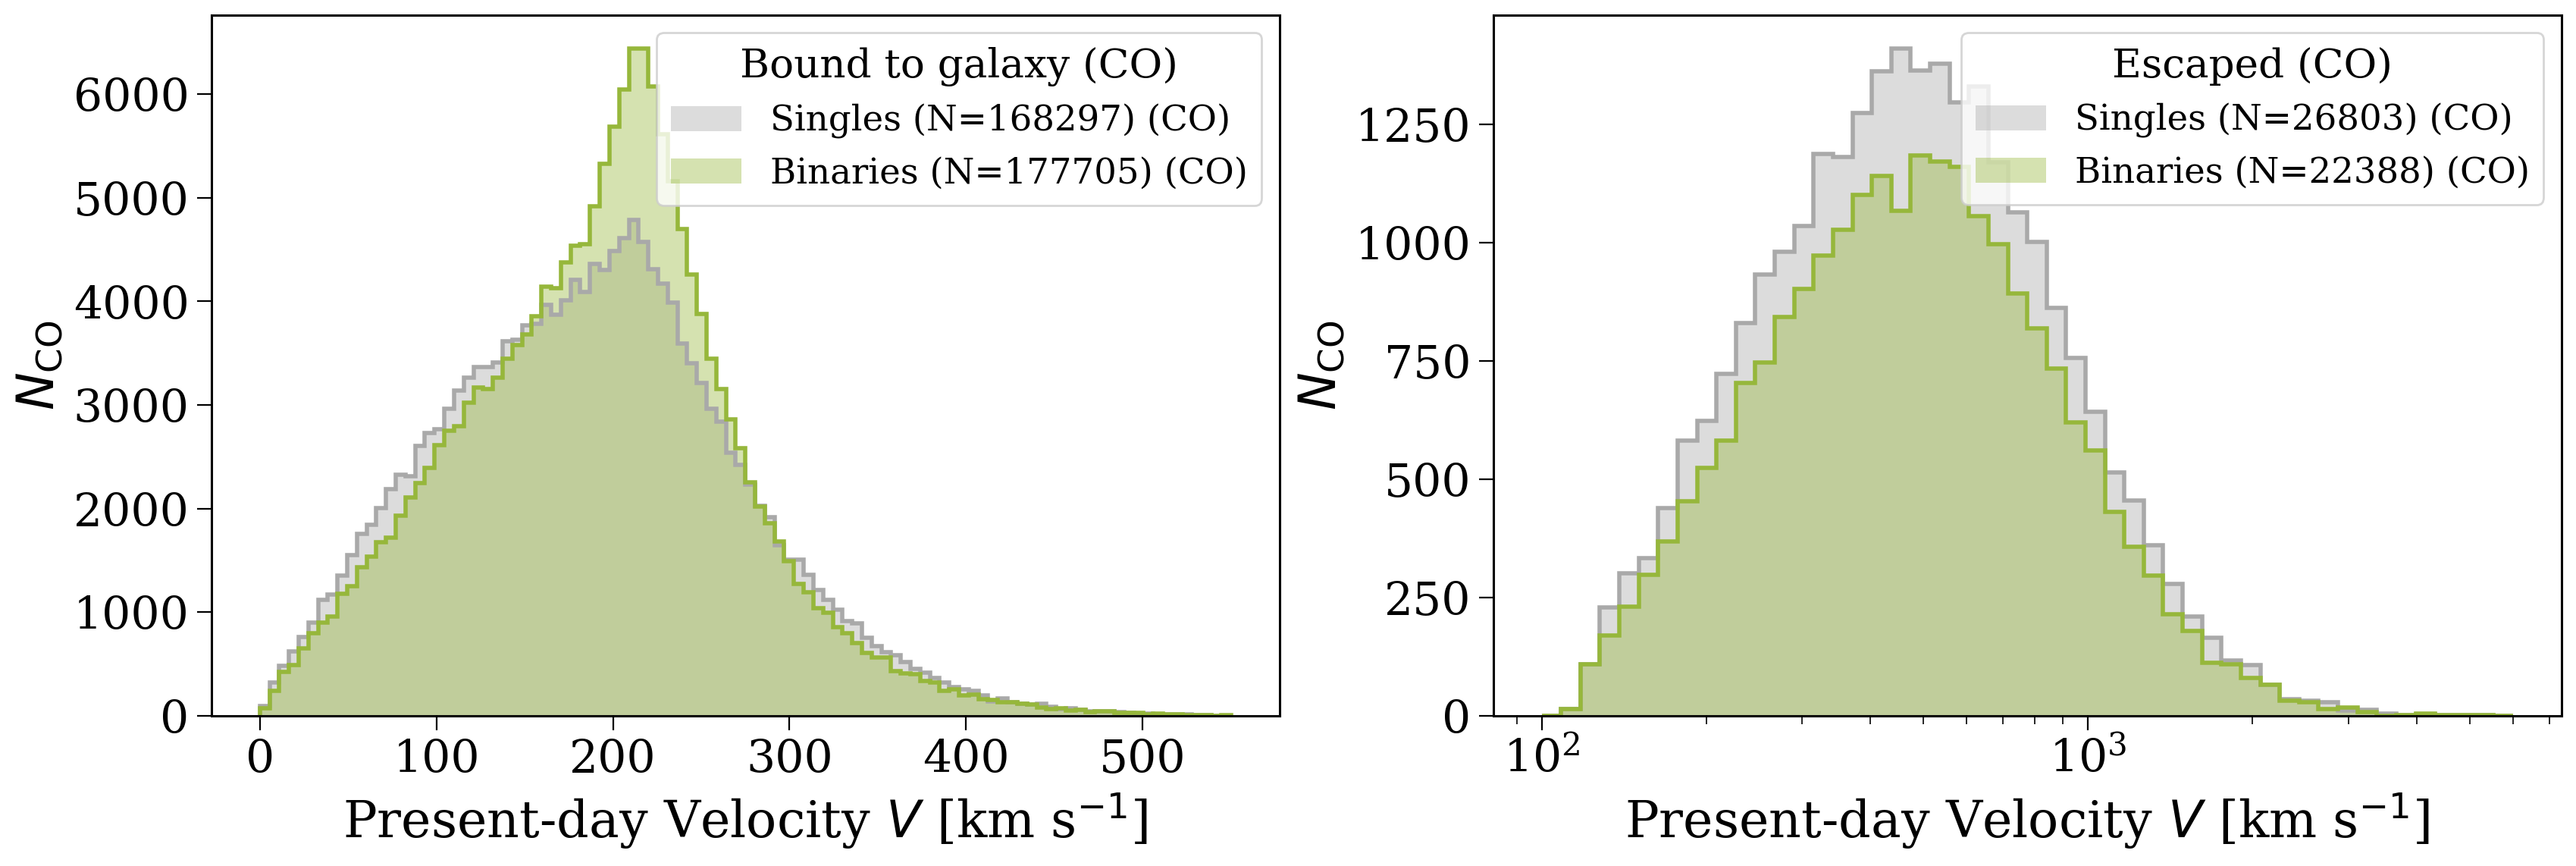

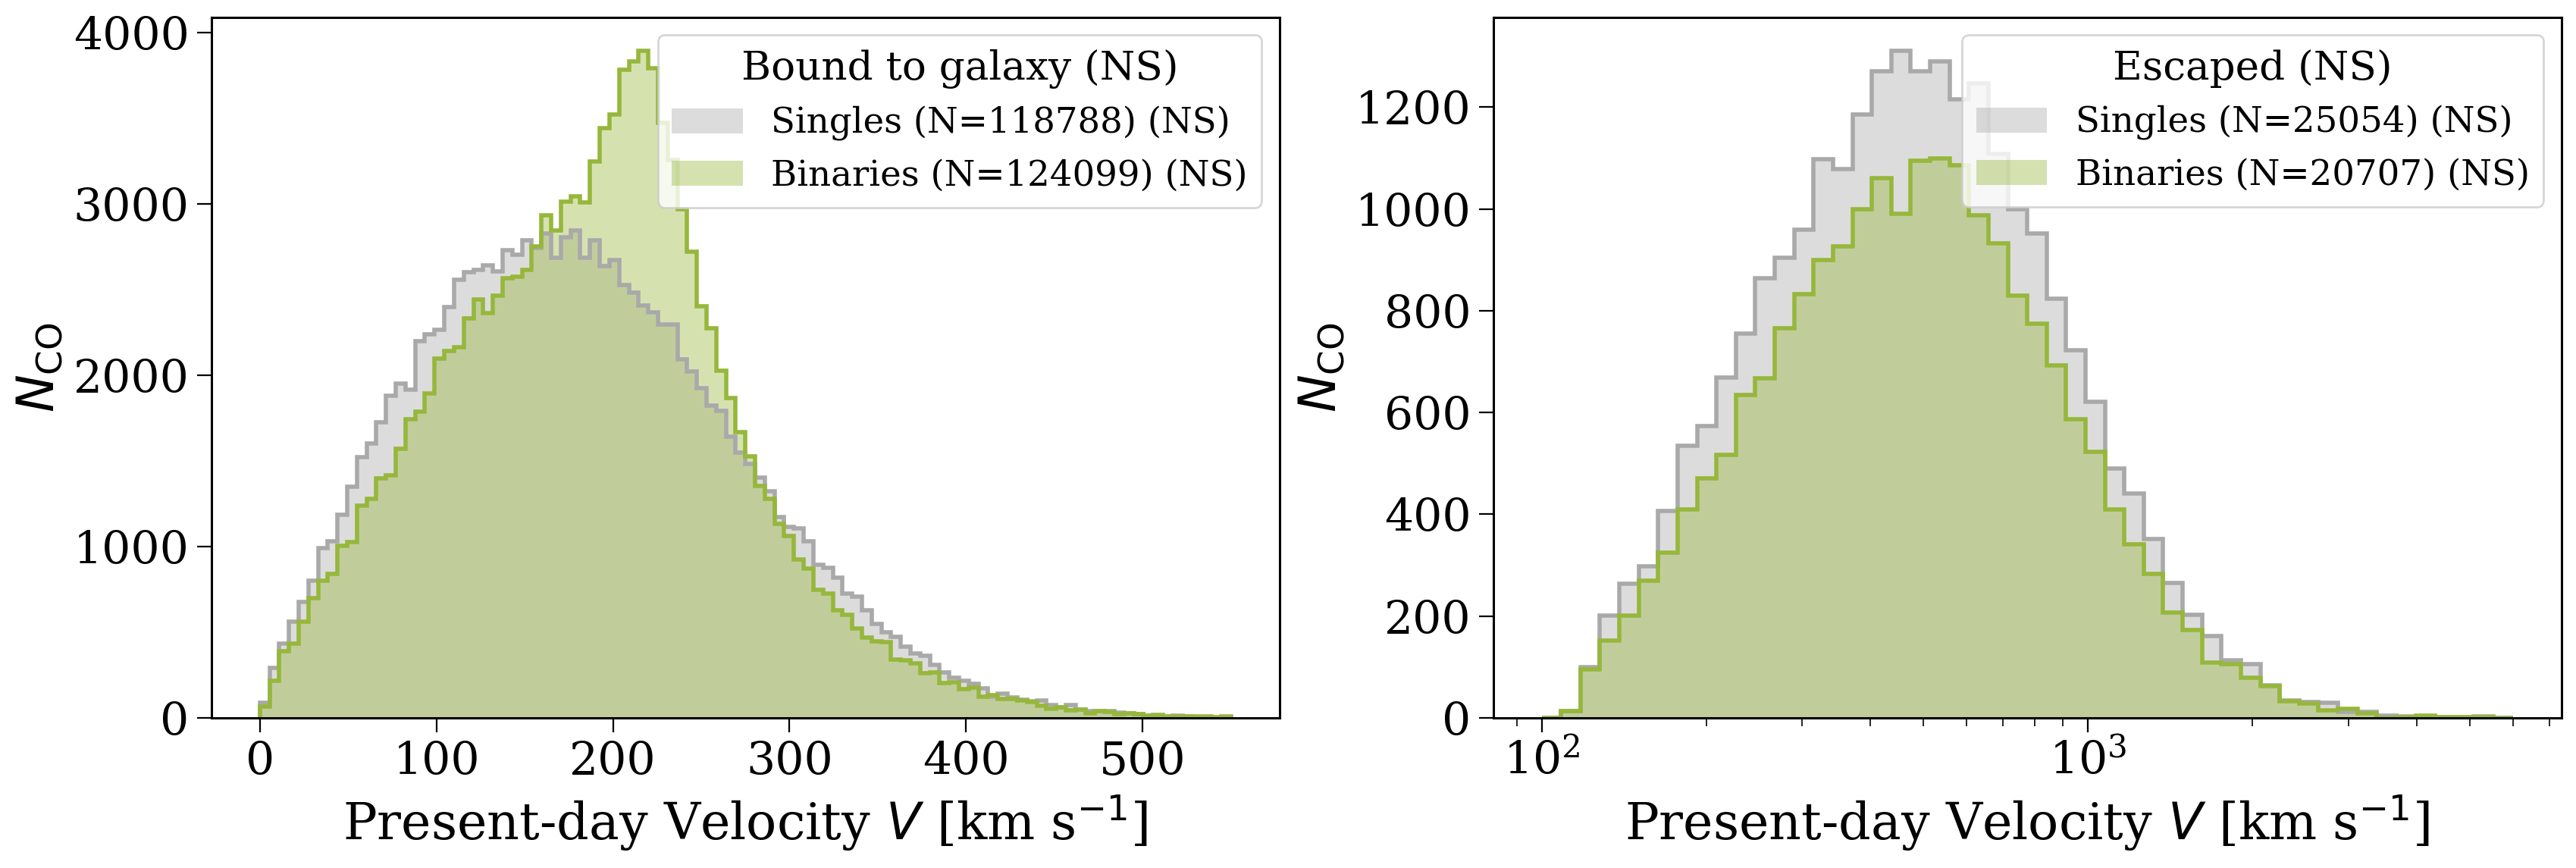

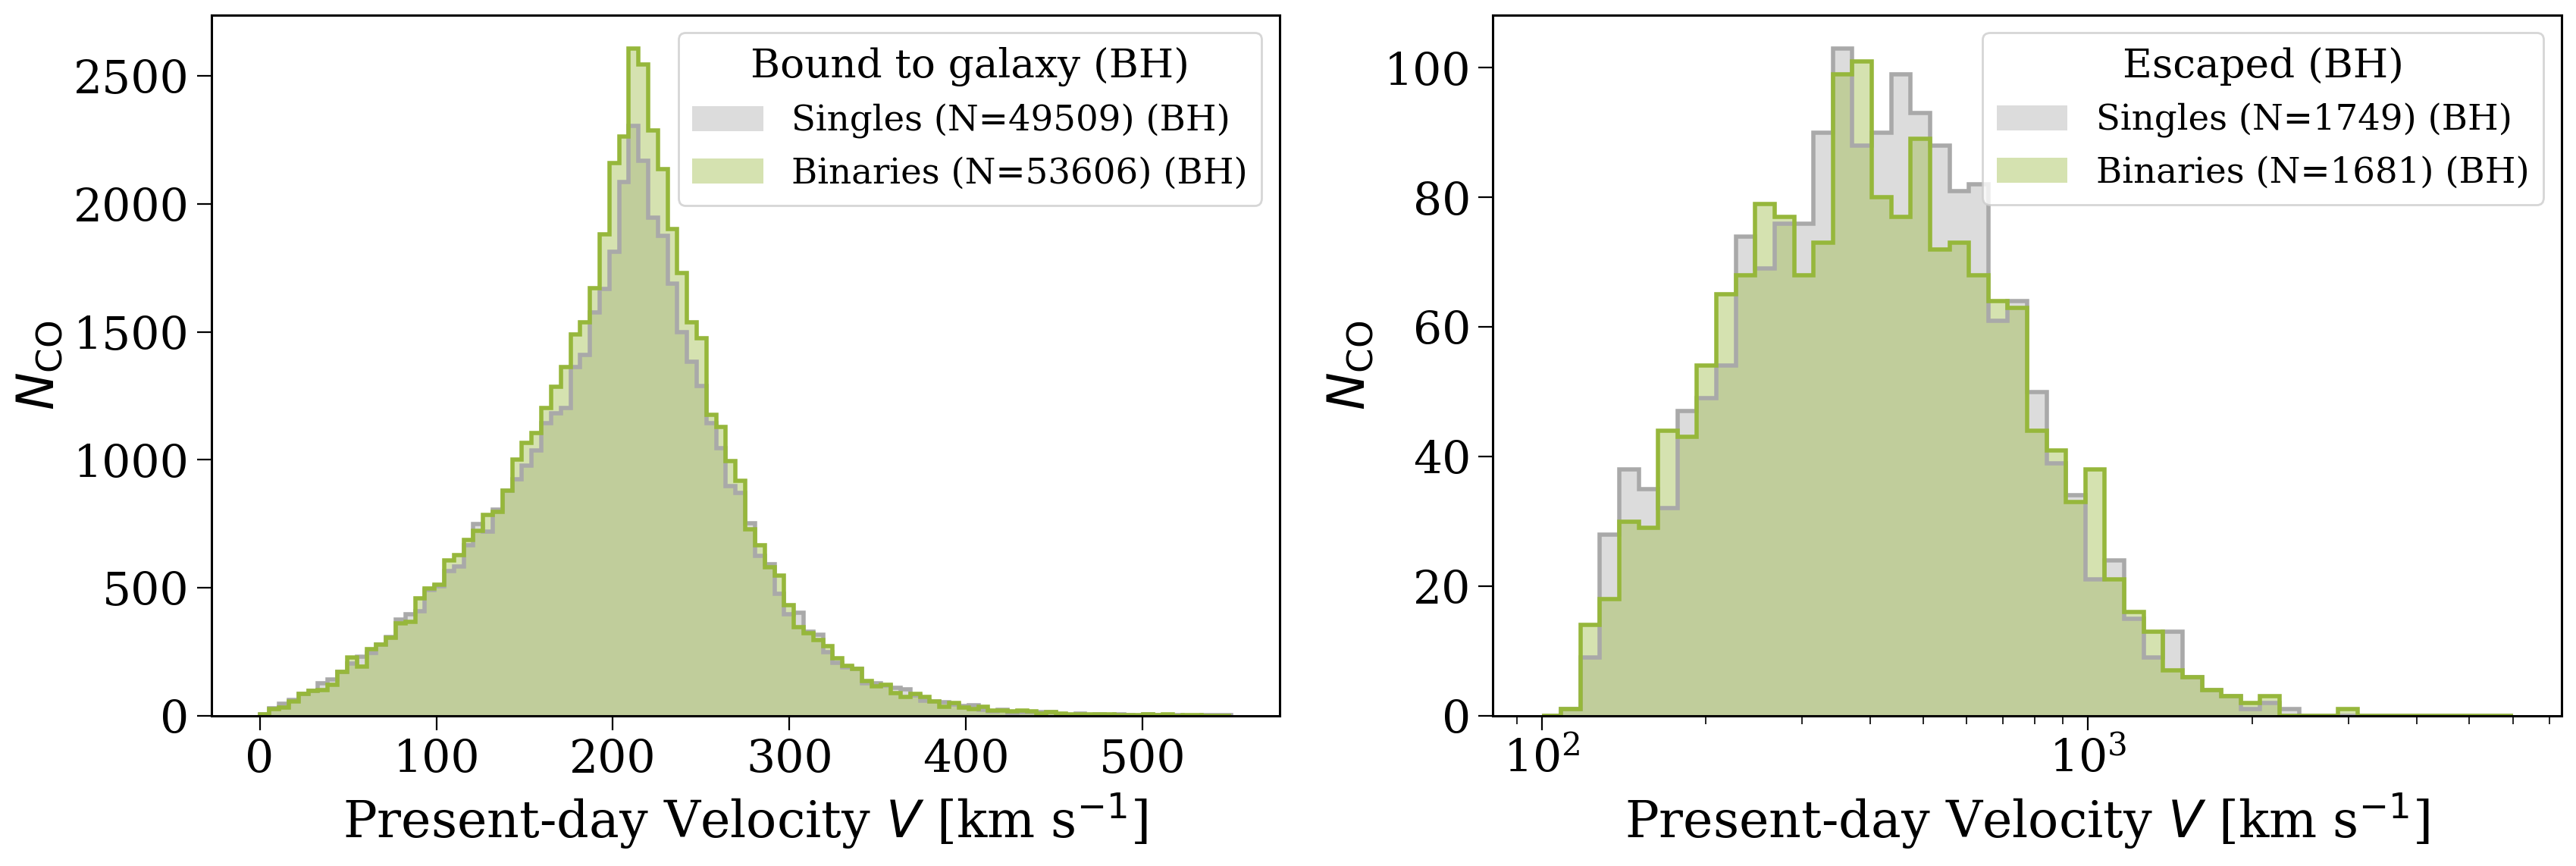

In [ ]:
for co_type in ["CO", "NS", "BH"]:

    fig, axes = plt.subplots(1, 2, figsize=(20, 6))

    density = False

    for ax, label, bins, scale in zip(axes, ['Bound to galaxy', "Escaped"],
                                    [np.linspace(0, 550, 101), np.geomspace(1e2, 6e3, 51)], ['linear', 'log']):
        for pop in [singles, binaries]:
            co_pos = kinematics[pop.label]["pos"][co_type]
            co_vel = kinematics[pop.label]["vel"][co_type]

            co_V = np.linalg.norm(co_vel.to(u.km/u.s).value, axis=1)

            mask = co_V >= np.sqrt(-2 * pop.galactic_potential(co_pos.T)).to(u.km / u.s).value
            mask = mask if label == "Escaped" else ~mask
            co_V = co_V[mask]

            plotting.nice_transparent_hist(
                ax=ax,
                data=co_V,
                bins=bins,
                label=f'{pop.label} (N={len(co_V)})' + (f" ({co_type})" if co_type != "ALL" else ""),
                colour=pop.colour,
                density=density,
            )

            ax.set(
                xlabel=r'Present-day Velocity $V$ [km s$^{-1}$]',
                ylabel=r'$N_{\rm CO}$',
                xscale=scale,
            )
            ax.legend(title=label + f" ({co_type})" if co_type != "ALL" else label)
    plt.show()

## Kicks

195100
200182


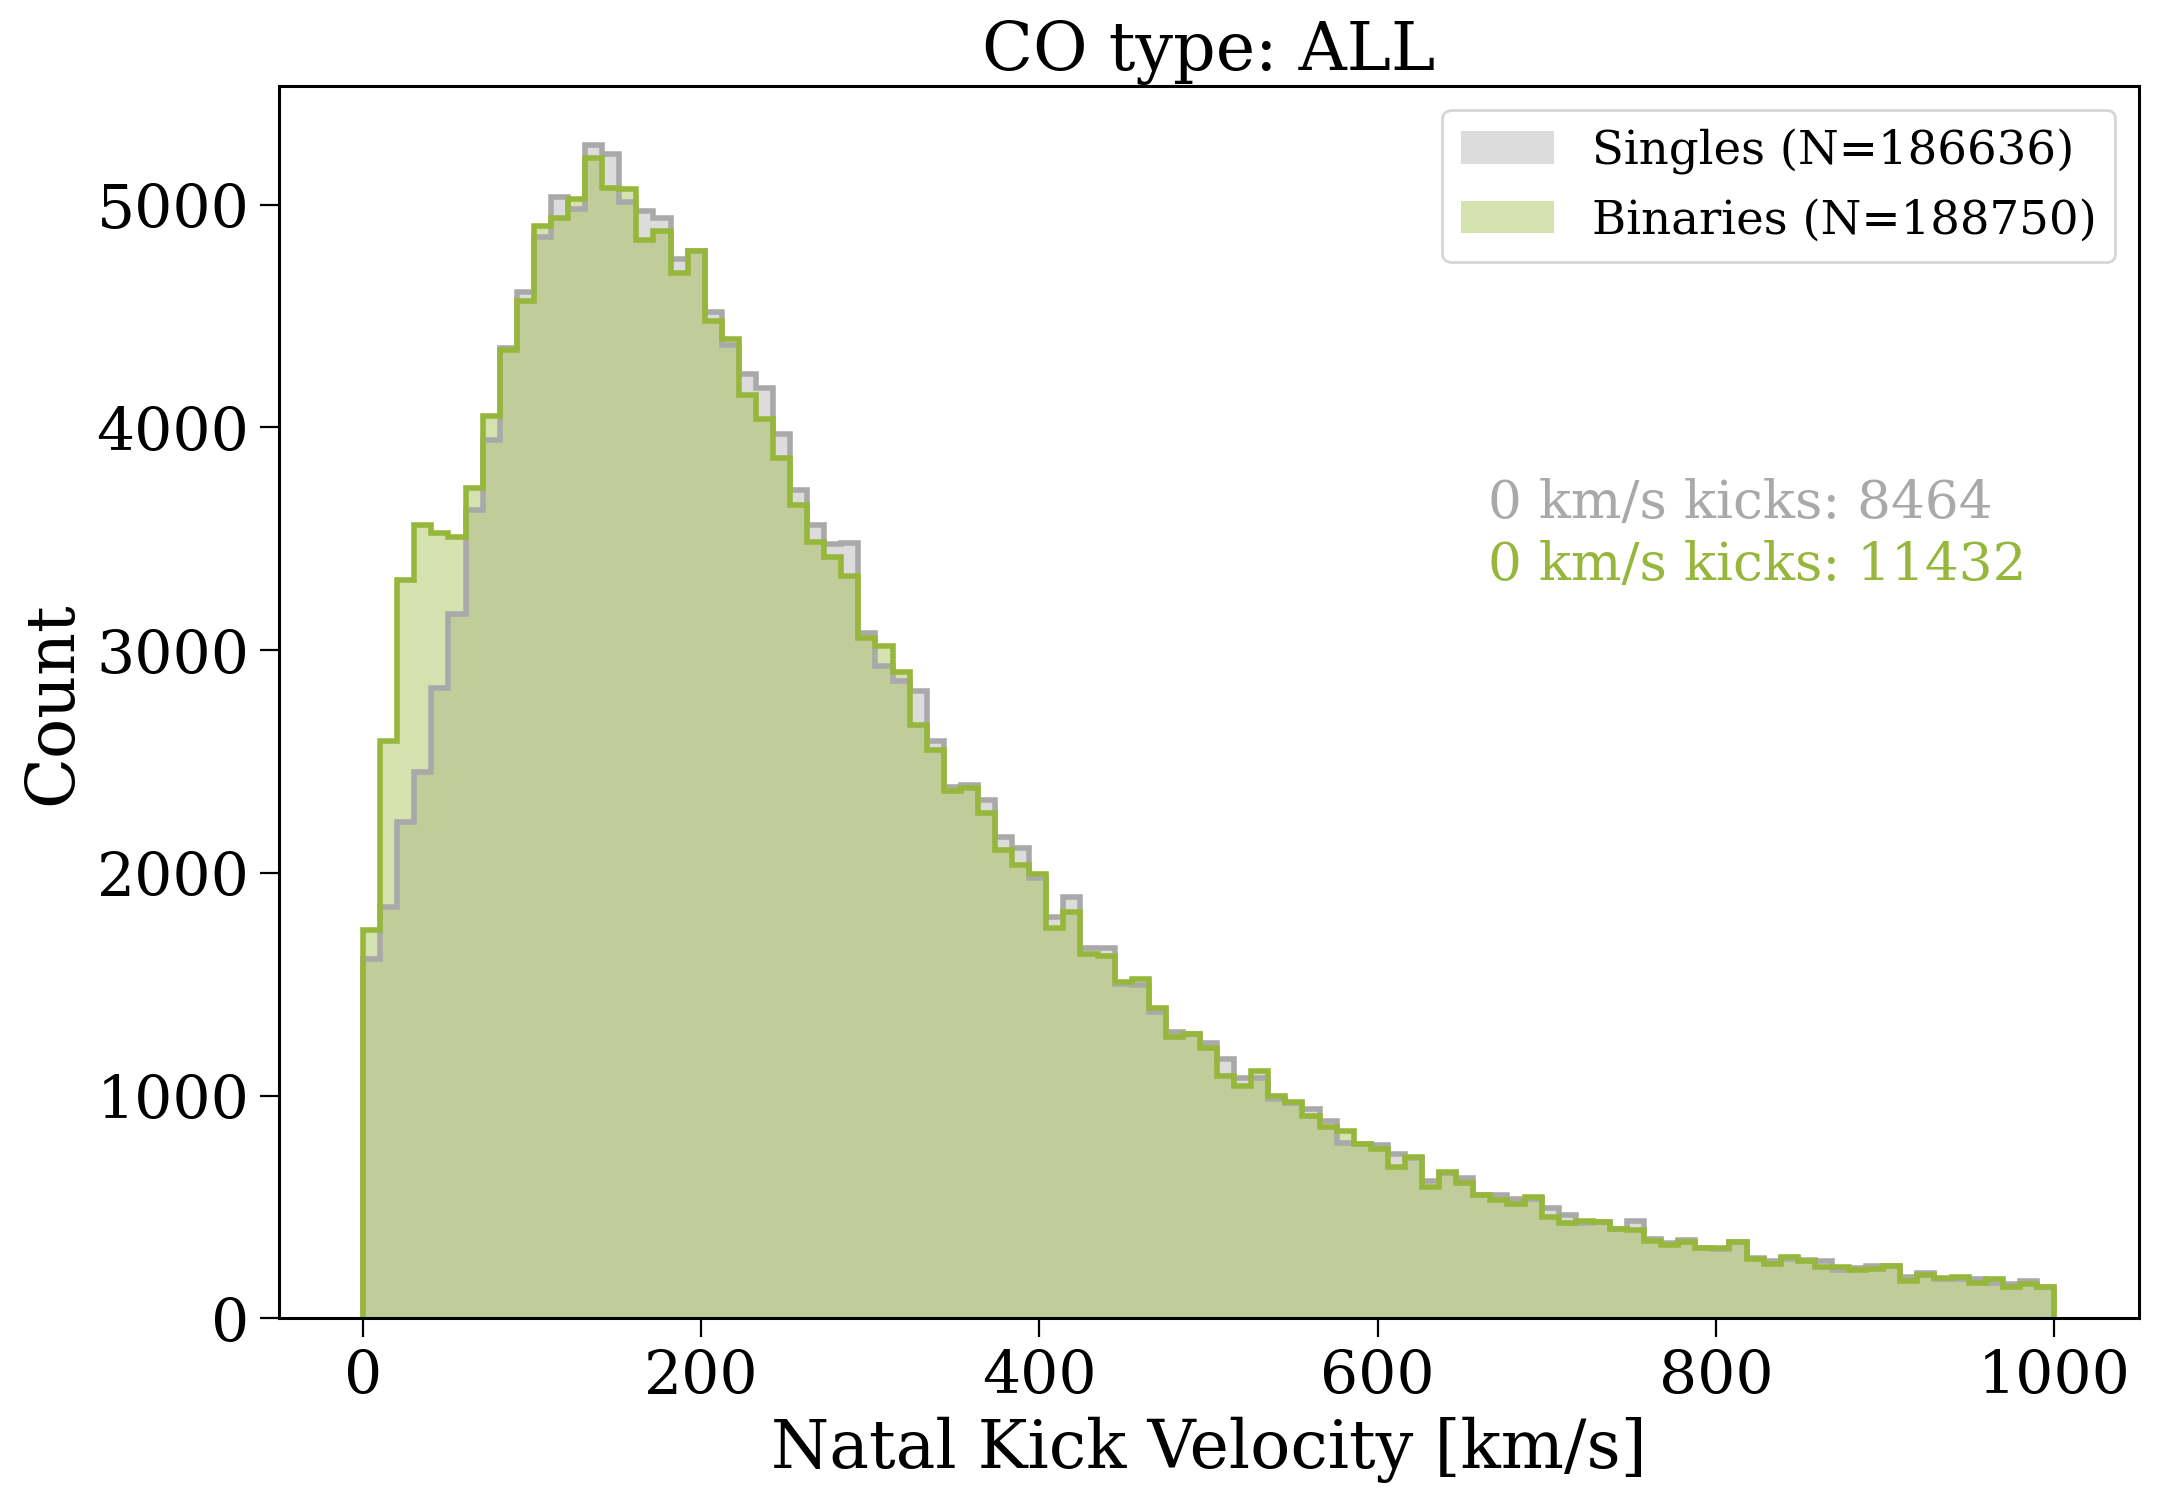

195100
200182


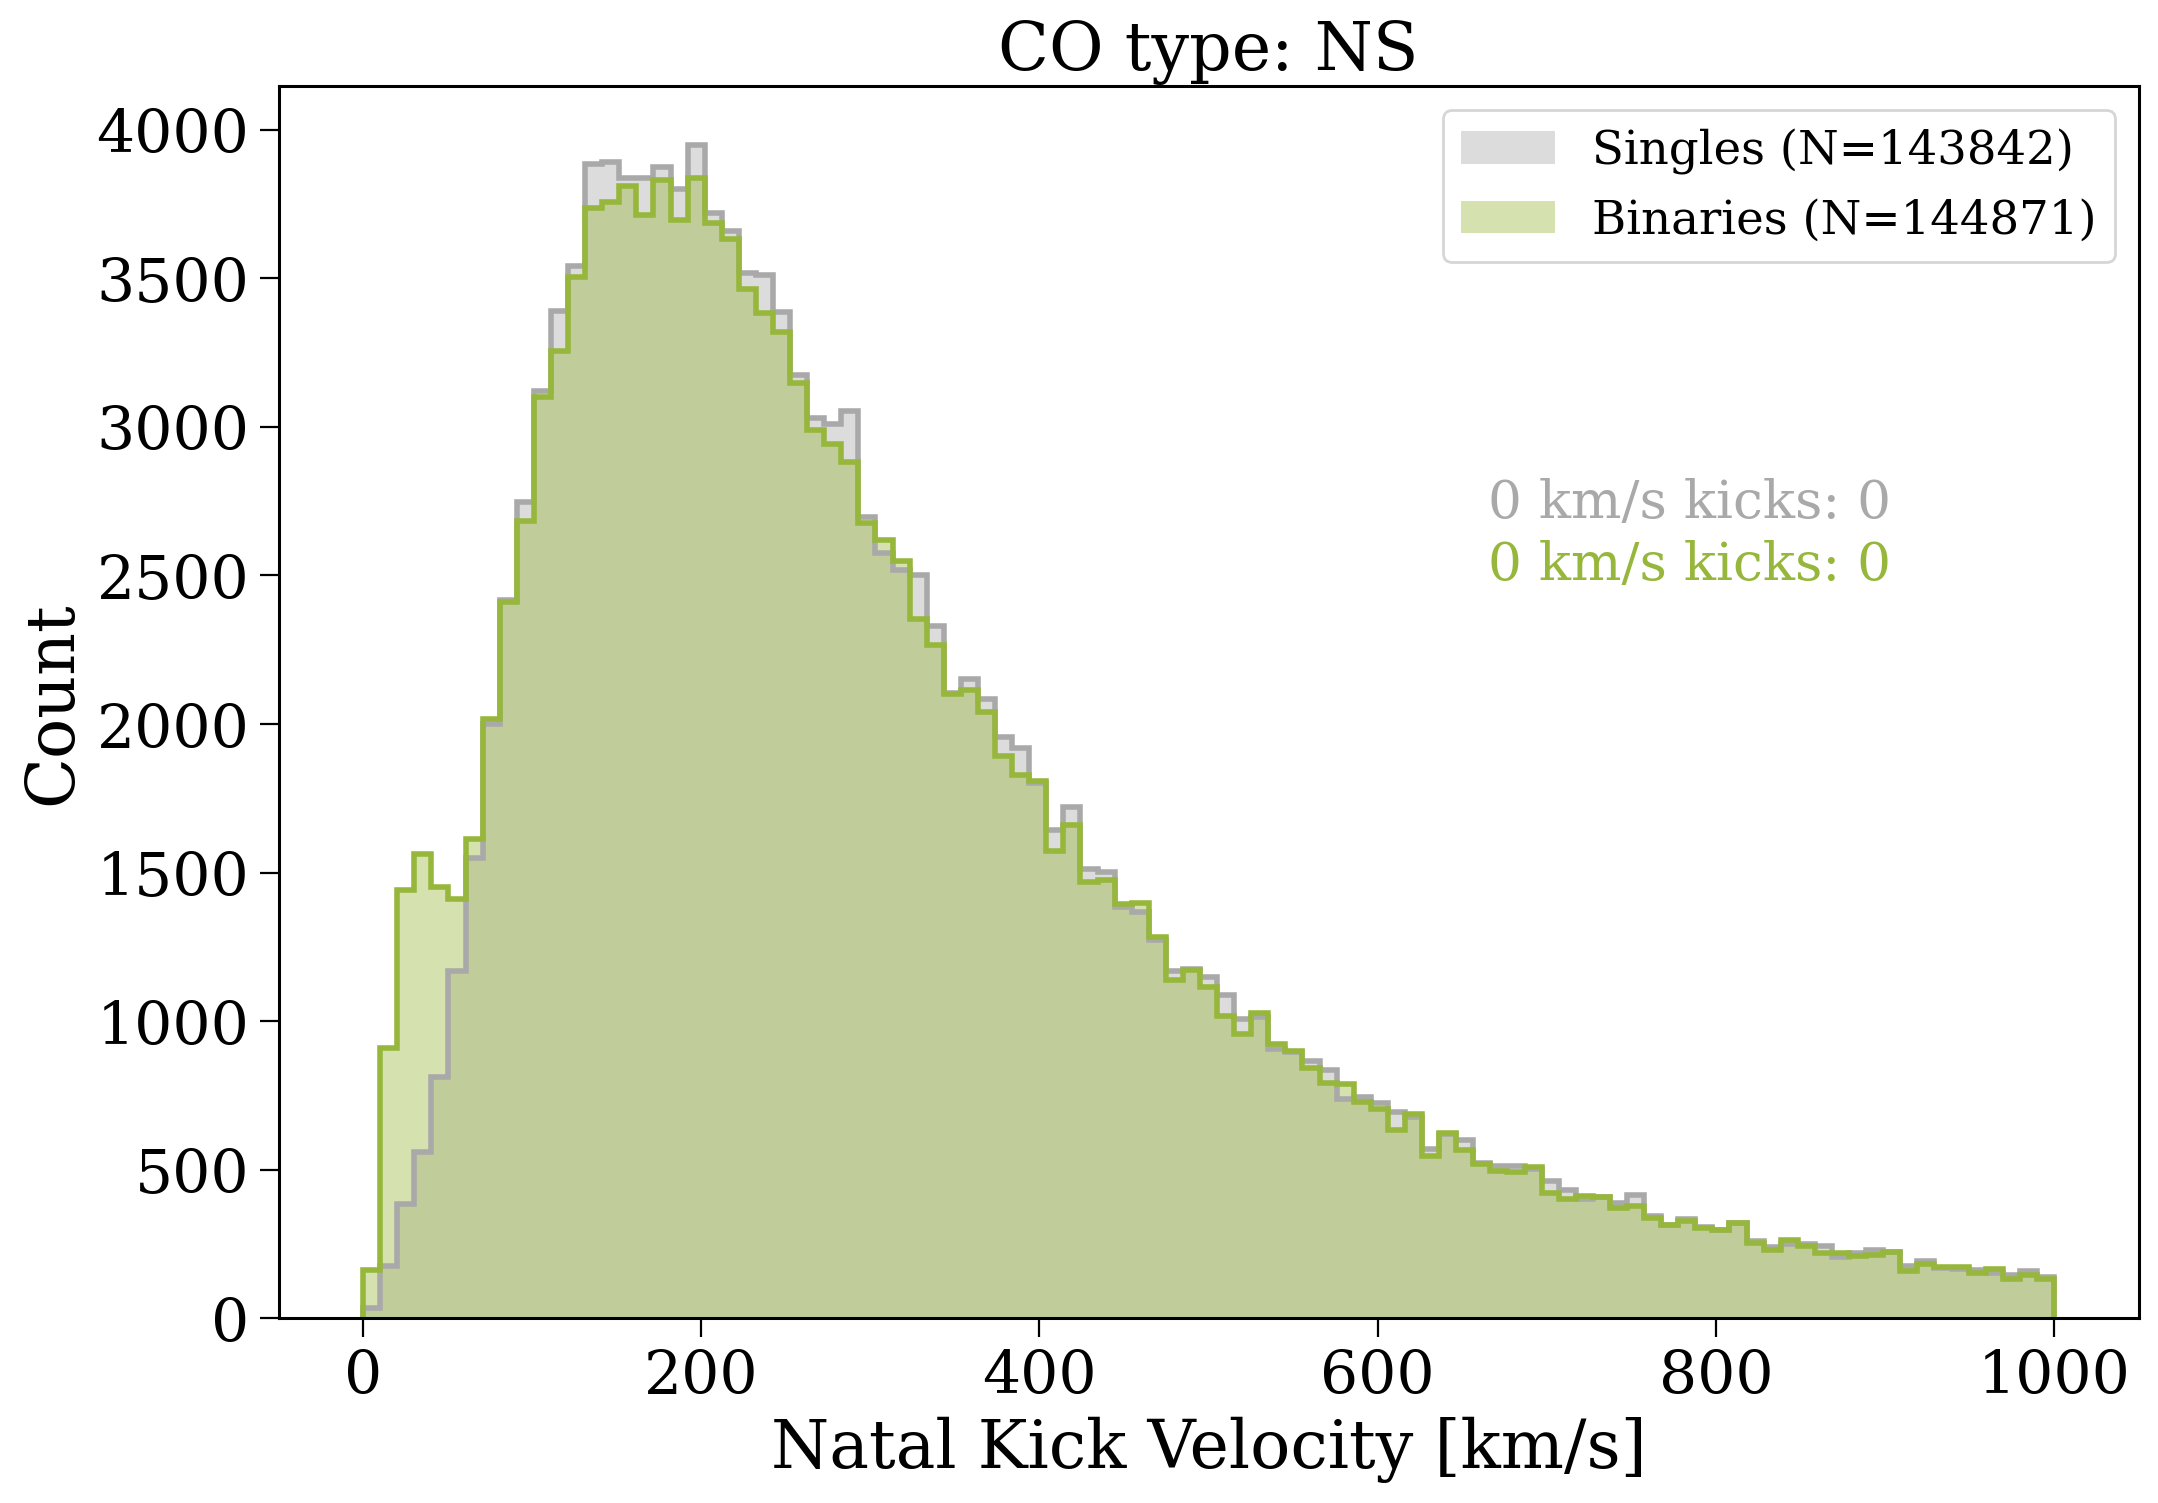

195100
200182


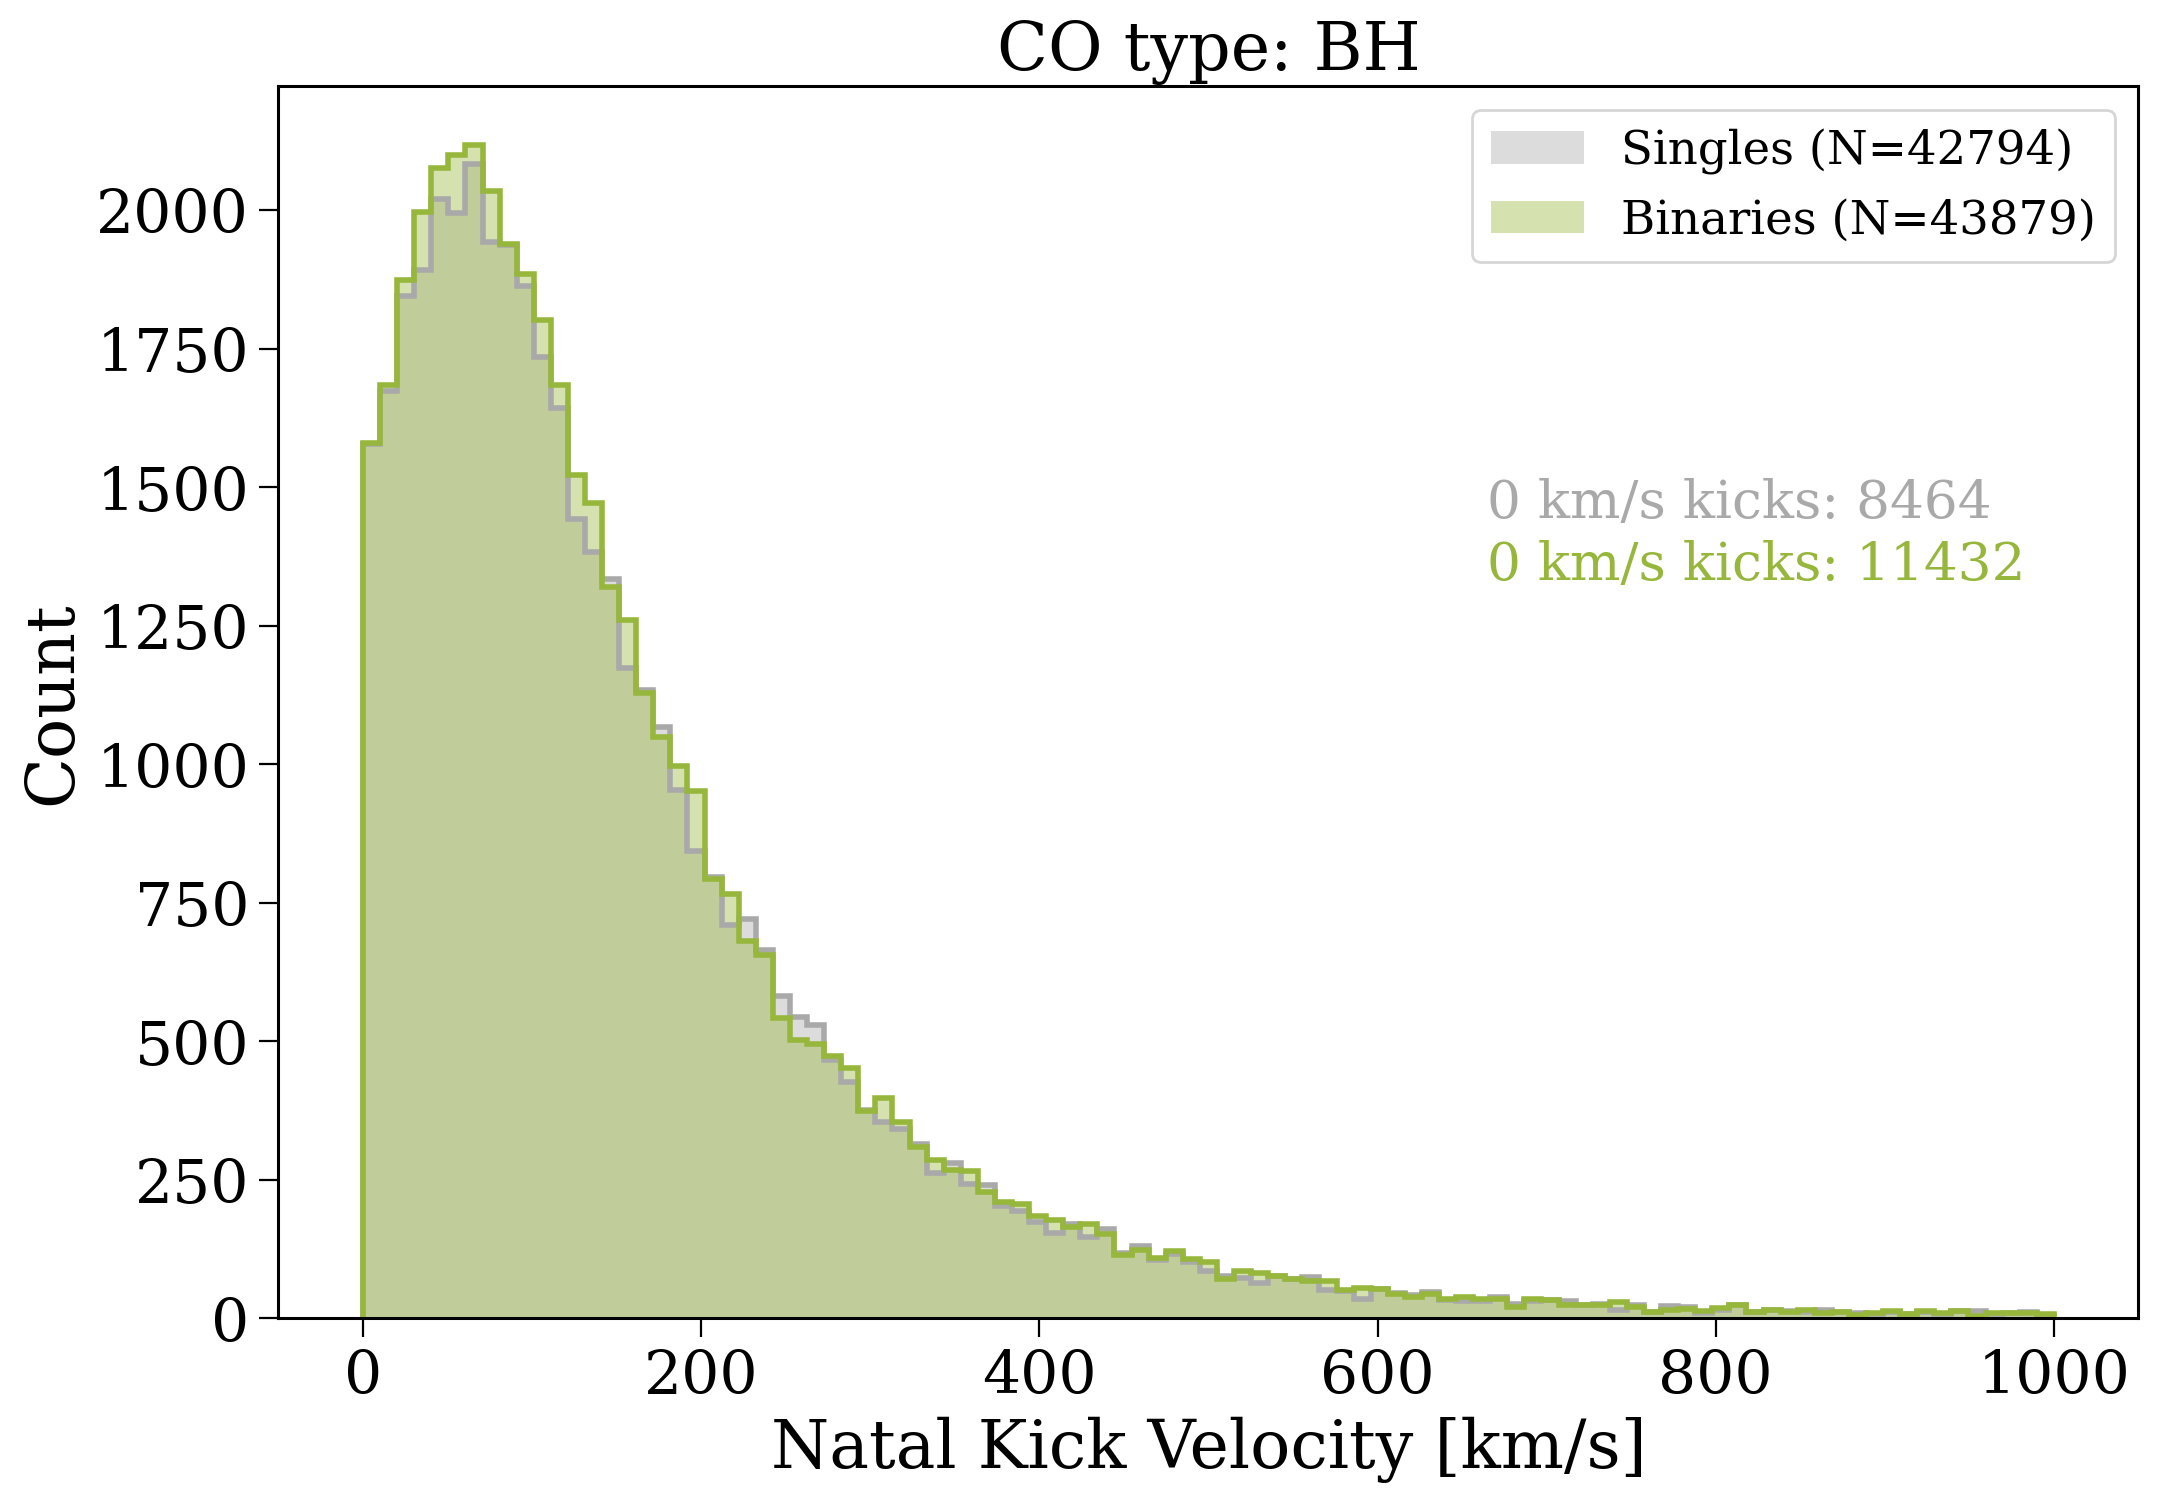

In [ ]:
density = False
for co_type_label, co_type in zip(["ALL", "NS", "BH"], [[13, 14], [13], [14]]):

    fig, ax = plt.subplots()

    bins = np.linspace(0, 1000, 100)

    for pop in [singles, binaries]:
        kick_details = pop.kick_info[pop.kick_info["star"] != 0]
        kicks = kick_details["natal_kick"]
        print(len(kicks))

        kick_rows = pop.bpp[pop.bpp["evol_type"].isin([15, 16])]
        after_kick_rows = pop.bpp[pop.bpp["row_num"].isin(kick_rows["row_num"] + 1)]
        kick_co_type = np.where(kick_details["star"] == 1, after_kick_rows["kstar_1"], after_kick_rows["kstar_2"])
        
        kicks = kicks[(np.isin(kick_co_type, co_type))]
        n_zero_kicks = (kicks == 0.0).sum()
        kicks = kicks[(kicks != 0.0)]

        ax.hist(kicks, bins=bins, density=density, histtype='step', lw=2, color=pop.colour)
        ax.hist(kicks, bins=bins, density=density, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(kicks)})")
        
        ax.annotate(
            f"0 km/s kicks: {n_zero_kicks}",
            xy=(0.65, 0.65 - 0.05 * (0 if pop.label == "Singles" else 1)),
            xycoords='axes fraction',
            color=pop.colour,
            fontsize=0.8*fs,
        )

    ax.set(
        xlabel="Natal Kick Velocity [km/s]",
        ylabel="Count",
    )
    ax.set_title(f"CO type: {co_type_label}", fontsize=fs)
    ax.legend()
    plt.show()

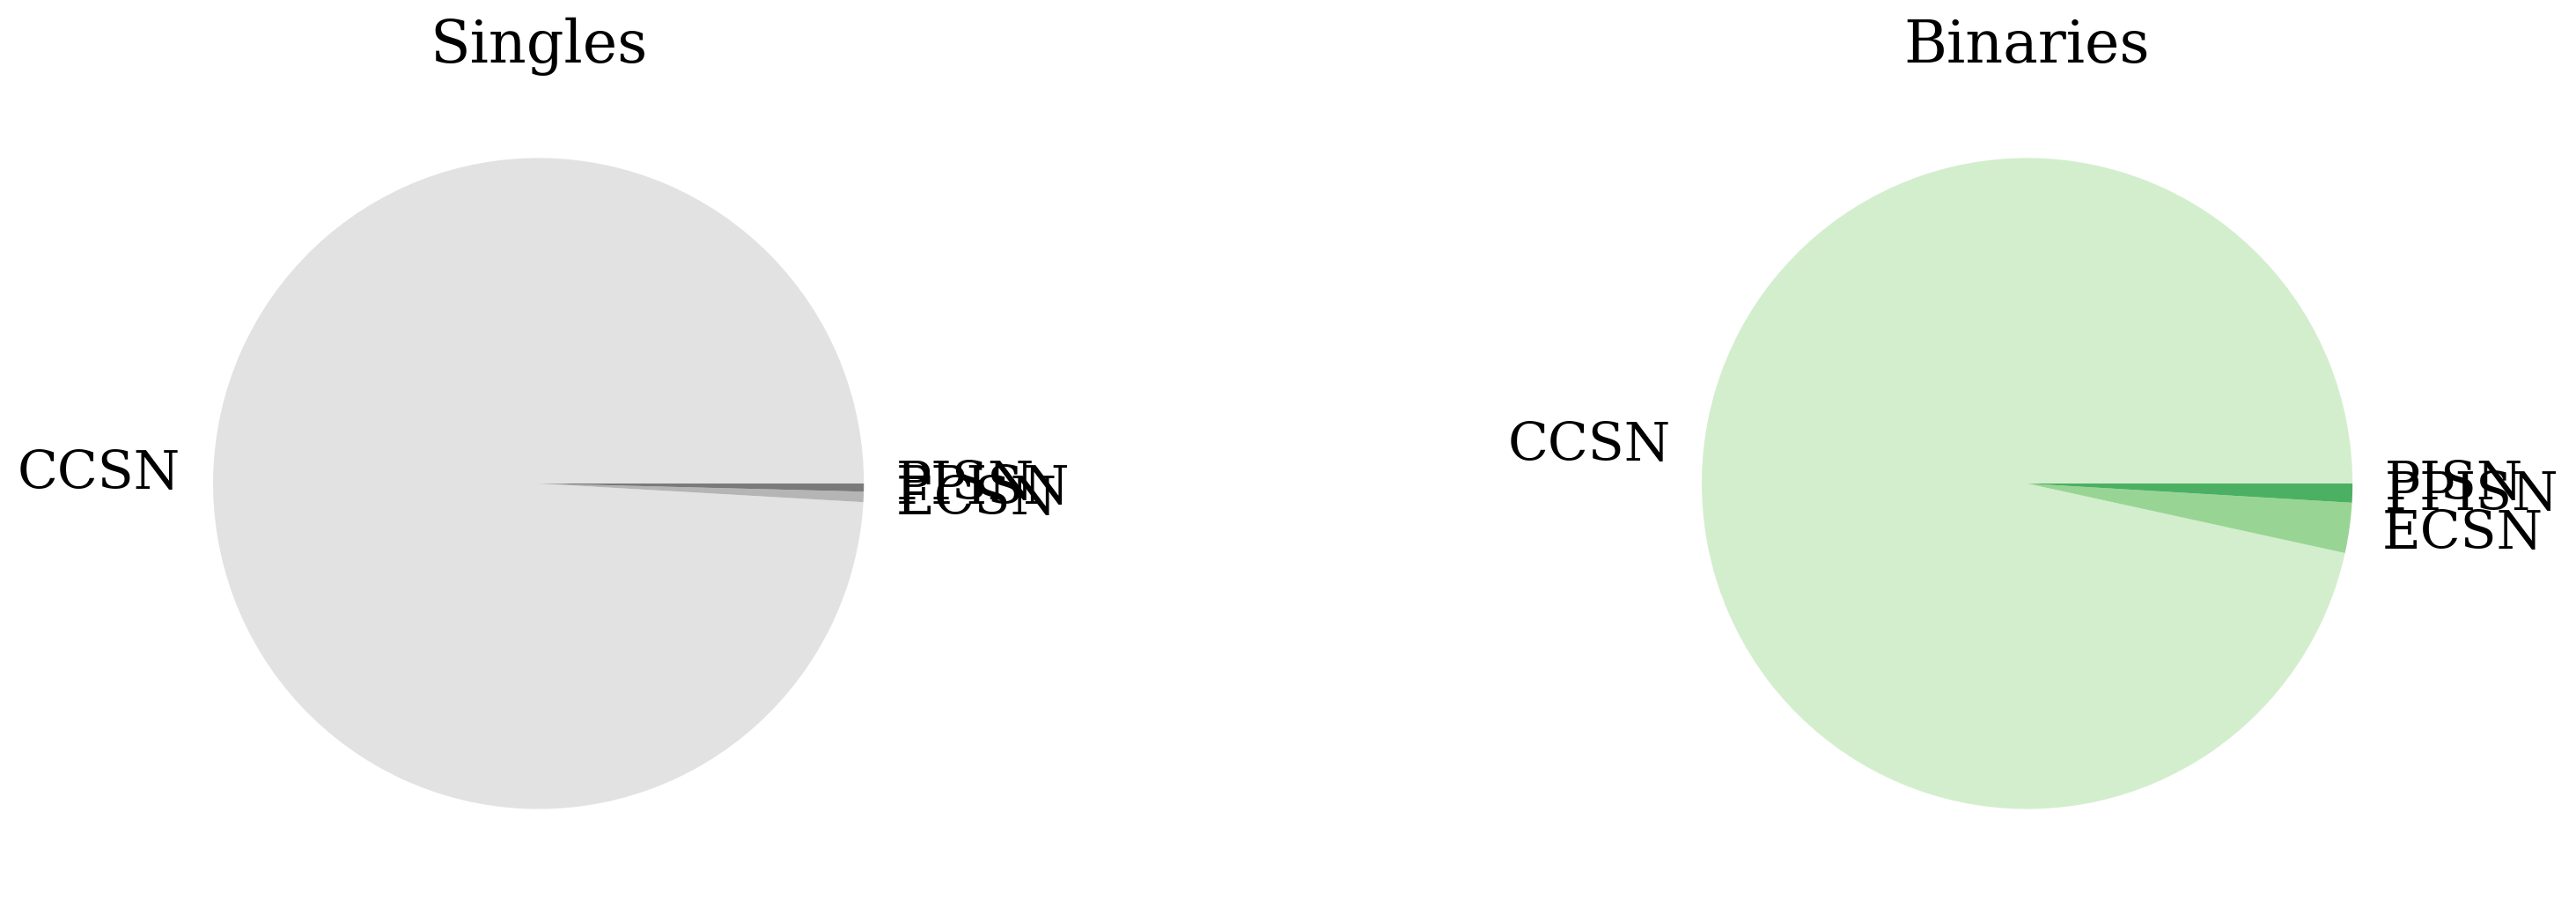

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for pop, ax in zip([singles, binaries], axes):
    sn_types = np.concatenate((
        pop.final_bpp["SN_1"],
        pop.final_bpp["SN_2"],
    ))
    types, counts = np.unique(sn_types[sn_types > 0], return_counts=True)

    type_label_dict = {
        1: "CCSN",
        2: "ECSN",
        3: "USSN",
        4: "AIC",
        5: "MIC",
        6: "PPISN",
        7: "PISN",
    }

    ax.pie(
        counts,
        labels=[type_label_dict[t] for t in types],
        colors=sns.color_palette("Greens" if pop.label == 'Binaries' else "Greys", n_colors=len(types)),
    )

    ax.set_title(pop.label, fontsize=fs)

0 1 [np.int64(193321), np.int64(194537)]
1 2 [np.int64(1003), np.int64(5008)]
2 6 [np.int64(776), np.int64(1894)]
3 7 [np.int64(2), np.int64(2)]


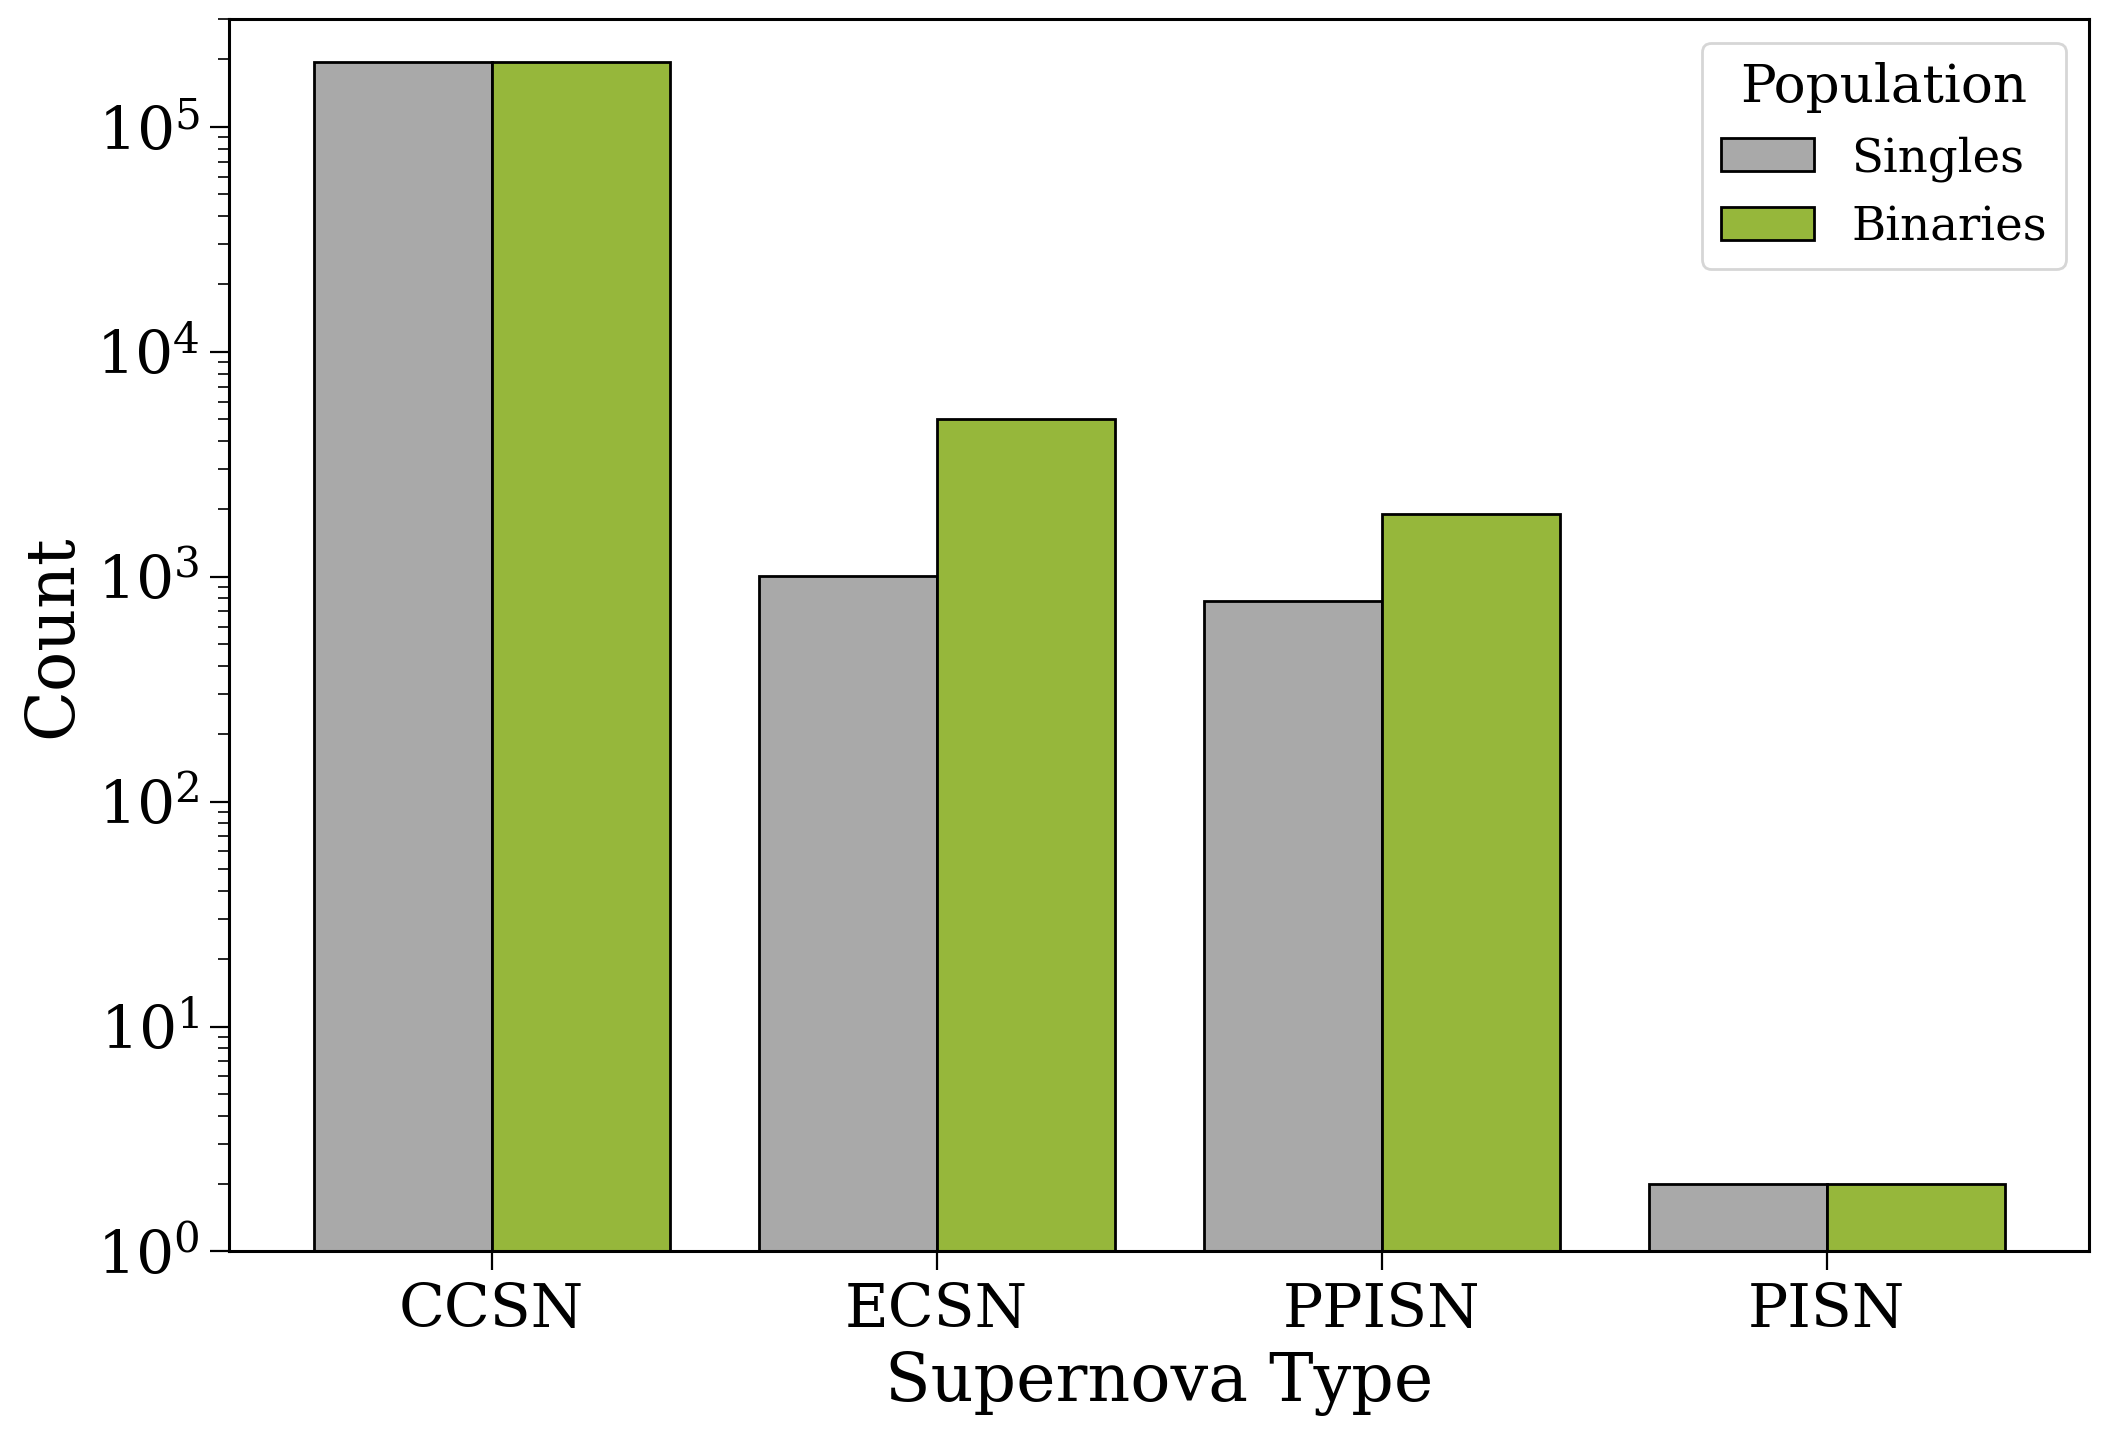

In [ ]:
fig, ax = plt.subplots()

count_lists = {
    1: [0, 0],
    2: [0, 0],
    6: [0, 0],
    7: [0, 0],
}
colours = [singles.colour, binaries.colour]

for i, pop in enumerate([singles, binaries]):
    sn_types = np.concatenate((
        pop.final_bpp["SN_1"],
        pop.final_bpp["SN_2"],
    ))
    types, counts = np.unique(sn_types[sn_types > 0], return_counts=True)
    
    for t, c in zip(types, counts):
        count_lists[t][i] = c



type_label_dict = {
    1: "CCSN",
    2: "ECSN",
    3: "USSN",
    4: "AIC",
    5: "MIC",
    6: "PPISN",
    7: "PISN",
}

width = 0.4

for i, (t, counts) in enumerate(count_lists.items()):
    print(i, t, counts)
    ax.bar(i + np.array([-width/2, width/2]), counts, width=width, label=["Singles", "Binaries"] if i == 0 else None, edgecolor='black',
           color=colours)

ax.set_xticks(np.arange(len(count_lists)), [type_label_dict[t] for t in count_lists.keys()])
ax.set_xlabel("Supernova Type")
ax.set_ylabel("Count")
ax.legend(title="Population")

# ax.set_title(pop.label, fontsize=fs)

ax.set(
    ylim=(1e0, 3e5),
    yscale='log',
)

plt.show()

# Nearest COs

In [ ]:
print()
for co_type in ["CO", "NS", "BH"]:
    co_pos = kinematics["Binaries"]["pos"][co_type]

    # count how many COs are within a torus of major radius 8kpc and minor radius 0.2kpc
    # shape of co_pos is (N, 3), in galactocentric cartesian
    R = np.sqrt(co_pos[:, 0]**2 + co_pos[:, 1]**2).to(u.kpc).value
    z = co_pos[:, 2].to(u.kpc).value
    torus_mask = ((R - 8)**2 + z**2) <= 0.2**2
    n_in_torus = torus_mask.sum()
    n_total = len(co_pos)

    # density of COs in torus in pc^-3
    torus_volume = 2 * np.pi**2 * 8 * 0.2**2 * u.kpc**3
    co_density = n_in_torus / torus_volume.to(u.pc**3) * scale_up
    one_per_volume = 1 / co_density

    # find probable distance to nearest assuming a sphere
    nearest_distance = (3 / (4 * np.pi * co_density))**(1/3)
    print(f"Probably distance to the nearest {co_type} is {nearest_distance:.2f}")

Probably distance to the nearest CO is 8.43 pc
Probably distance to the nearest NS is 10.03 pc
Probably distance to the nearest BH is 11.38 pc


# Double compact objects with a NS/BH

## At present day

In [ ]:
print(f"Scale everything up by a factor of ~{scale_up:.0f}x\n")
for pop in [binaries]:
    # print the number of bound binaries with a CO and their kstars
    co_binaries = pop.final_bpp[
        ((pop.final_bpp["kstar_1"].isin([13, 14])) | (pop.final_bpp["kstar_2"].isin([13, 14]))) &
        (pop.final_bpp["sep"] > 0)
    ]
    print(f"Total number of DCOs: {len(co_binaries)}")
    print(co_binaries[["kstar_1", "kstar_2"]].value_counts())

Scale everything up by a factor of ~3308x

Total number of DCOs: 1376
kstar_1  kstar_2
14       14         1041
         11          103
13       11           57
         10           54
14       10           36
         13           35
         12           28
13       0             7
         1             7
         13            2
15       14            2
13       12            1
         2             1
14       0             1
         1             1
Name: count, dtype: int64


In [ ]:
ns_ms = binaries.final_bpp[(binaries.final_bpp["kstar_1"] == 13) & (binaries.final_bpp["kstar_2"] < 2) & (binaries.final_bpp["sep"] > 0)]["bin_num"]

## Mergers

In [ ]:
bhbh_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    (binaries.bpp["kstar_1"] == 14) & (binaries.bpp["kstar_2"] == 14)
)]
nsns_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    (binaries.bpp["kstar_1"] == 13) & (binaries.bpp["kstar_2"] == 13)
)]
nsbh_mergers = binaries.bpp[(binaries.bpp["evol_type"] == 3) & (
    ((binaries.bpp["kstar_1"] == 13) & (binaries.bpp["kstar_2"] == 14)) |
    ((binaries.bpp["kstar_1"] == 14) & (binaries.bpp["kstar_2"] == 13))
)]
print(f"Estimated number of mergers in a MW-mass galaxy (minimum here would be {scale_up:.0f}):")
print(f"  BH-BH mergers: {len(bhbh_mergers) * scale_up:.0f}")
print(f"  NS-NS mergers: {len(nsns_mergers) * scale_up:.0f}")
print(f"  NS-BH mergers: {len(nsbh_mergers) * scale_up:.0f}")

Estimated number of mergers in a MW-mass galaxy (minimum here would be 3308):
  BH-BH mergers: 205072
  NS-NS mergers: 6615
  NS-BH mergers: 82690


# Initial conditions

## Mass

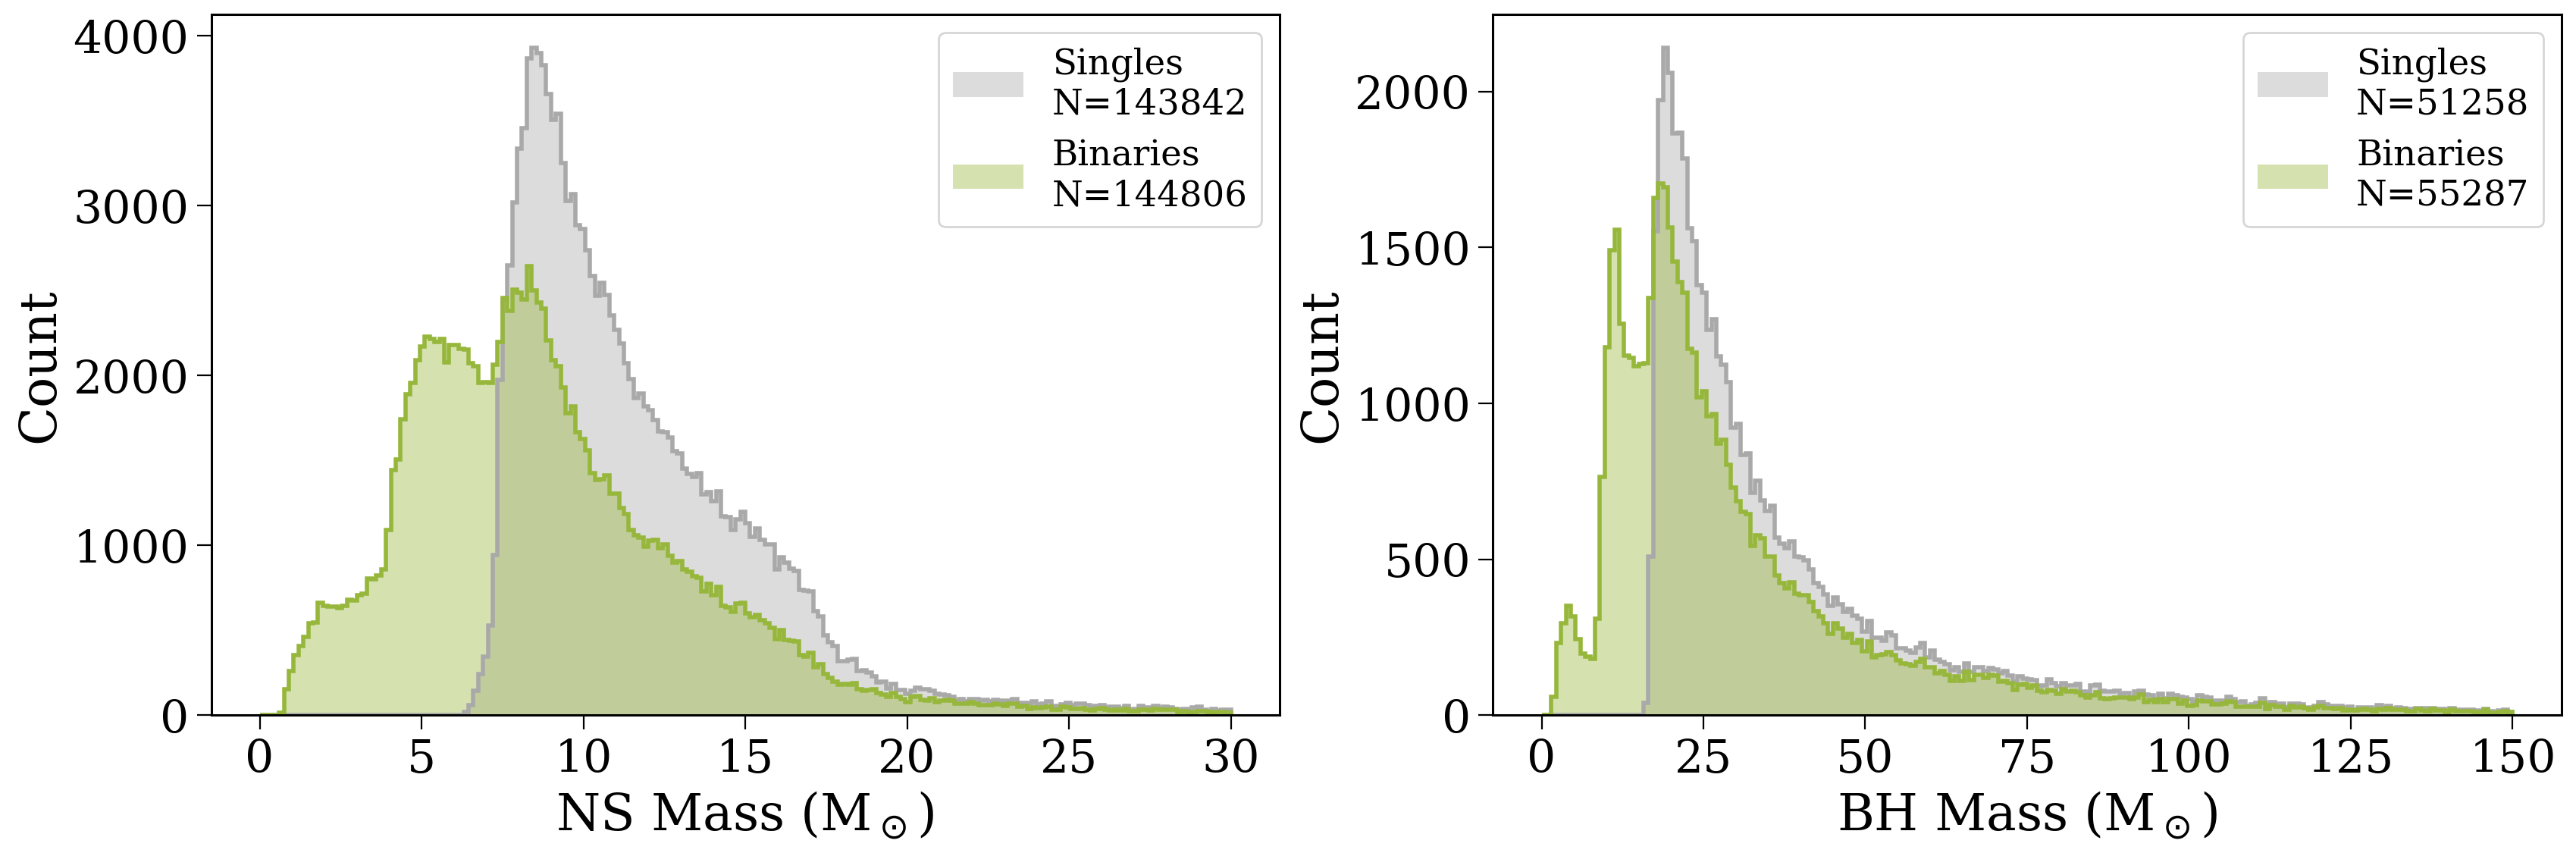

In [252]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    plotting.compare_table_quantity(
        pops=[singles, binaries],
        table_name="initC",
        quantity="mass",
        kstar=kstar,
        bins=bins,
        xlabel=f"{co_type} Mass (M$_\odot$)",
        ylabel="Count",
        density=False,
        ax=ax,
        fig=fig,
        show=False
    )
plt.show()

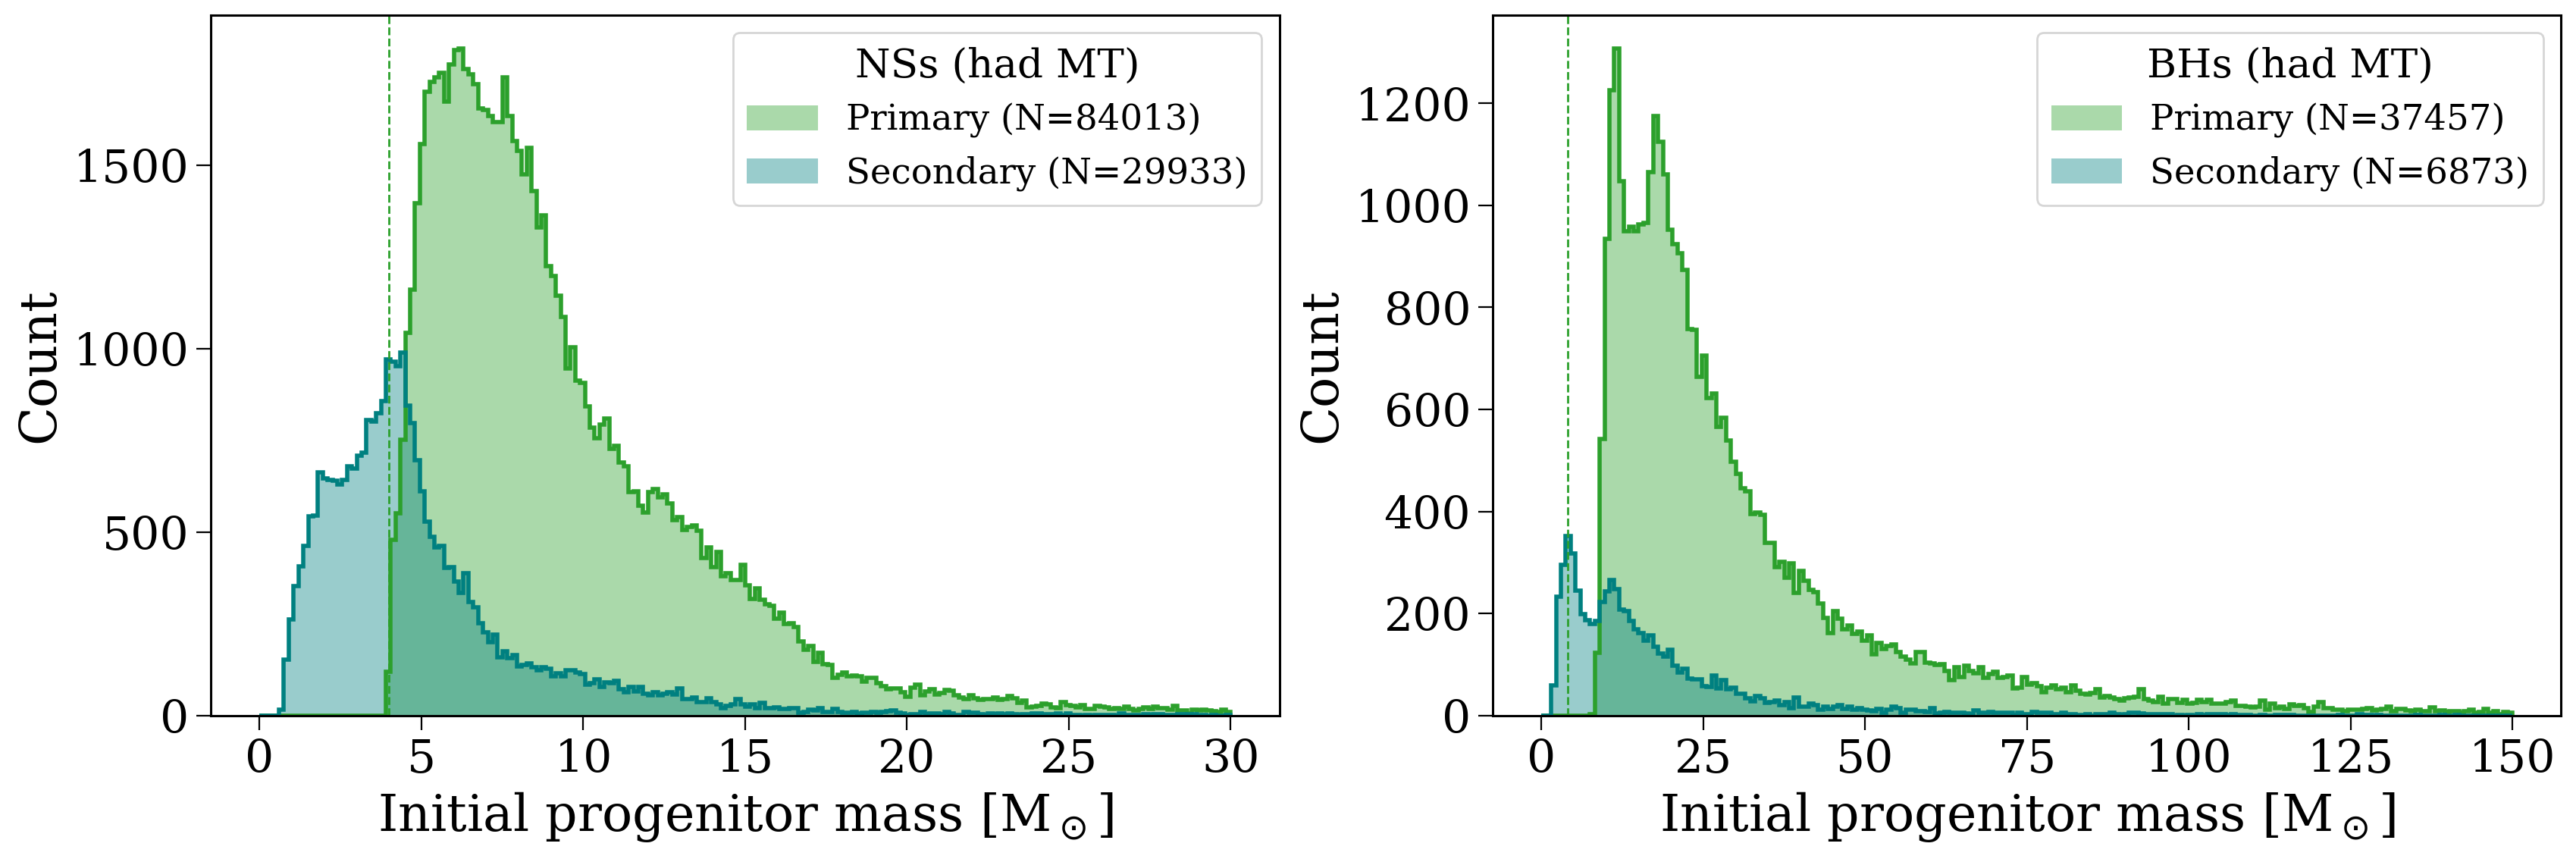

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    pop = binaries
    for comp, colour, label in zip(["1", "2"], ["tab:green", "teal"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            # & ~(pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")
        
    ax.axvline(4, color="tab:green", ls='--', lw=1)

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had MT)")
plt.show()

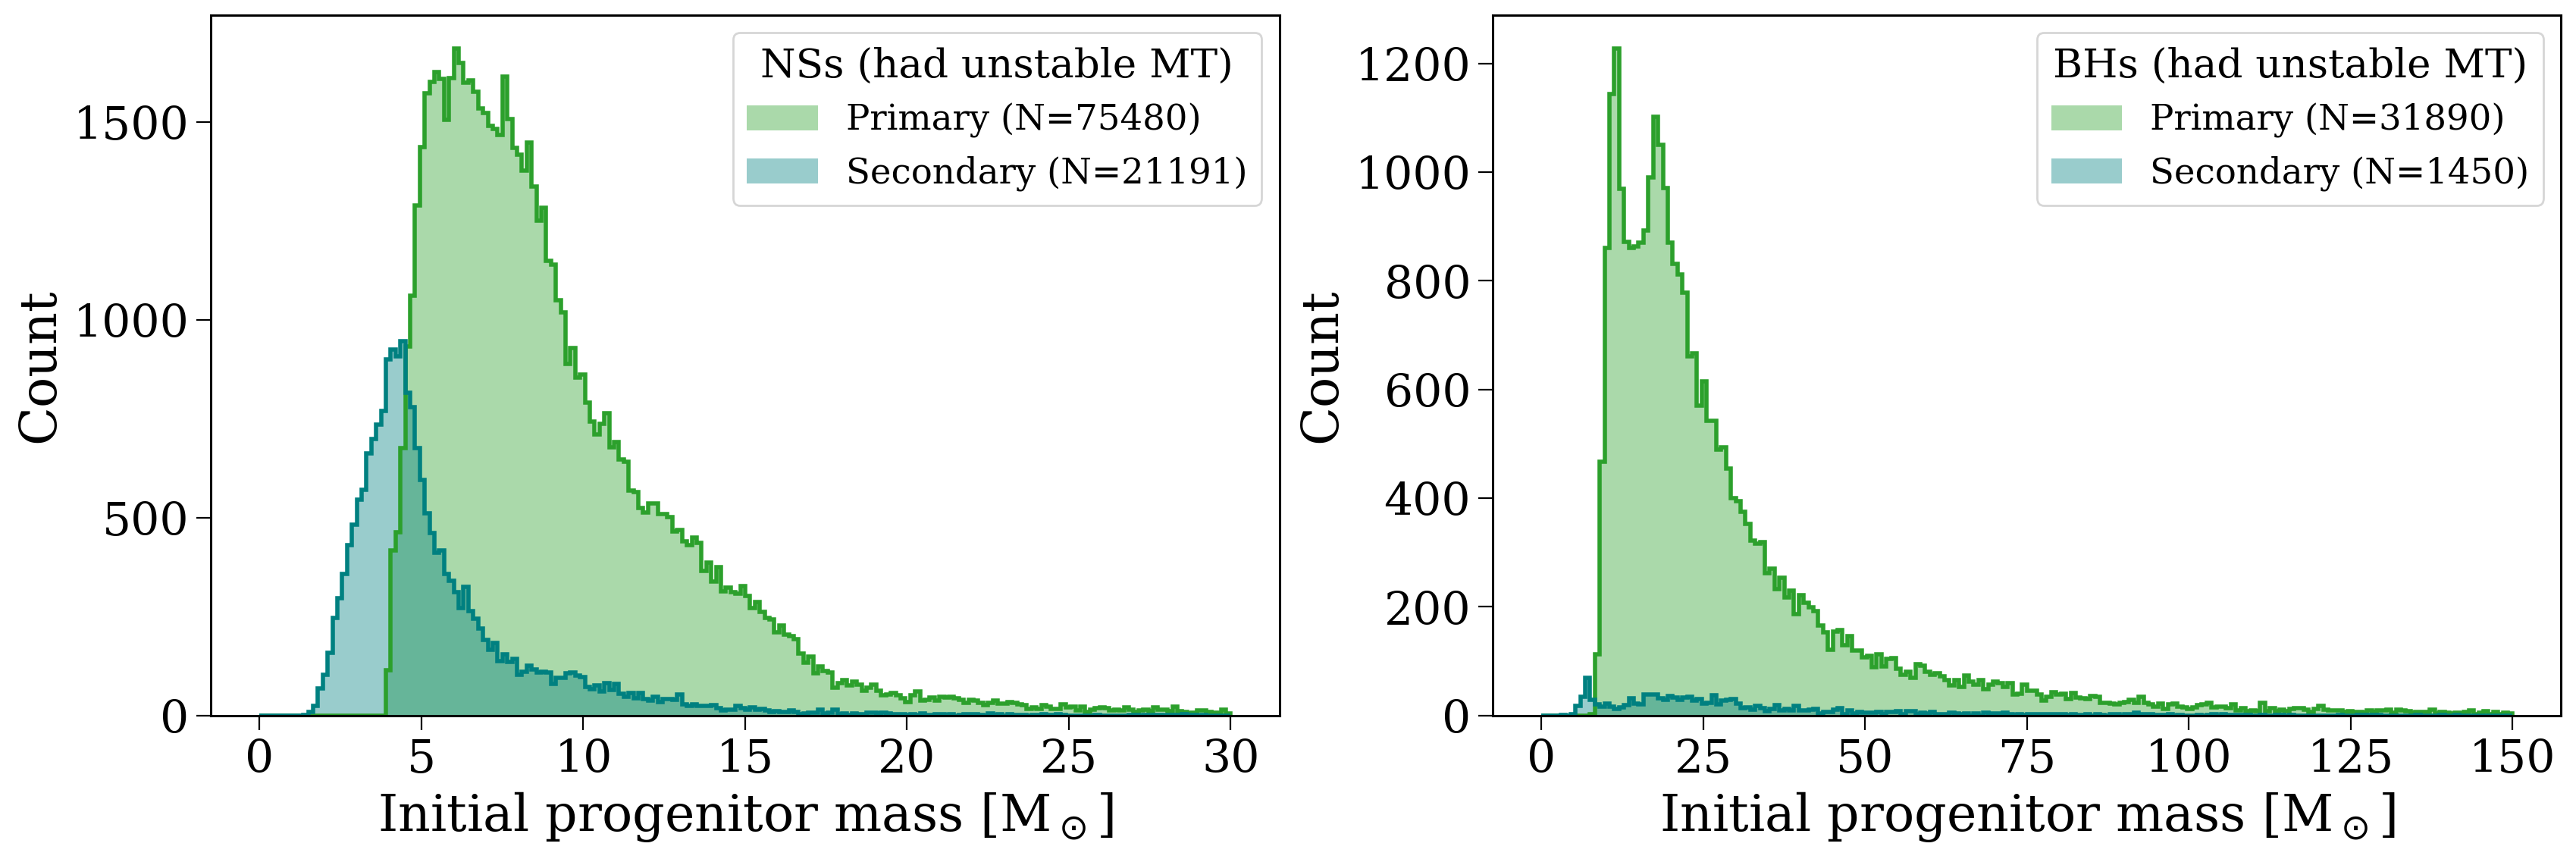

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 30, 201), np.linspace(0, 150, 201)]):
    pop = binaries
    for comp, colour, label in zip(["1", "2"], ["tab:green", "teal"], ["Primary", "Secondary"]):
        experienced_mt = pop.bpp[pop.bpp["evol_type"] == 3]["bin_num"]
        experienced_ce = pop.bpp[pop.bpp["evol_type"] == 7]["bin_num"]

        init_masses = pop.initC[f"mass_{comp}"][(
            (pop.final_bpp[f"kstar_{comp}"] == kstar)
            & (pop.final_bpp["bin_num"].isin(experienced_mt))
            & (pop.final_bpp["bin_num"].isin(experienced_ce))
        )]

        ax.hist(init_masses, bins=bins, histtype='step', lw=2, color=colour)
        ax.hist(init_masses, bins=bins, alpha=0.4, color=colour,
                label=f"{label} (N={len(init_masses)})")

    ax.set(
        xlabel=f"Initial progenitor mass [M$_\odot$]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s (had unstable MT)")
plt.show()

## Metallicity

Worrying spike up at $Z = 0.03$

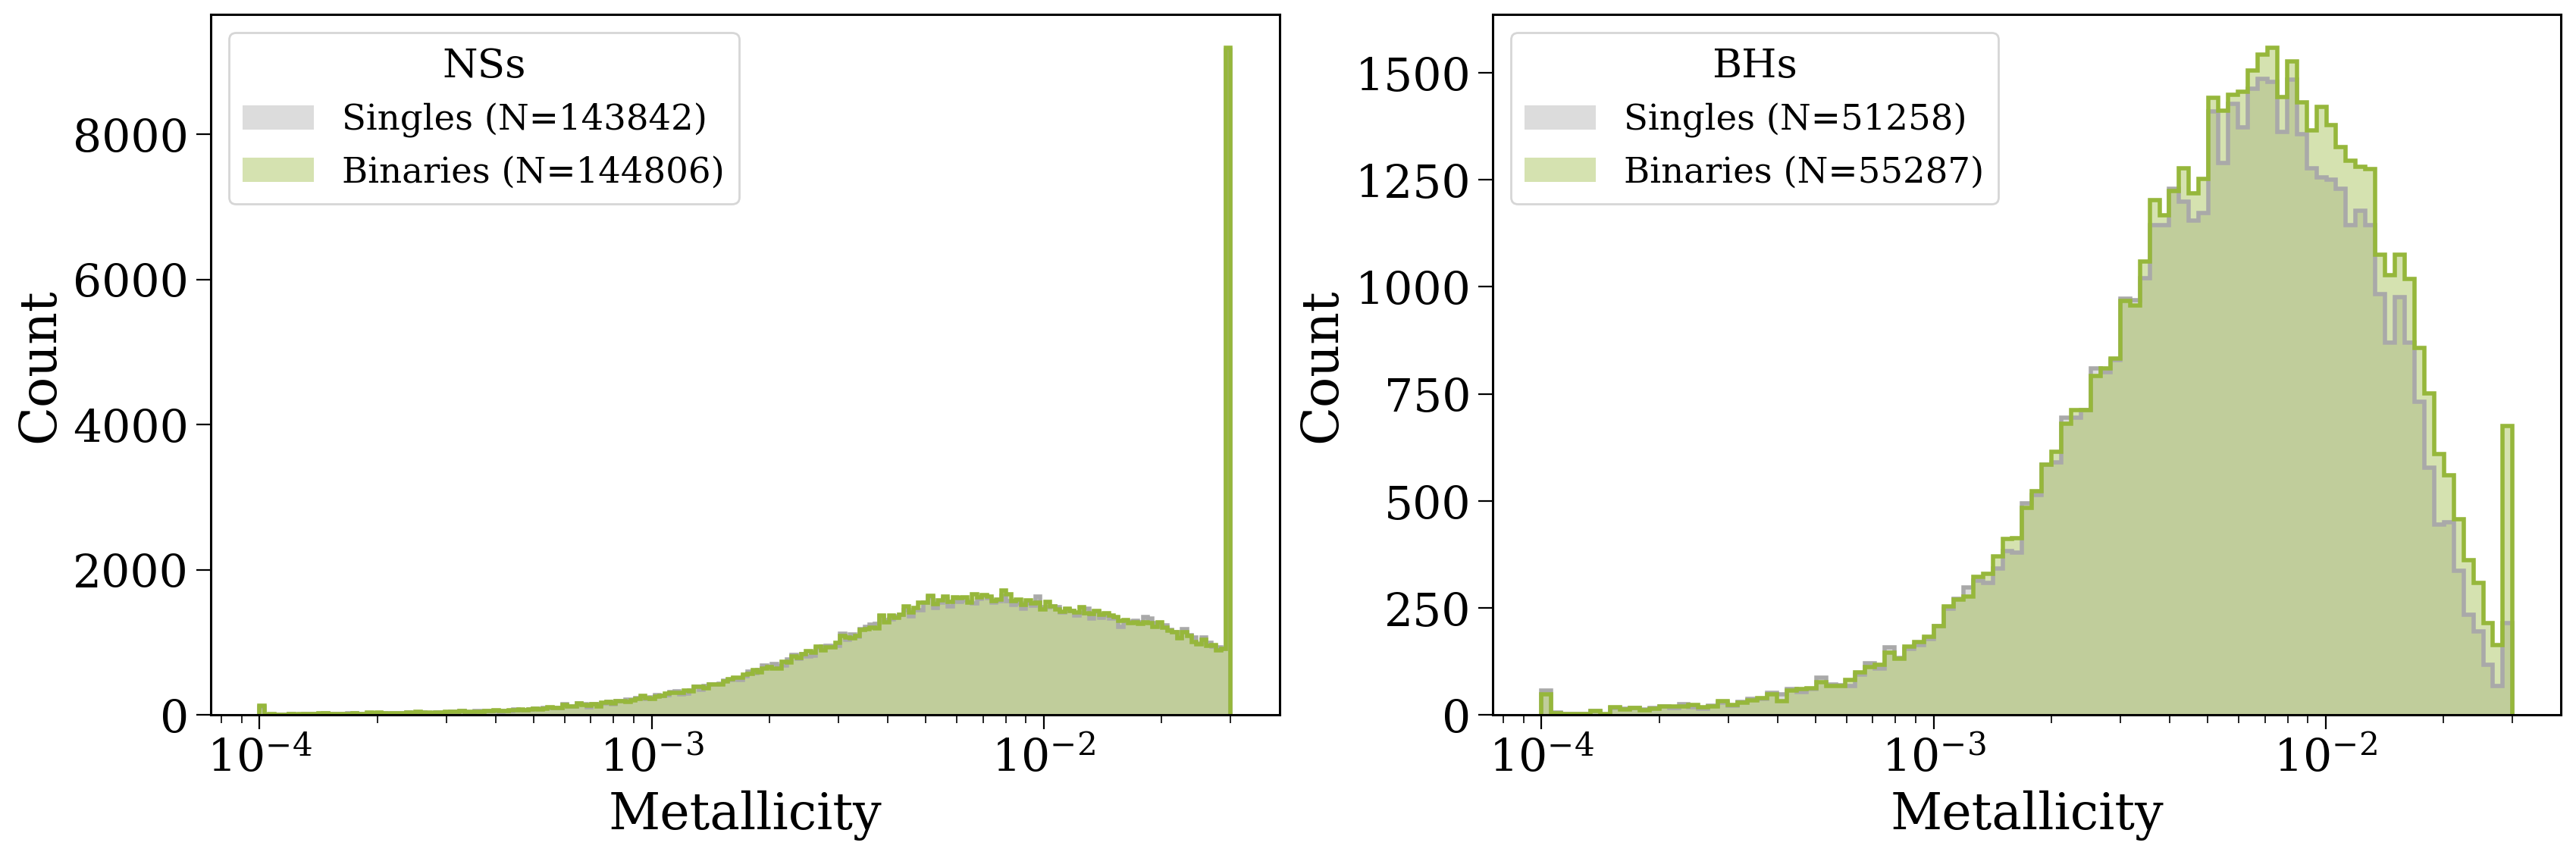

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.geomspace(1e-4, 0.03, 200), np.geomspace(1e-4, 0.03, 100)]):
    for pop in [singles, binaries]:
        init_Z = np.concatenate((
            pop.initC["metallicity"][pop.final_bpp["kstar_1"] == kstar],
            pop.initC["metallicity"][pop.final_bpp["kstar_2"] == kstar]
        ))

        ax.hist(init_Z, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(init_Z, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(init_Z)})")

    ax.set(
        xlabel=f"Metallicity",
        ylabel="Count",
        xscale='log'
    )
    ax.legend(title=f"{co_type}s")
plt.show()

## Formation time

Basically no change on galactic scales

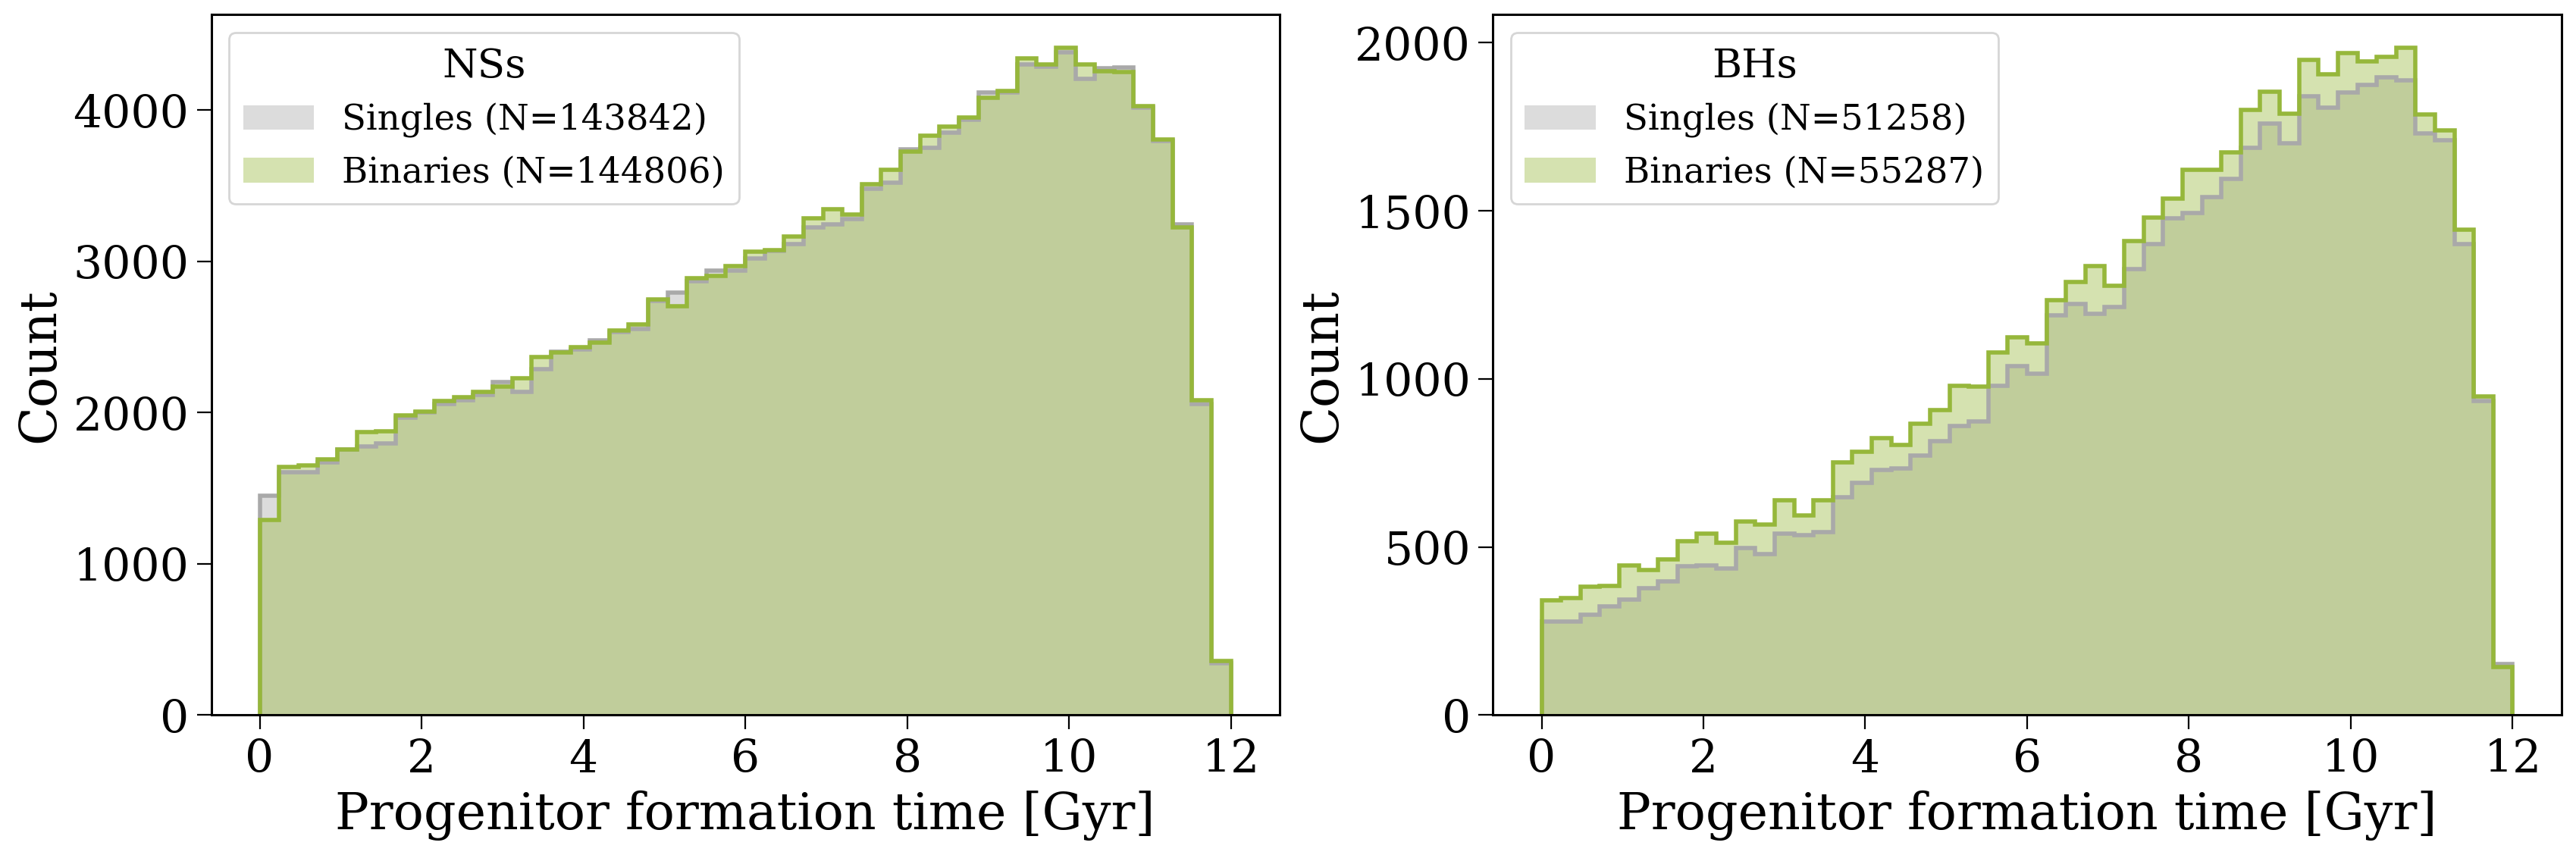

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 12, 51), np.linspace(0, 12, 51)]):
    for pop in [singles, binaries]:
        tau = pd.read_hdf(pop._file, "initial_galaxy")["tau"].values
        formation_time = np.concatenate((
            tau[pop.final_bpp["kstar_1"] == kstar],
            tau[pop.final_bpp["kstar_2"] == kstar]
        ))

        ax.hist(formation_time, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(formation_time, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(formation_time)})")

    ax.set(
        xlabel=f"Progenitor formation time [Gyr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

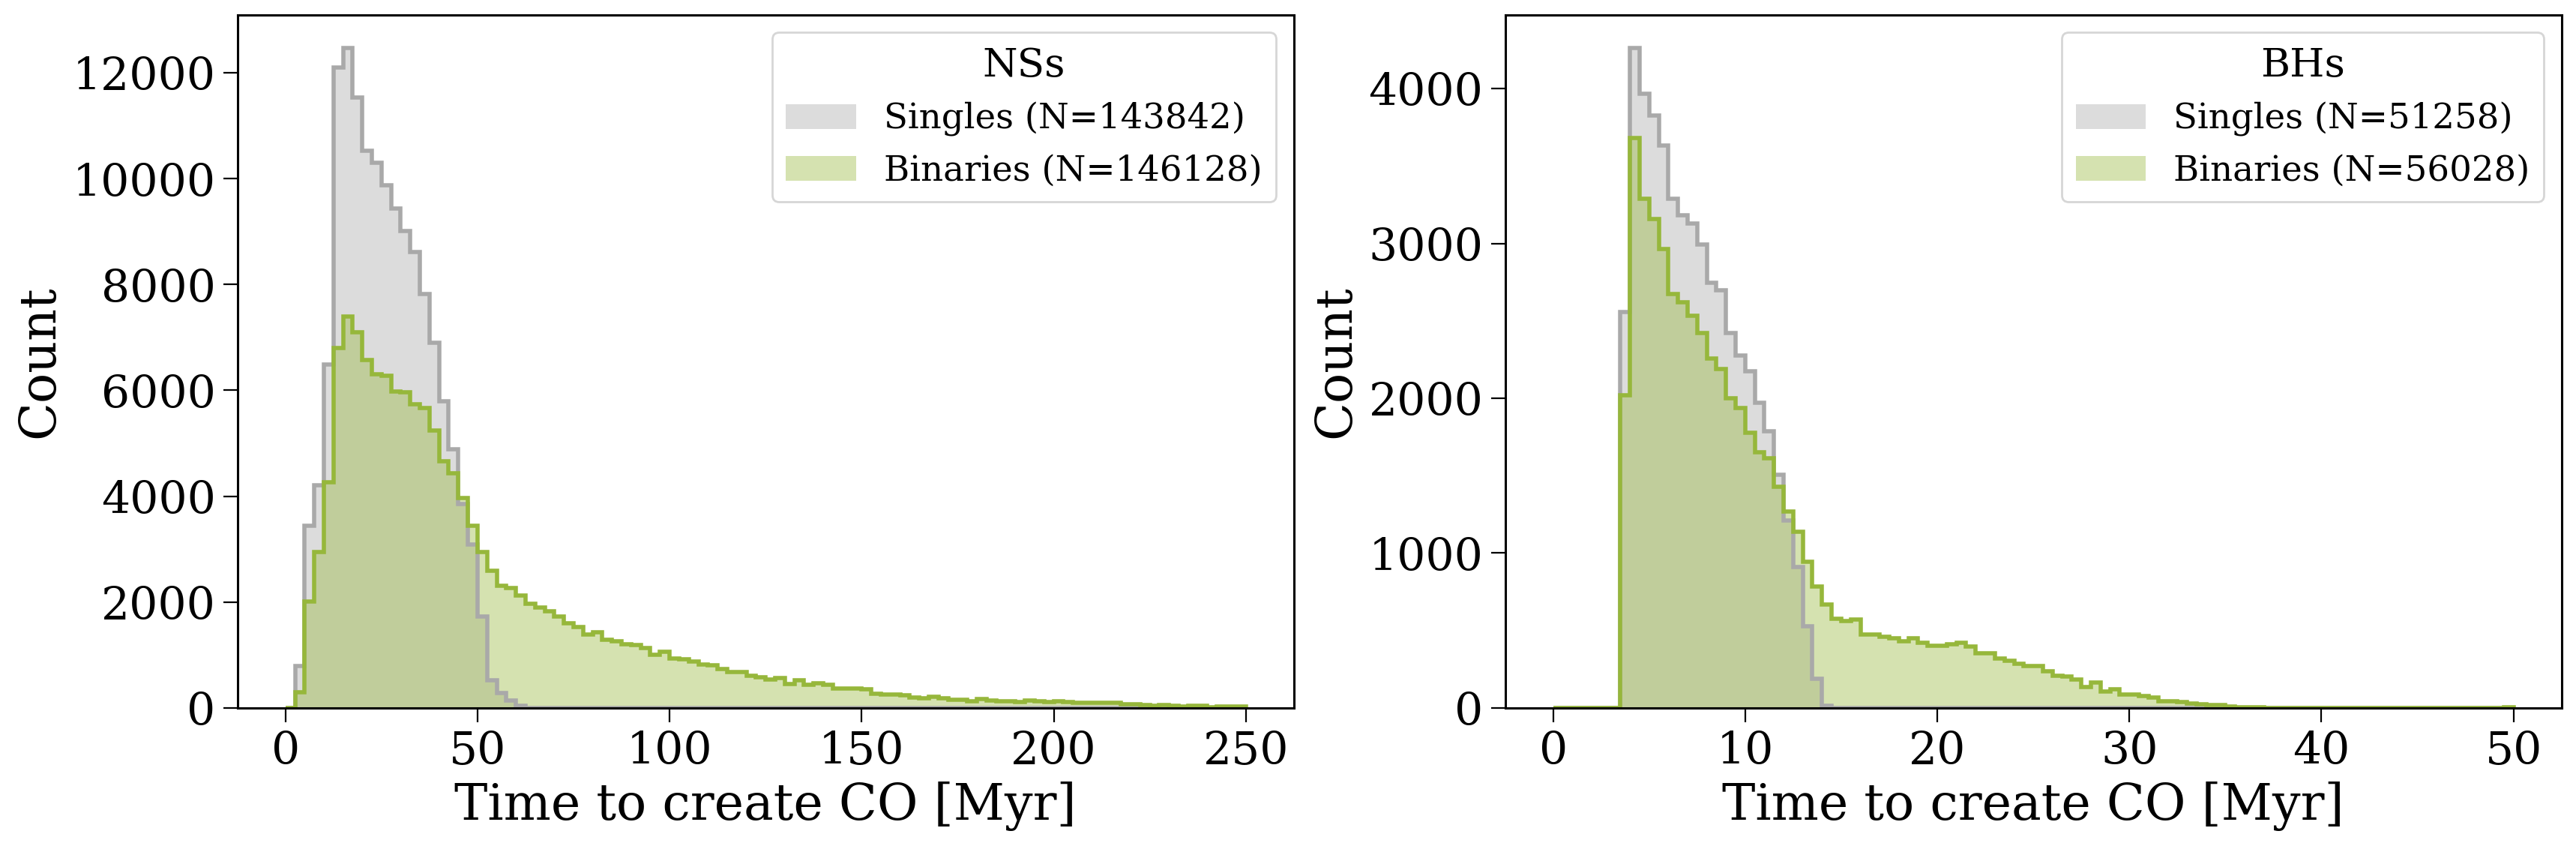

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 250, 101), np.linspace(0, 50, 101)]):
    for pop in [singles, binaries]:
        co_form_time = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
        ))

        ax.hist(co_form_time, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(co_form_time, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(co_form_time)})")

    ax.set(
        xlabel=f"Time to create CO [Myr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

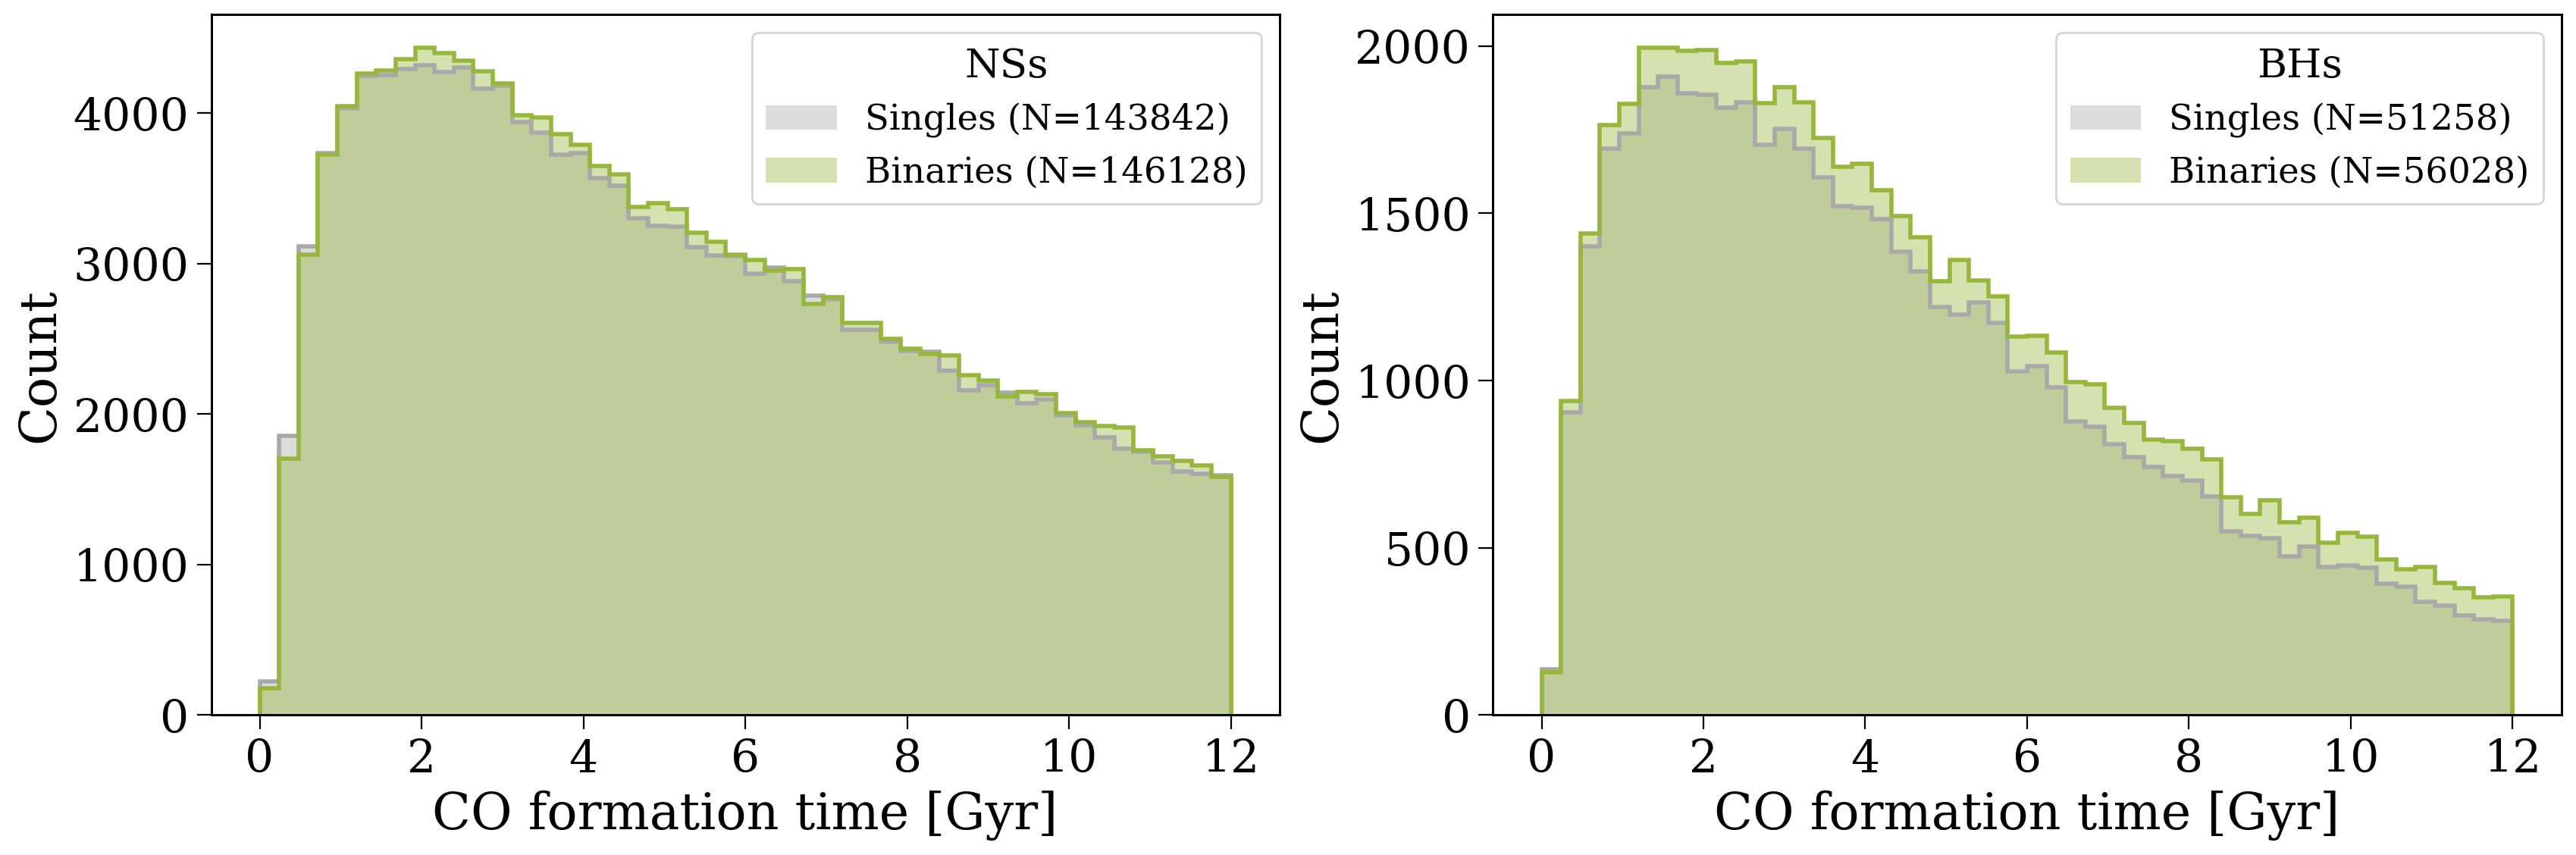

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

for ax, co_type, kstar, bins in zip(axes, ['NS', 'BH'], [13, 14],
                                    [np.linspace(0, 12, 51), np.linspace(0, 12, 51)]):
    for pop in [singles, binaries]:
        initial_galaxy = pd.read_hdf(pop._file, "initial_galaxy")
        initial_galaxy.index = pop.bin_nums
        co_form_time = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["tphys"].values,
        ))
        co_form_nums = np.concatenate((
            pop.bpp[pop.bpp["kstar_1"] == kstar].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
            pop.bpp[pop.bpp["kstar_2"] == kstar].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
        ))
        lookback_times = initial_galaxy.loc[co_form_nums]["tau"].values
        galaxy_age = 12

        time_of_co_formation = galaxy_age - lookback_times + co_form_time / 1000

        ax.hist(time_of_co_formation, bins=bins, histtype='step', lw=2, color=pop.colour)
        ax.hist(time_of_co_formation, bins=bins, alpha=0.4, color=pop.colour,
                label=f"{pop.label} (N={len(time_of_co_formation)})")

    ax.set(
        xlabel=f"CO formation time [Gyr]",
        ylabel="Count"
    )
    ax.legend(title=f"{co_type}s")
plt.show()

## Galactic component

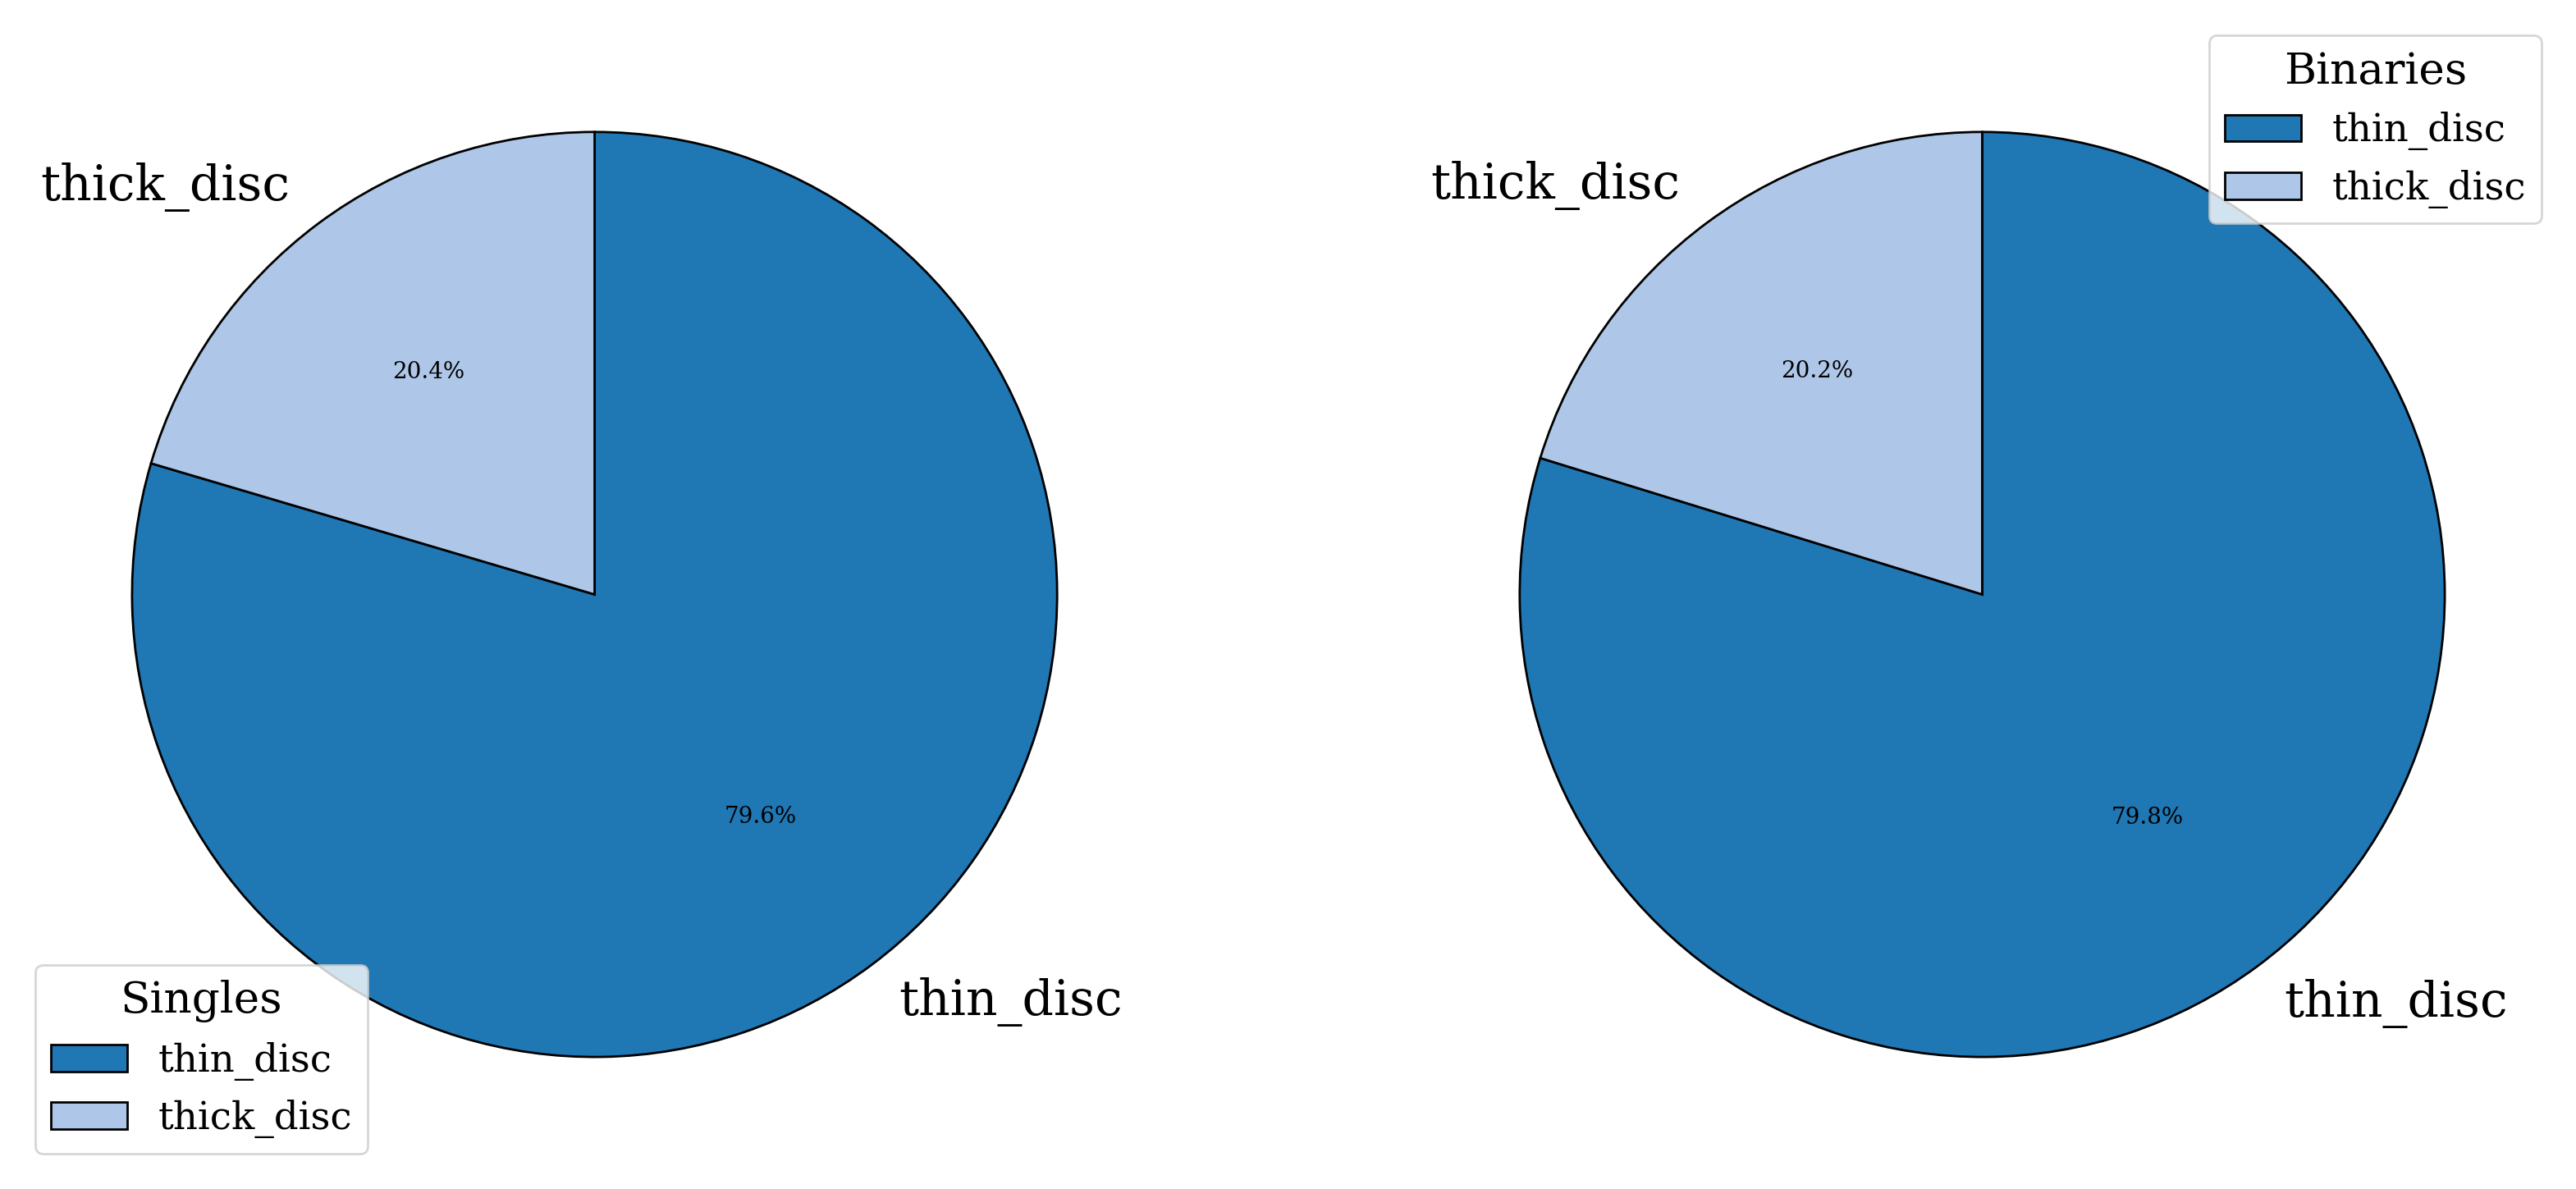

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

for ax, pop in zip(axes, [singles, binaries]):
    initial_galaxy = pd.read_hdf(pop._file, "initial_galaxy")
    initial_galaxy.index = pop.bin_nums
    co_form_nums = np.concatenate((
        pop.bpp[pop.bpp["kstar_1"].isin([13, 14])].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
        pop.bpp[pop.bpp["kstar_2"].isin([13, 14])].drop_duplicates(subset="bin_num", keep="first")["bin_num"].values,
    ))
    
    ax.pie(
        initial_galaxy.loc[co_form_nums]["which_comp"].value_counts().values,
        labels=initial_galaxy.loc[co_form_nums]["which_comp"].value_counts().index,
        autopct='%1.1f%%',
        colors=mpl.colormaps['tab20'].colors,
        startangle=90,
        counterclock=False,
        wedgeprops={'edgecolor': 'black'}
    )
    ax.legend(title=f"{pop.label}")
plt.show()